<h1 style="text-align:center;font-size:30px;" > Forge Signature Detection </h1>

<img src='signature.png'/>

# List of Contents :
* Description
* Problem Statement
* Source of Data
* Business Objectives and Constrains
* Data Overview
* Mapping Real World Problem to Machine Learning Problem
* Performance Metric

# Description
In present forensic authentication is performed by visual examination of biometric signature by the expert without relying on a computer system. Manual examination of authentication depends on experts physical and mental condition also availability of experts is not possible all the time. Think about the situation where thousands of the documents to be examined by the experts, Such a case could not be handled manually in a given time.


Not only in forensic authentication, Forge signature is a big problem in many areas like unauthorized cash withdrawal from banks, property takeover, illegal money transfer etc. Automatic forge detection technique will improve the security system and authentication of individuals.

# Problem Statement
The task is to predict whether the given signature is genuine or forge signature.

# Source of data
To perform forge signature detection, This case study refers this paper

http://www.iapr-tc11.org/archive/icdar2009/papers/3725b403.pdf

and the dataset is available in this link 

 http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2009_Signature_Verification_Competition_(SigComp2009)

# Objectives and Contrains
* <b>Latency requirement : </b> We do not need to predict whether the given signature is genuine or forge in milliseconds but it should not exceed for more than few minutes. 
* <b>Effect of misclassification : </b> Signature Forgery involves very sensitive cases like authentication of criminal, case withdrawal in banks and property overtaking. These are very sensitive cases where cost of misclassification will be very high.
* <b>Performance Objective : </b> In this task we want that every authentic signature should be predicted as genuine and every fake signature should be predicted as forge signature with high precision and recall.
* <b>Output : </b> Our model output would tell the similarity score between actual signature and questioned signature. Instead of giving binary output we want our model to give probalistic output such that if the questioned signature is genuine then the output should be close to 1 and if the questioned signature is fake then the output should be close to 0.

# Data Overview
The dataset we have consists two different dataset for training and evaluation called SigComp2009-training and SigComp2009-evaluation.
### SigComp2009-training
The name of this signature dataset is ‘NISDCC’ which is derived from the acronyms from both the NISlab (NIS) and Donders Centre for Cognition (DCC). They collected the signature by both online and offline fashion.

<b>Offline Data : </b> The offline training data contains static information only. This dataset is composed of 1920 images from 12 authentic writers (5 authentic signatures per writer) and 31 forging writers (5 forgeries per authentic signature). The static information is nothing but a .png Image file.

<b>Online Data : </b> Online Training data contains dynamic information. This data is available in form of text and stored in .hwr format. To understand dynamic information let’s look at the below figure.
<img src='sig1.png'  width="400" height="400" >
The left one is the original signature and the image at right side is segments of that original image. While recording online information they captured five features for each segment of the signature. Those five features are
* x = x-position on tablet (raw tablet values)
* y = y-position on tablet (raw tablet values), (0,0) is bottom-left (!)
* p = pen pressure in raw tablet values, between [0-1023]
* a = azimuth angle of the pen (yaw) between [0-3600] (10*degrees)
* e = elevation angle of the pen (pitch) between [0-900] (10*degrees)

<b>File Naming : </b> 
    In training data we do not have separate files for genuine signature and forge signature. The original and forge signature is identified by the file name. Each writer is identified via a three digit identifier. The 12 authentic writers are identified as <aaa>={001,002,...012}. The 31 forgers are identified as <fff>={021,022,...,051}. Each signature is contained in a separate file, "NISDCC-<www>_<aaa>_<iii>" with extension ".hwr". Note that the writer identification <www> can refer to an authentic writer or forger. The index <idx> represents the position of the signature on the A4 sheet of paper. So, the file NISDCC-001_001_001.hwr contains the first signature written by the authentic writer <aaa>=001. Similarly, the fileNISDCC-051_012_005.hwr contains the last forged signature from <aaa>=012 written by forger <fff>=051.
    
### SigComp2009-evaluation
This dataset is used to calculate the performance of the model. For the evaluation dataset we have separate files for genuines and forgeries. The dataset collected at the Netherlands Forensic Insti- tute (NFI) was not provided to the participants before the evaluation of the systems and consists of authentic signatures from 100 newly introduced writers (each writer wrote his signature 12 times) and forged signatures from 33 writ- ers (6 forgeries per signature). Each authentic signature was forged by 4 writers. It has 1953 signatures for both the on- line and the offline dataset.

# Mapping Real World Problem to Machine Learning Problem
The Task is to predict whether the given signature is Genuine or Forge signature so the problem statement can be mapped into binary class classification task. 

# Performance Metric
Saying good or bad is not enough for the model, we need numerical metrics to evaluate the performance of the model. For this task we will use EER (Equal error rate) as performance metric of the model. Let’s first understand two terminologies which are FRR, FAR.

<b>FRR : </b> FRR stands for Flase Rejection Rate. In simple words FRR is high when genuine signature is predicted as forge signature.

<b>FAR : </b> FAR stands for False Acceptance Rate. FAR is high when forge signature is predicted as genuine signature.

<b>EER : </b> If we reduce FAR then FRR will be high and vise-versa. Either of the situation is undesirable. What we try to achieve with such systems is a balance between the two error types,  EER can be easily understand by below figure
<img src='EER.png'  width="400" height="400" >

https://www.sciencedirect.com/topics/computer-science/false-acceptance-rate#:~:text=For%20example%2C%20if%20a%20false,overall%20measure%20of%20system%20performance

# Import libreries

In [2]:
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import random
from statistics import mean , stdev
from scipy.stats import kurtosis
from scipy.stats import skew
from sklearn.metrics import confusion_matrix
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
import os
import sys
import glob
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.preprocessing import normalize
from scipy.misc import imresize
import seaborn as sns
from collections import defaultdict
import itertools
import random
from PIL import Image
from numpy import asarray
import cv2
import warnings
warnings.filterwarnings("ignore")
import re
#importing the required libraries
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

# Load data
### Online training data .hwr files
Let's see how this online data looks like

In [2]:
temp_data = np.loadtxt('SigComp2009-training/NISDCC-online-all-001-051/NISDCC-001_001_001.hwr',skiprows=1)
temp_data_df = pd.DataFrame(data = temp_data,columns = ['x_position','y_position','pen_pressure','azimuth_angle','elevation_angle'])
print('number of time stamps : ',len(temp_data_df))
temp_data_df.head(10)

number of time stamps :  937


x_position  y_position  pen_pressure  azimuth_angle  elevation_angle
0      6279.0     27113.0         134.0         1070.0            520.0
1      6279.0     27113.0         188.0         1070.0            520.0
2      6291.0     27168.0         226.0         1070.0            520.0
3      6291.0     27179.0         275.0         1080.0            530.0
4      6291.0     27189.0         327.0         1090.0            520.0
5      6291.0     27197.0         374.0         1090.0            520.0
6      6286.0     27197.0         425.0         1090.0            520.0
7      6286.0     27203.0         455.0         1100.0            520.0
8      6286.0     27203.0         485.0         1100.0            520.0
9      6286.0     27203.0         504.0         1100.0            520.0

<img src='first_sign.png'  width="500" height="500" >
Above online data are detected while making this signature. 

# Steps to prepare features for Online training and test data
For online training and test data we have series of time stamps for five features which is 'x_position' , 'y_position' , 'pen_pressure' , 'azimuth_angle' and 'elevation_angle'. One way to use this data directely to the model that takes time series data as input like LSTM but we will not use those time series model as we dont have lots of data to train such model.

Second way is to get features from those time series data so that we can use machine learning model for classification. In order to extract features from time series data we will follow these steps.

* Prepare pairs of files where first file corresponds to genuine signature and second file corresponds to either genuine or forge signature. 
* Prepare labels which is 1 if second file corresponds to genuine sign otherwise 0.
* Extract basic features such as mean , stdev , min , max , kurtosis , skewness.
* Extract Frequency based feature.
* While extracting these features take the absolute difference of features calulated for pair. The intution is the diffence will be small for label 1 and large for label 0.



## Extract features for online training data
In training data we some genuine signature data for which forge data is not available so first we will make list fo files for which both genuine and forge data is available.


In [75]:
# In this cell we will prepare two lists which contains only useful file name for genuine and forge signature of evaluation data.
file_name_forge = os.listdir('SigComp2009-evaluation/forgeries 2')
file_name_genuine = os.listdir('SigComp2009-evaluation/genuines 2')
useful_forge_file = []
useful_genuine_file = []
l1= []
l2 = []
for i in range(len(file_name_forge)):
    if file_name_forge[i].endswith('hwr'):
        pattern = re.compile('NFI\-\d{6}(\d{2})\.hwr')
        grp = re.search(pattern, file_name_forge[i])
        l1.append(grp.group(1))
        useful_forge_file.append(file_name_forge[i]) # This is the list of file name of all the forge signature
                                                     # for which genuine signature is available

for i in range(len(file_name_genuine)):
    if file_name_genuine[i].endswith('hwr'):
        pattern = re.compile('NFI\-\d{6}(\d{2})\.hwr')
        grp = re.search(pattern, file_name_genuine[i])
        if grp.group(1) in l1:
            l2.append(grp.group(1))
            useful_genuine_file.append(file_name_genuine[i])# This is the list of file name of all the genuine signature
                                                     # for which forge signature is available
print('forge signature Ids and their counts')
print(np.unique(l1,return_counts = True))
print('='*100)
print('genuine signature Ids and their counts')
print(np.unique(l2,return_counts = True))

forge signature Ids and their counts
(array(['02', '08', '16', '18', '24', '33', '35', '44', '46', '63', '70',
       '71', '77', '84', '85', '86', '89', '92', '93'], dtype='<U2'), array([23, 36, 30, 24, 36, 36, 24, 36, 24, 36, 35, 30, 36, 36, 36, 36, 35,
       36, 35]))
genuine signature Ids and their counts
(array(['02', '08', '16', '18', '24', '33', '35', '44', '46', '63', '70',
       '71', '77', '84', '85', '86', '89', '92', '93'], dtype='<U2'), array([12, 12, 12, 12, 12, 12, 12, 12, 11, 12, 12, 11, 12, 12, 12, 12, 12,
       12, 12]))


In [77]:
final_list = []
def get_training_data():
    '''
    This function will prepare 15K training data points and lables.
    '''
    genuine_folder  = 'SigComp2009-evaluation/genuines 2/'
    forge_folder  = 'SigComp2009-evaluation/forgeries 2/'
    
    for i in tqdm(range(15000)): # we will try to get 15000 traing data
        rand_input_1 = useful_genuine_file[random.randint(0,len(useful_genuine_file)-1)] # pick a random geuine signature file
        grp = re.search('NFI\-\d{6}(\d{2}\.hwr)',rand_input_1)
        grp.group(1) # this captures the extention of picked file
        list_of_input_2 = []
        list_of_input_2_genuine = [file for file in useful_genuine_file if file.endswith(grp.group(1))] # list of genuine signature with the same extention as picked file
        list_of_input_2_forge = [file for file in useful_forge_file if file.endswith(grp.group(1))]  # # list of forge signature with the same extention as picked file

        list_of_input_2.append(list_of_input_2_genuine[random.randint(0,len(list_of_input_2_genuine)-1)])
        list_of_input_2.append(list_of_input_2_forge[random.randint(0,len(list_of_input_2_forge)-1)])
        rx = random.randint(0,1)

        rand_input_2 = list_of_input_2[rx] # it can be either of genuine and forge signature file
        
        data1 = np.loadtxt(genuine_folder + rand_input_1,skiprows=1)
        temp1 = data1[np.logical_not(data1[:,4] > 900)] #remove all the rows for which azimuth angle > 900
        data_with_removed_outlier1 = temp1[np.logical_not(temp1[:,3] > 3600)] # remove all the rows for which elevation angle > 3600

        
        if rx==0: # rx==0 implies that rand_input_2 belongs to genuine  signature else forge signature    
            data2 = np.loadtxt(genuine_folder + rand_input_2,skiprows=1)
            temp2 = data2[np.logical_not(data2[:,4] > 900)] #remove all the rows for which azimuth angle > 900
            data_with_removed_outlier2 = temp2[np.logical_not(temp2[:,3] > 3600)] # remove all the rows for which elevation angle > 3600
            label = 1

        else:
            data2 = np.loadtxt(forge_folder + rand_input_2,skiprows=1)
            temp2 = data2[np.logical_not(data2[:,4] > 900)] #remove all the rows for which azimuth angle > 900
            data_with_removed_outlier2 = temp2[np.logical_not(temp2[:,3] > 3600)] # remove all the rows for which elevation angle > 3600
            label = 0
            
        feature_list = []
        for i in range(5):
            # raw features : x_pos , y_pos , pen_presssure, azimuth_angle, elevation_angle
            # calculate simple features for all five raw features 
            feature_list.append(abs(mean(data_with_removed_outlier1[:,i]) - mean(data_with_removed_outlier2[:,i])))
            feature_list.append(abs(stdev(data_with_removed_outlier1[:,i]) - stdev(data_with_removed_outlier2[:,i])))
            feature_list.append(abs(max(data_with_removed_outlier1[:,i]) - max(data_with_removed_outlier2[:,i])))
            feature_list.append(abs(min(data_with_removed_outlier1[:,i]) - min(data_with_removed_outlier2[:,i])))
            feature_list.append(abs(kurtosis(data_with_removed_outlier1[:,i]) - kurtosis(data_with_removed_outlier2[:,i])))
            feature_list.append(abs(skew(data_with_removed_outlier1[:,i]) - skew(data_with_removed_outlier2[:,i])))

            # calculate top two freq and corresponding amplitude for all five raw feature
            signals1 = data_with_removed_outlier1[:,i]
            fft_amp1 = np.fft.fft(signals1)
            freq1 = np.fft.fftfreq(len(signals1),1)
            fft_amp1 = abs(fft_amp1)[:(len(fft_amp1)//2)]
            freq1 = freq1[:len(freq1)//2]
            temp11 = np.argsort(fft_amp1)
            temp12 = temp11[-3:-1]
            top_two_amp1 = fft_amp1[temp12]
            top_two_freq1 = freq1[temp12]

            signals2 = data_with_removed_outlier2[:,i]
            fft_amp2 = np.fft.fft(signals2)
            freq2 = np.fft.fftfreq(len(signals2),1)
            fft_amp2 = abs(fft_amp2)[:(len(fft_amp2)//2)]
            freq2 = freq2[:len(freq2)//2]
            temp21 = np.argsort(fft_amp2)
            temp22 = temp21[-3:-1]
            top_two_amp2 = fft_amp2[temp22]
            top_two_freq2 = freq2[temp22]


            feature_list.extend(abs(np.array(top_two_amp1) - np.array(top_two_amp2)))
            feature_list.extend(abs(np.array(top_two_freq1) - np.array(top_two_freq2)))


        feature_list.append(abs(len(data_with_removed_outlier1) - len(data_with_removed_outlier2)))
        feature_list.append(label)
        final_list.append(feature_list)       


In [78]:
get_training_data()

column = ['x_pos_mean','x_pos_stdev','x_pos_max','x_pos_min','x_pos_kurtosis','x_pos_skew','x_pos_amp1','x_pos_amp2','x_pos_freq1','x_pos_freq2'
          ,'y_pos_mean','y_pos_stdev','y_pos_max','y_pos_min','y_pos_kurtosis','y_pos_skew','y_pos_amp1','y_pos_amp2','y_pos_freq1','y_pos_freq2'
          ,'pen_pressure_mean','pen_pressure_stdev','pen_pressure_max','pen_pressure_min','pen_pressure_kurtosis','pen_pressure_skew','pen_pressure_amp1','pen_pressure_amp2','pen_pressure_freq1','pen_pressure_freq2'
          ,'azimuth_angle_mean','azimuth_angle_stdev','azimuth_angle_max','azimuth_angle_min','azimuth_angle_kurtosis','azimuth_angle_skew','azimuth_angle_amp1','azimuth_angle_amp2','azimuth_angle_freq1','azimuth_angle_freq2'
          ,'ele_agnle_mean','ele_agnle_stdev','ele_agnle_max','ele_agnle_min','ele_agnle_kurtosis','ele_agnle_skew','ele_angle_amp1','ele_angle_amp2','ele_angle_freq1','ele_angle_freq2','num_of_time_stamp','label']


train_df = pd.DataFrame(data = final_list,columns = column)
test_df.head(10)

x_pos_mean  x_pos_stdev  x_pos_max  x_pos_min  x_pos_kurtosis  x_pos_skew  \
0  6702.729190   132.667140     6411.0     7679.0        0.214972    0.557652   
1   595.968286   282.808690      704.0      575.0        1.701763    0.330863   
2  6650.316513   452.479443     7855.0        0.0       32.130997    0.347810   
3  6969.919890   396.212594     6984.0     7697.0        0.605301    0.376312   
4   923.526831   104.262575      952.0       69.0        0.495307    0.757368   
5     0.000000     0.000000        0.0        0.0        0.000000    0.000000   
6   370.353153   212.198250       29.0       92.0        0.384812    0.445591   
7   403.046101   160.907990      132.0    19970.0       32.535922    3.199604   
8   171.790748    34.067864       86.0     5013.0        2.508287    0.605645   
9   384.688186   300.260829     1124.0      400.0        0.204104    0.343917   

      x_pos_amp1    x_pos_amp2  x_pos_freq1  x_pos_freq2  ...  ele_agnle_max  \
0  603040.655003  6.730478e+05     0.001176     0.000588  ...           10.0   
1   88270.817030  1.496346e+05     0.002433     0.001217  ...           90.0   
2  170135.916555  2.694438e+05     0.001583     0.000792  ...            0.0   
3   28449.092843  5.854434e+04     0.005525     0.002762  ...           10.0   
4  223207.025027  1.759223e+06     0.000637     0.000318  ...           60.0   
5       0.000000  0.000000e+00     0.000000     0.000000  ...            0.0   
6   45255.187121  1.542448e+05     0.006453     0.000005  ...           30.0   
7  582878.035745  1.788996e+06     0.006368     0.001337  ...           40.0   
8   64631.964825  3.132739e+04     0.001183     0.000004  ...          200.0   
9   62617.991635  1.133708e+05     0.004454     0.010090  ...           20.0   

   ele_agnle_min  ele_agnle_kurtosis  ele_agnle_skew  ele_angle_amp1  \
0           60.0            4.178175        1.011378    15091.302218   
1          100.0            6.268214        2.840279      668.453969   
2            0.0           33.567380        6.346759     3970.872092   
3           60.0            4.397844        3.557021     1885.717245   
4           60.0            0.938445        0.147533     5475.152143   
5            0.0            0.000000        0.000000        0.000000   
6          120.0            7.941357        0.485003     9017.355824   
7          450.0           11.570591        0.910723    28735.207684   
8          400.0           95.663174        6.606141     1547.681936   
9           80.0            0.174981        0.688222     5555.816224   

   ele_angle_amp2  ele_angle_freq1  ele_angle_freq2  num_of_time_stamp  label  
0    24905.787926         0.014359         0.008098               1129      0  
1     4435.563048         0.007031         0.001217                489      0  
2     5695.110937         0.033067         0.003295                502      0  
3     1986.606522         0.027624         0.013812                181      0  
4     8952.759891         0.003004         0.003143               2544      0  
5        0.000000         0.000000         0.000000                  0      1  
6     8178.520250         0.003688         0.000913                  6      1  
7    30399.759174         0.002675         0.004649               2537      0  
8     2523.834844         0.002280         0.010189                  3      1  
9     6348.093746         0.011233         0.014011                342      0  

[10 rows x 52 columns]

## Analysis of feature in training data
We are concern about the distribution of features. Expecting distribution of class1 data should be different from class0 data.

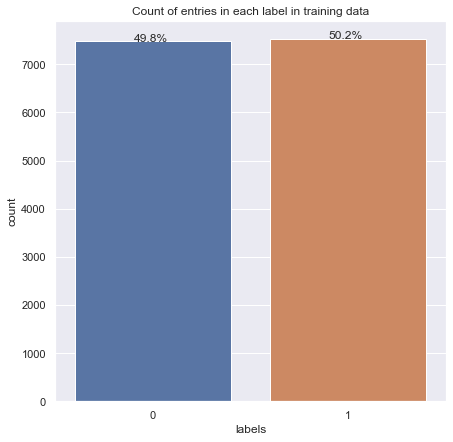

In [79]:
# reference : https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
sns.set(style="darkgrid")
plt.figure(figsize = (7,7))
ax = sns.countplot(x = "label", data = train_df, orient = 'V' )
plt.title('Count of entries in each label in training data')
plt.xlabel('labels')

total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x,y))
plt.show()

We prepared balanced dataset.

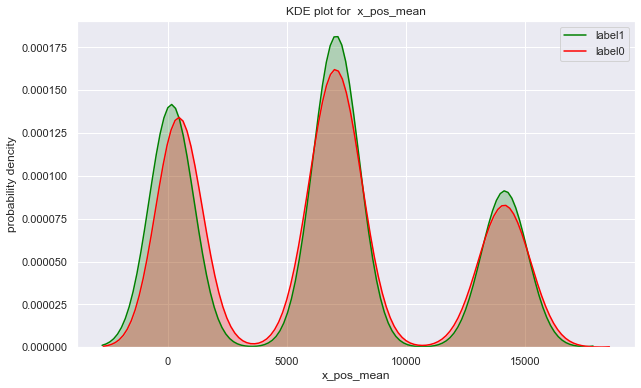

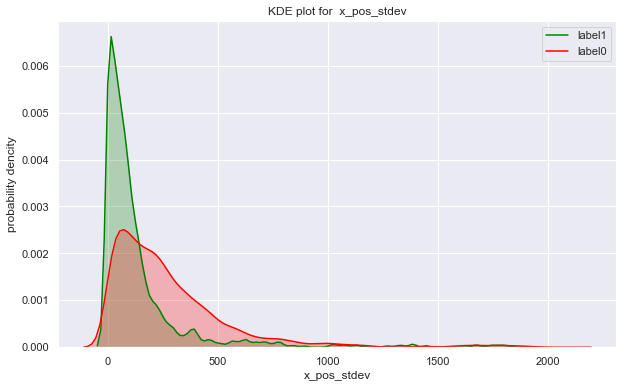

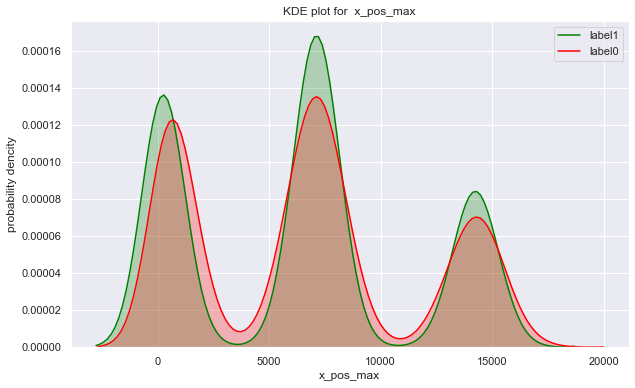

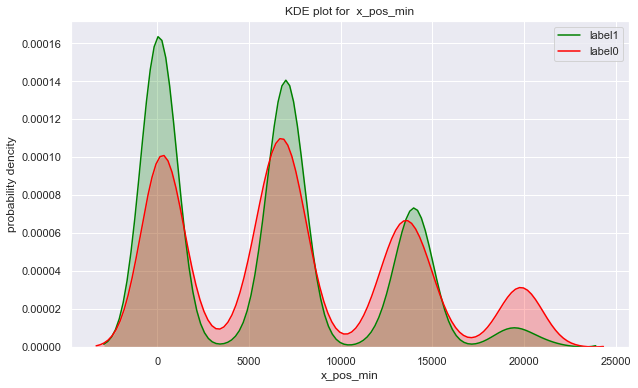

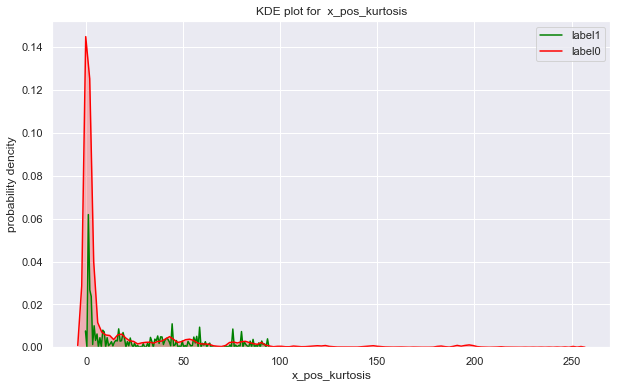

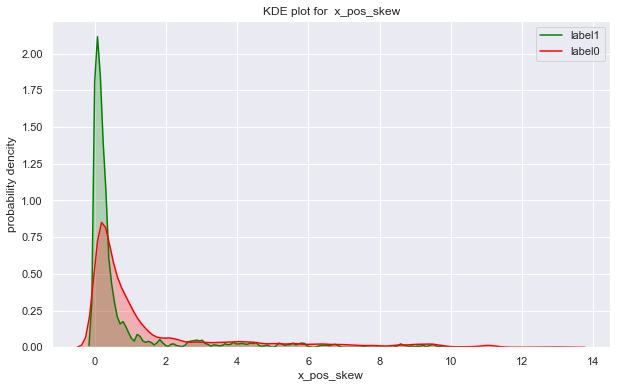

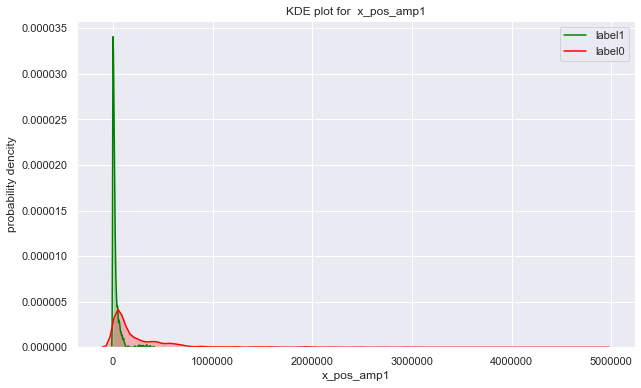

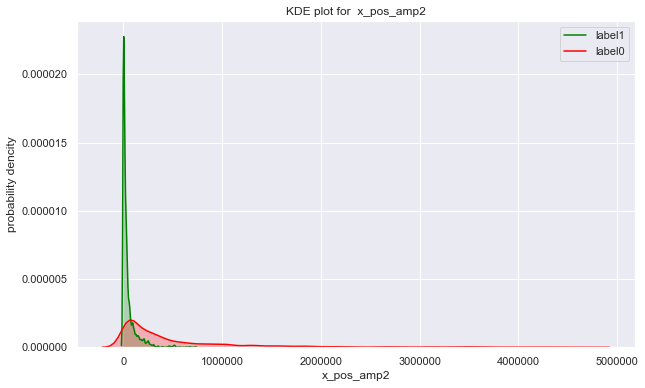

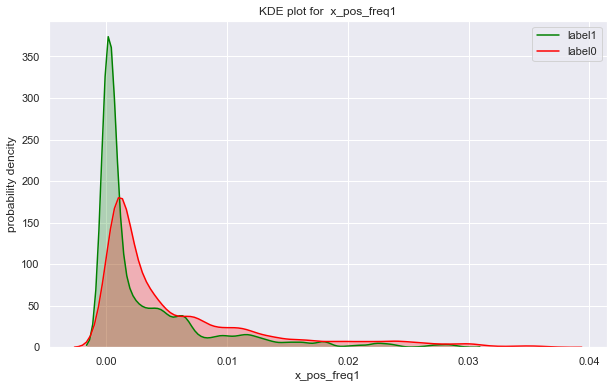

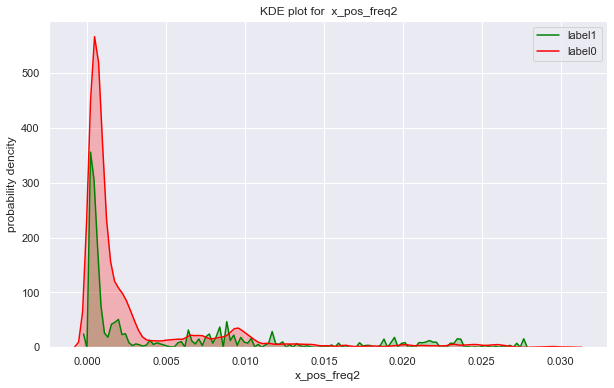

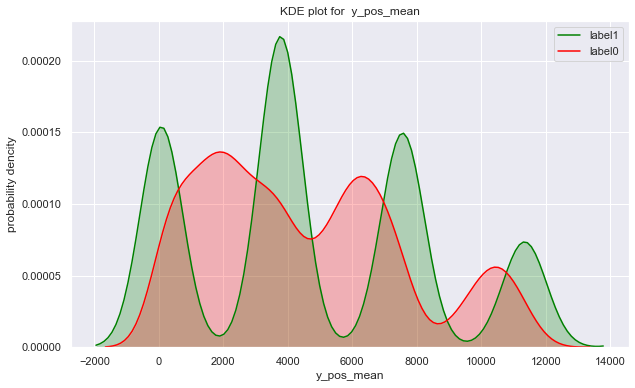

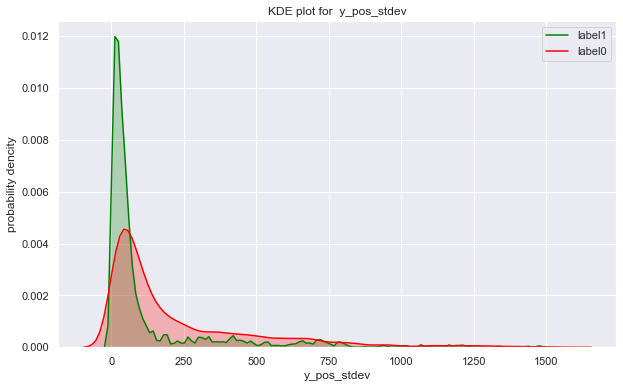

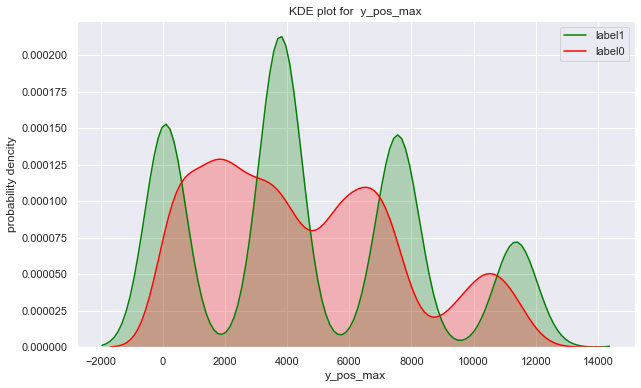

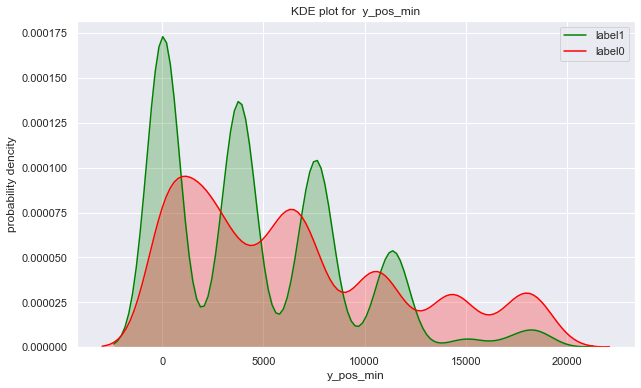

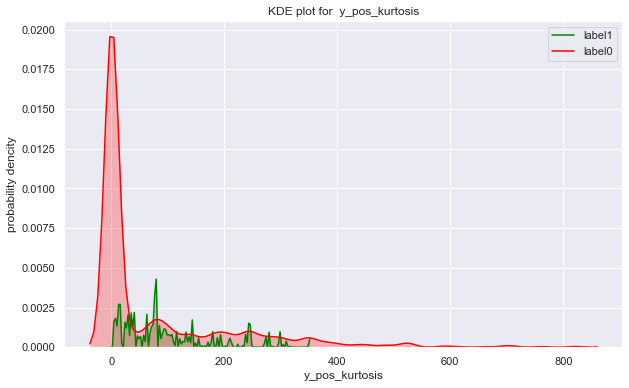

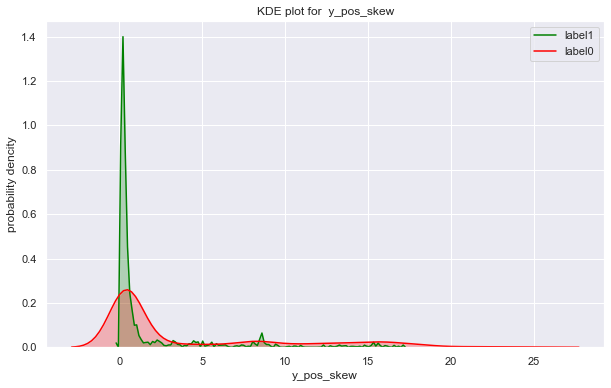

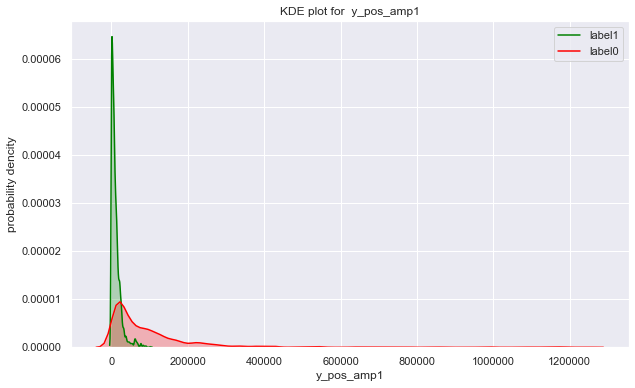

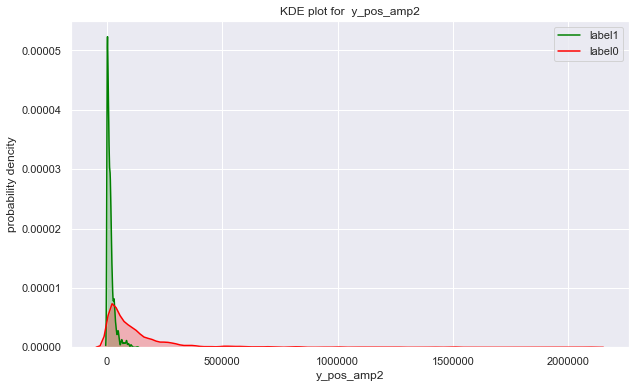

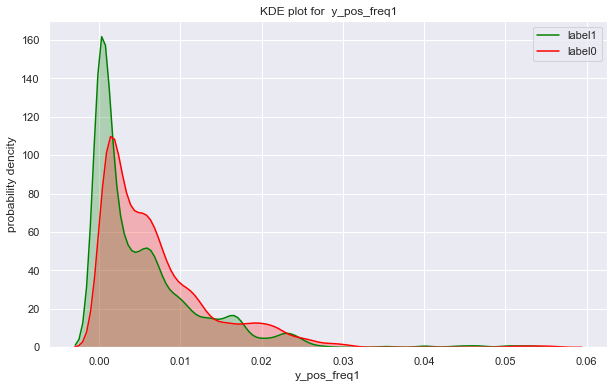

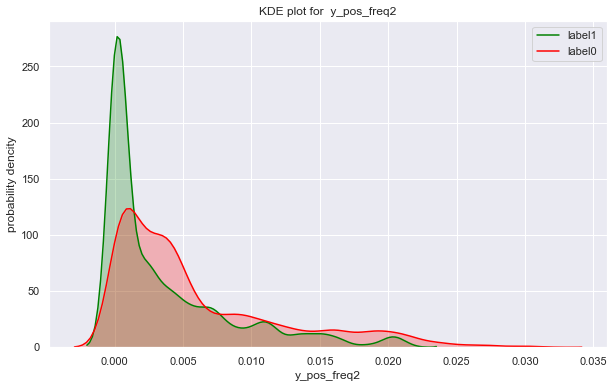

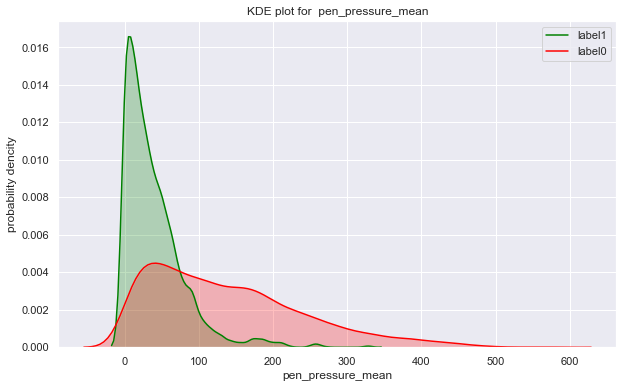

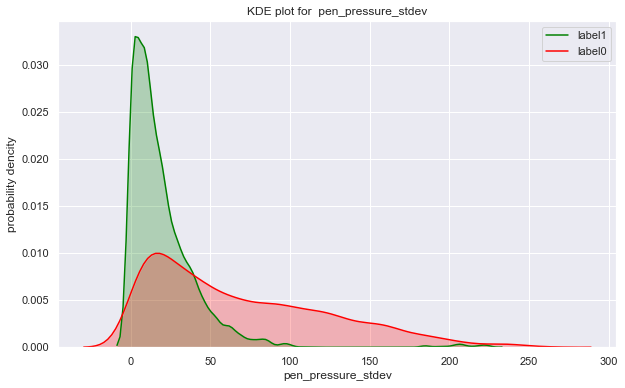

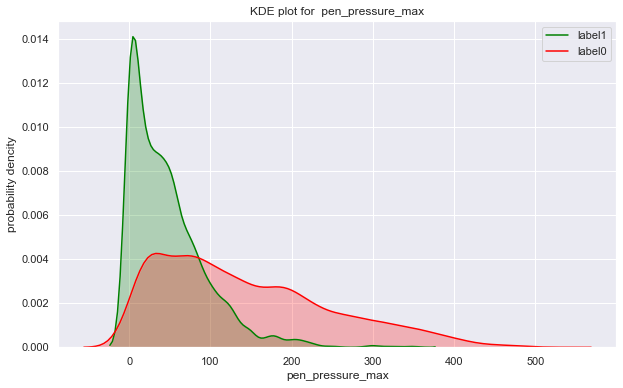

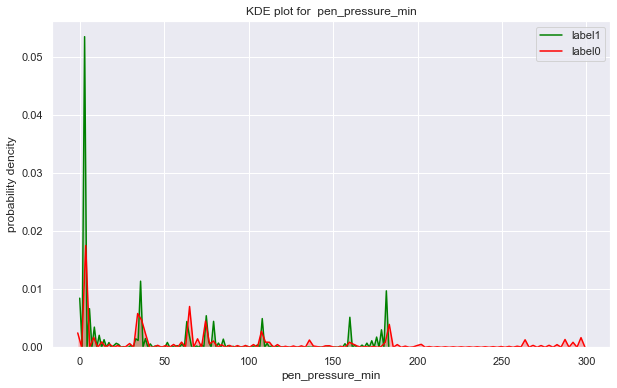

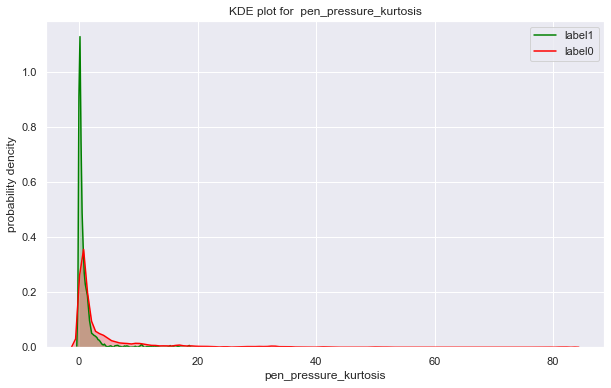

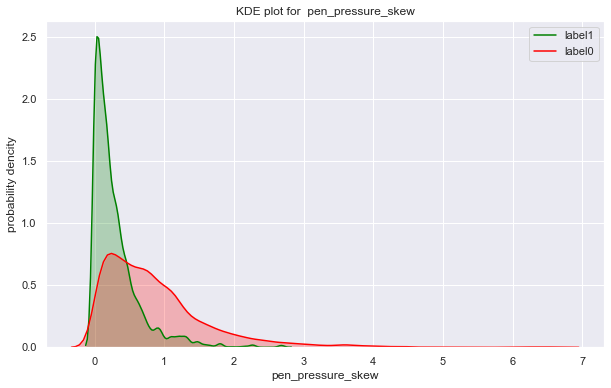

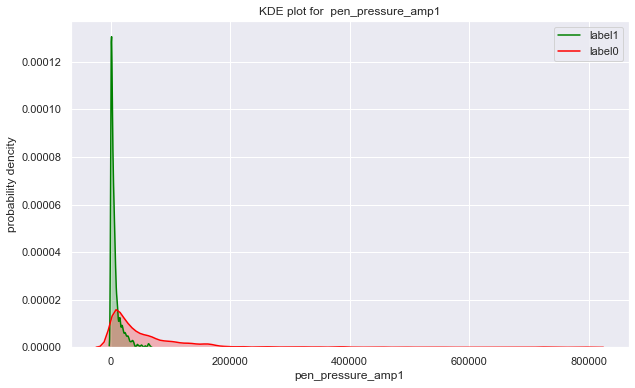

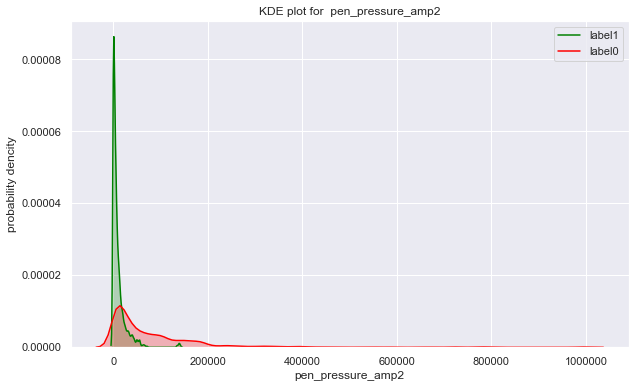

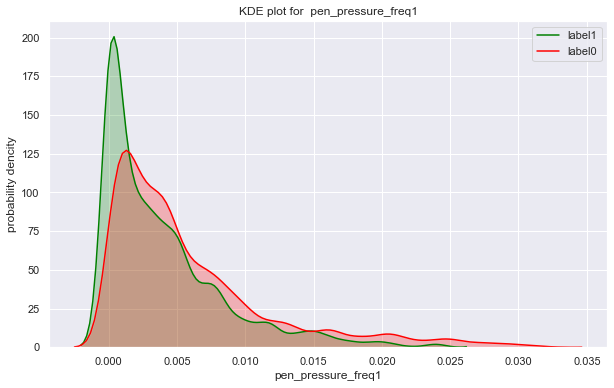

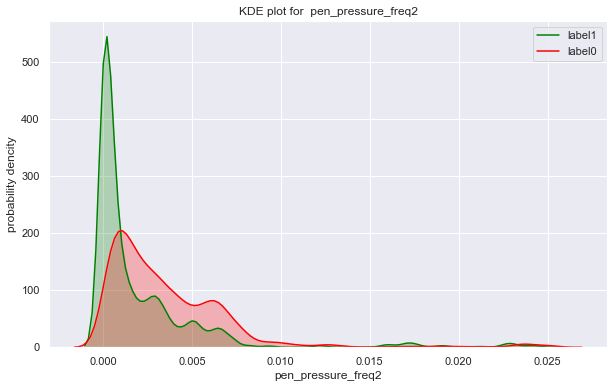

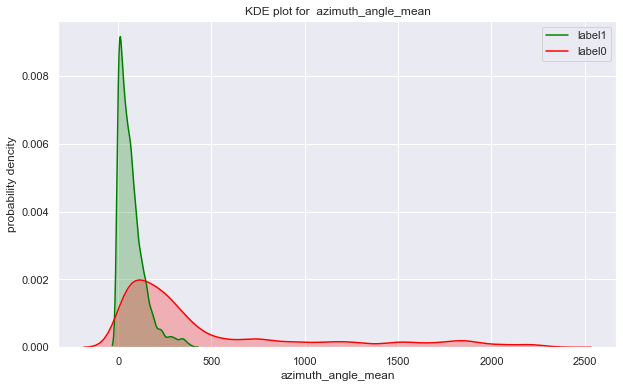

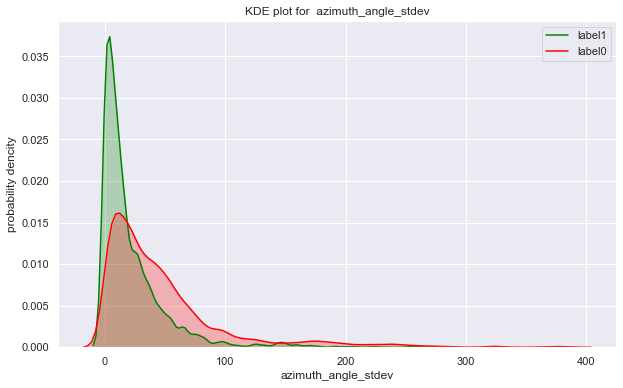

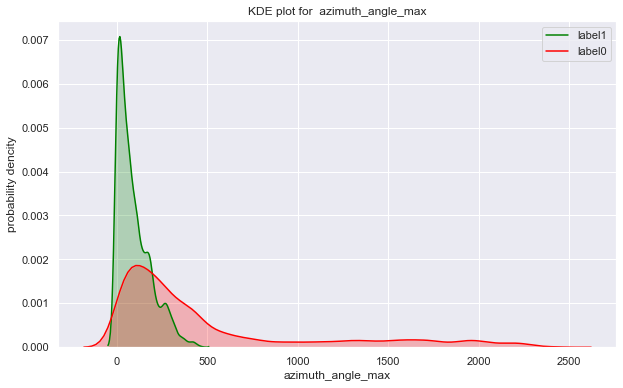

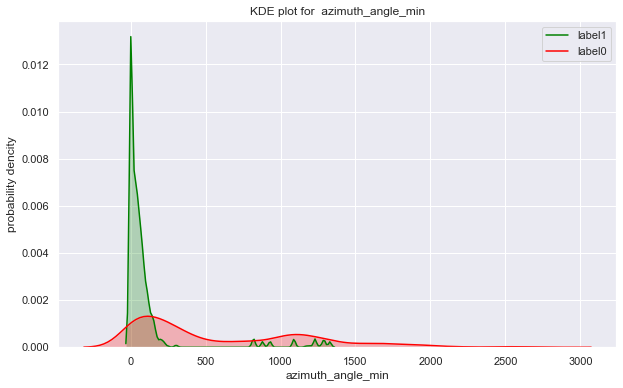

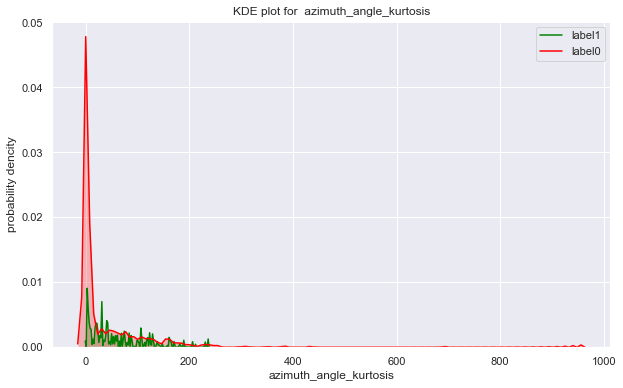

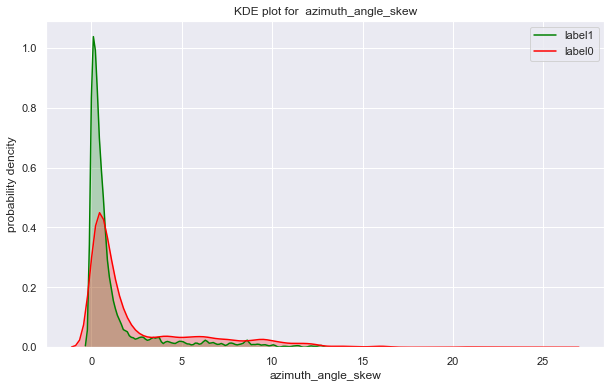

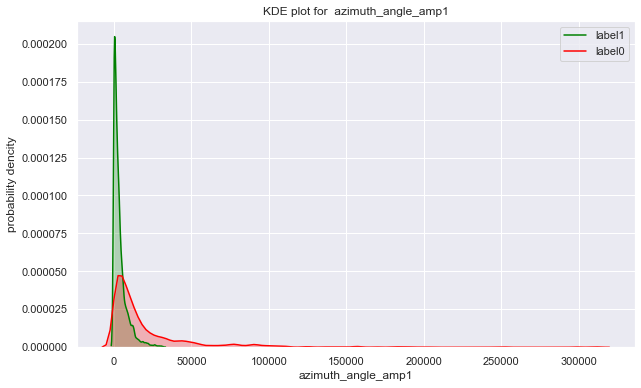

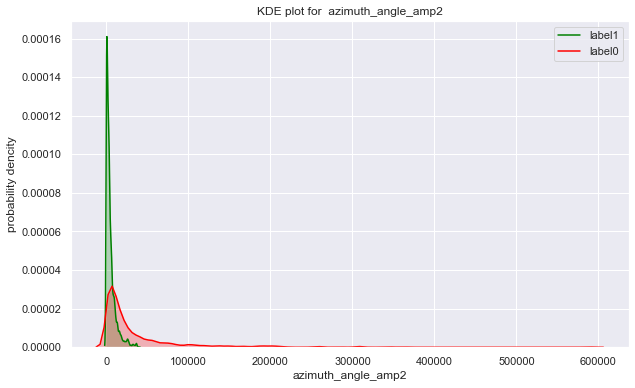

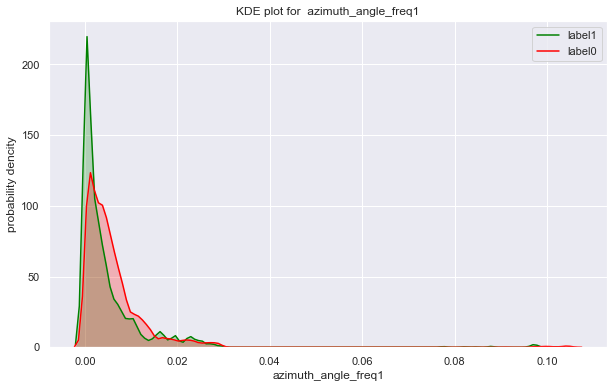

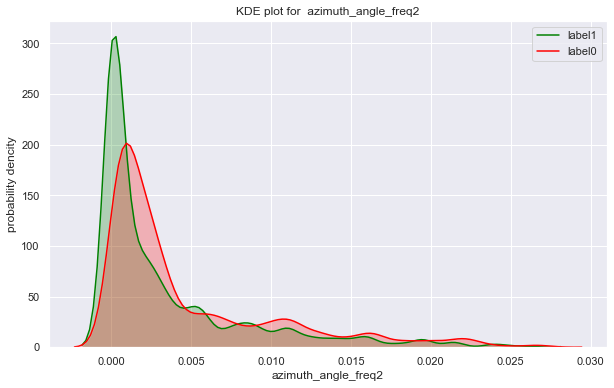

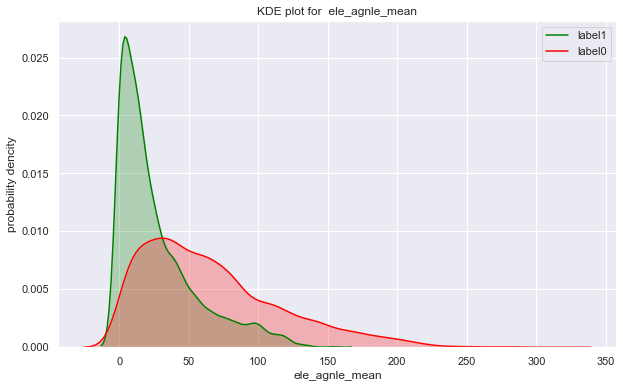

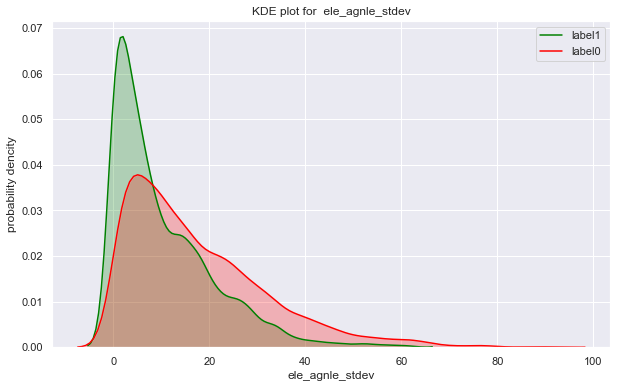

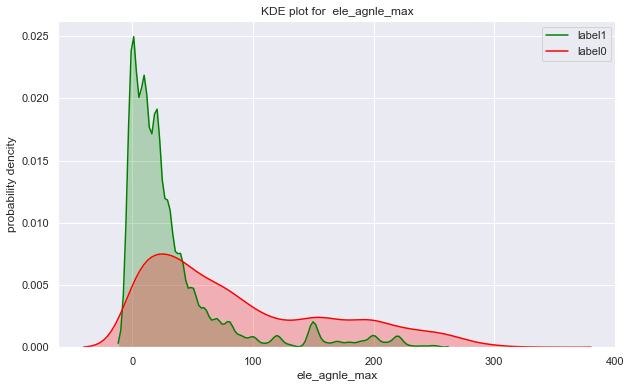

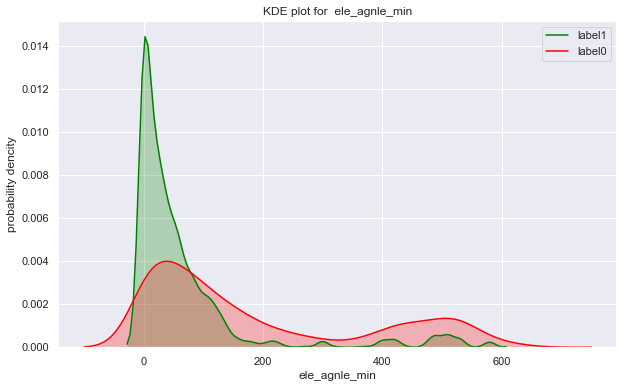

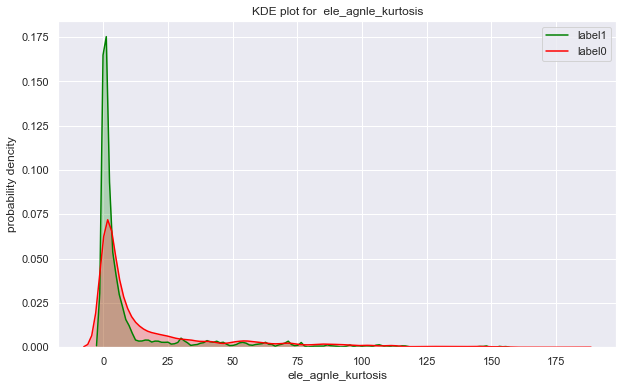

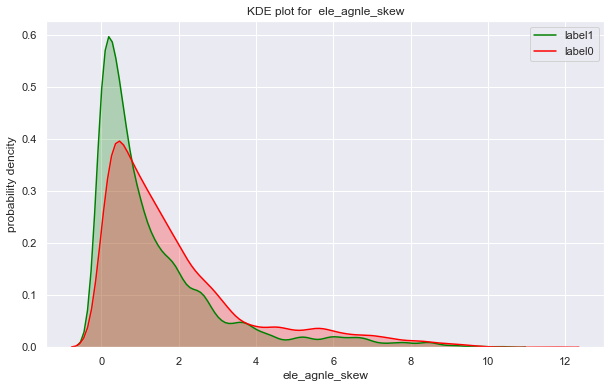

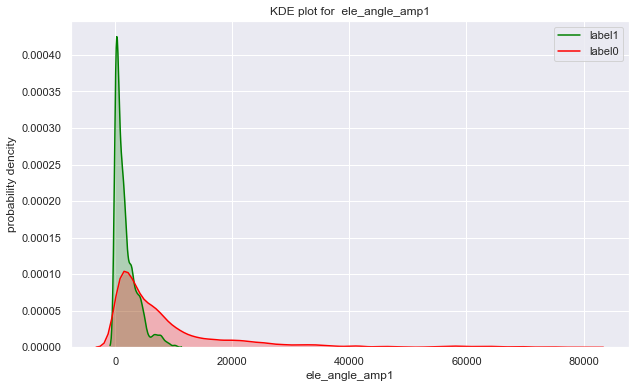

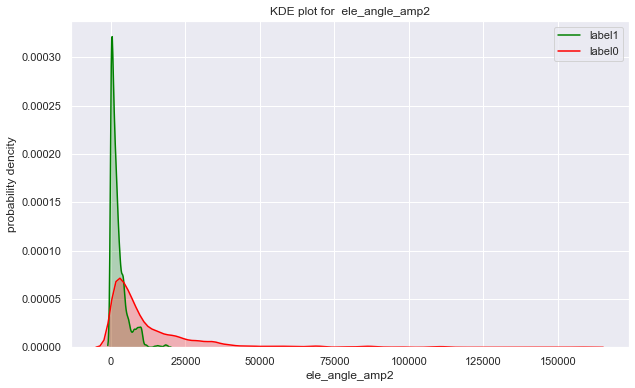

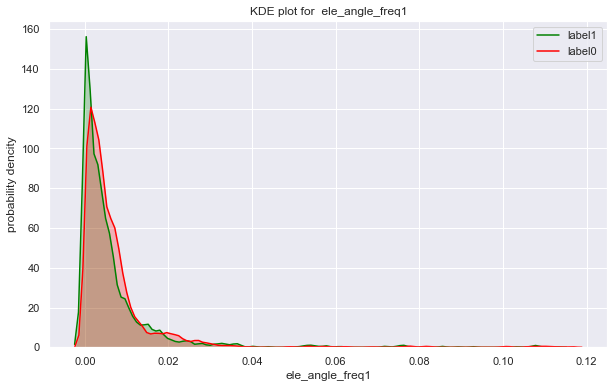

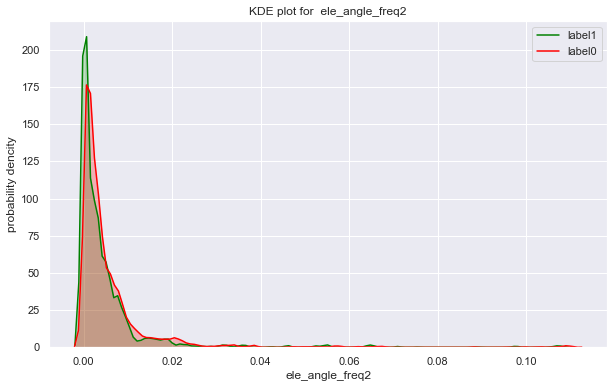

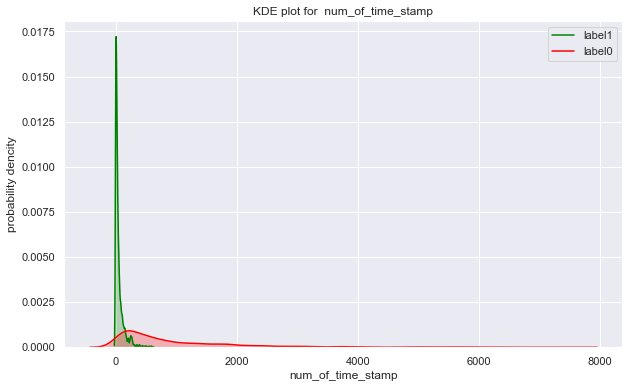

In [82]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

for i in column[0:-1]:
    sns.set(style="darkgrid")
    plt.figure(figsize = (10,6))
    sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
    sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

    plt.title('KDE plot for  ' + i)
    plt.xlabel(i)
    plt.ylabel('probability dencity')
    plt.show()

## Observation
* In above 51 distribution plot we can see that in each plot there are some amount of difference in distribution for class1 and class0 data.

## Extract features for online test data

In [86]:
def get_three_digit(num):
    '''
    given a one digit or 2 digit number, this function will return 3 digit string
    '''
    if num<10:
        return str('00')+str(num)
    else :
        return str('0')+str(num)
  
final_list = []
def get_test_data(folder_name):
    '''
    This function will prepare 10K test data points and lables
    '''
    
    list_of_files = os.listdir(folder_name)
    for i in tqdm(range(10000)): # we will try get aroung 100 pairs 
    
        r1 = get_three_digit(random.randint(1,12)) # random integer between [1-12]
        r2 = get_three_digit(random.randint(1,5))
        temp = []                               # temp is list of two number 1st is random integer between [1-12]
        temp.append(int(r1))                    # and second is random integer between [21-51]
        temp.append(random.randint(21,51))
        r3 = get_three_digit(temp[random.randint(0,1)])
        r4 = get_three_digit(random.randint(1,5))


        file1 = 'NISDCC-'+r1+'_'+r1+'_'+r2+'.hwr'
        file2 = 'NISDCC-'+r3+'_'+r1+'_'+r4+'.hwr'
   
        if (file1 in list_of_files) and (file2 in list_of_files): # this is to make sure that file1 and file2 is in list_of_files
            
            data1 = np.loadtxt(folder_name + file1,skiprows=1)
            temp1 = data1[np.logical_not(data1[:,4] > 900)] #remove all the rows for which azimuth angle > 900
            data_with_removed_outlier1 = temp1[np.logical_not(temp1[:,3] > 3600)] # remove all the rows for which elevation angle > 3600
 
            data2 = np.loadtxt(folder_name + file2,skiprows=1)
            temp2 = data2[np.logical_not(data2[:,4] > 900)] #remove all the rows for which azimuth angle > 900
            data_with_removed_outlier2 = temp2[np.logical_not(temp2[:,3] > 3600)] # remove all the rows for which elevation angle > 3600
               
            feature_list = []
            for i in range(5):
                # raw features : x_pos , y_pos , pen_presssure, azimuth_angle, elevation_angle
                # calculate simple features for all five raw features 
                feature_list.append(abs(mean(data_with_removed_outlier1[:,i]) - mean(data_with_removed_outlier2[:,i])))
                feature_list.append(abs(stdev(data_with_removed_outlier1[:,i]) - stdev(data_with_removed_outlier2[:,i])))
                feature_list.append(abs(max(data_with_removed_outlier1[:,i]) - max(data_with_removed_outlier2[:,i])))
                feature_list.append(abs(min(data_with_removed_outlier1[:,i]) - min(data_with_removed_outlier2[:,i])))
                feature_list.append(abs(kurtosis(data_with_removed_outlier1[:,i]) - kurtosis(data_with_removed_outlier2[:,i])))
                feature_list.append(abs(skew(data_with_removed_outlier1[:,i]) - skew(data_with_removed_outlier2[:,i])))
                
                # calculate top two freq and corresponding amplitude for all five raw feature
                signals1 = data_with_removed_outlier1[:,i]
                fft_amp1 = np.fft.fft(signals1)
                freq1 = np.fft.fftfreq(len(signals1),1)
                fft_amp1 = abs(fft_amp1)[:(len(fft_amp1)//2)]
                freq1 = freq1[:len(freq1)//2]
                temp11 = np.argsort(fft_amp1)
                temp12 = temp11[-3:-1]
                top_two_amp1 = fft_amp1[temp12]
                top_two_freq1 = freq1[temp12]
                
                signals2 = data_with_removed_outlier2[:,i]
                fft_amp2 = np.fft.fft(signals2)
                freq2 = np.fft.fftfreq(len(signals2),1)
                fft_amp2 = abs(fft_amp2)[:(len(fft_amp2)//2)]
                freq2 = freq2[:len(freq2)//2]
                temp21 = np.argsort(fft_amp2)
                temp22 = temp21[-3:-1]
                top_two_amp2 = fft_amp2[temp22]
                top_two_freq2 = freq2[temp22]
                
                
                feature_list.extend(abs(np.array(top_two_amp1) - np.array(top_two_amp2)))
                feature_list.extend(abs(np.array(top_two_freq1) - np.array(top_two_freq2)))
            
            if int(r3) in range(1,13): # r3 in [1-12]  implies pair of genuine signature 
                label = 1
            else :
                label = 0
            
            feature_list.append(abs(len(data_with_removed_outlier1) - len(data_with_removed_outlier2)))
            feature_list.append(label)
            final_list.append(feature_list)
            
    

In [87]:
folder_name = 'SigComp2009-training/NISDCC-online-all-001-051/'
get_test_data(folder_name)

column = ['x_pos_mean','x_pos_stdev','x_pos_max','x_pos_min','x_pos_kurtosis','x_pos_skew','x_pos_amp1','x_pos_amp2','x_pos_freq1','x_pos_freq2'
          ,'y_pos_mean','y_pos_stdev','y_pos_max','y_pos_min','y_pos_kurtosis','y_pos_skew','y_pos_amp1','y_pos_amp2','y_pos_freq1','y_pos_freq2'
          ,'pen_pressure_mean','pen_pressure_stdev','pen_pressure_max','pen_pressure_min','pen_pressure_kurtosis','pen_pressure_skew','pen_pressure_amp1','pen_pressure_amp2','pen_pressure_freq1','pen_pressure_freq2'
          ,'azimuth_angle_mean','azimuth_angle_stdev','azimuth_angle_max','azimuth_angle_min','azimuth_angle_kurtosis','azimuth_angle_skew','azimuth_angle_amp1','azimuth_angle_amp2','azimuth_angle_freq1','azimuth_angle_freq2'
          ,'ele_agnle_mean','ele_agnle_stdev','ele_agnle_max','ele_agnle_min','ele_agnle_kurtosis','ele_agnle_skew','ele_angle_amp1','ele_angle_amp2','ele_angle_freq1','ele_angle_freq2','num_of_time_stamp','label']
test_df = pd.DataFrame(data = final_list,columns = column)
test_df.head(10)

x_pos_mean  x_pos_stdev  x_pos_max  x_pos_min  x_pos_kurtosis  x_pos_skew  \
0     0.000000     0.000000        0.0        0.0        0.000000    0.000000   
1  3860.125269   257.822831     3702.0     3804.0        1.623081    0.157089   
2  9582.393726    99.108689    10469.0     8581.0        2.175357    0.432354   
3   652.570512   263.457489     1674.0      124.0        0.101494    0.177513   
4   264.192746    27.120231      187.0      164.0        0.164425    0.072949   
5  7277.299504    97.763305     7881.0     7087.0        0.048523    0.054181   
6     0.000000     0.000000        0.0        0.0        0.000000    0.000000   
7  2824.291243   548.863456     2748.0     3395.0        0.493697    0.225523   
8  3724.948191   360.753905     2707.0     2870.0        0.014425    0.661080   
9  9619.760119    72.396744    10470.0     9799.0        0.294003    0.187096   

     x_pos_amp1    x_pos_amp2  x_pos_freq1  x_pos_freq2  ...  ele_agnle_max  \
0  0.000000e+00  0.000000e+00     0.000000     0.000000  ...            0.0   
1  7.505201e+04  7.230324e+04     0.000548     0.010563  ...           20.0   
2  3.008626e+04  3.103416e+04     0.006693     0.013196  ...           50.0   
3  3.121871e+04  1.890195e+04     0.000328     0.000164  ...           20.0   
4  9.156939e+03  1.949626e+04     0.000039     0.000019  ...           20.0   
5  2.587907e+04  1.230903e+05     0.002876     0.000011  ...           10.0   
6  0.000000e+00  0.000000e+00     0.000000     0.000000  ...            0.0   
7  1.627633e+05  4.005961e+05     0.000997     0.010226  ...           70.0   
8  1.111960e+06  4.130157e+06     0.000370     0.000300  ...            0.0   
9  3.871475e+06  7.627921e+06     0.001808     0.000904  ...          320.0   

   ele_agnle_min  ele_agnle_kurtosis  ele_agnle_skew  ele_angle_amp1  \
0            0.0            0.000000        0.000000        0.000000   
1          200.0            4.079401        1.934892    10355.571376   
2          190.0            4.967227        2.329568     3900.386290   
3           30.0            1.700954        0.760543      320.888023   
4           10.0            0.052907        0.185445      401.795360   
5            0.0            0.339320        0.068765      184.526029   
6            0.0            0.000000        0.000000        0.000000   
7          200.0            2.947223        1.975317    10343.319578   
8          300.0           25.590268        3.443919    43667.238336   
9          340.0            2.021083        0.775167   256575.300721   

   ele_angle_amp2  ele_angle_freq1  ele_angle_freq2  num_of_time_stamp  label  
0        0.000000         0.000000         0.000000                  0      1  
1    10172.026225         0.004452         0.009427                644      0  
2     5202.921366         0.002231         0.010850                226      0  
3     1273.641531         0.006577         0.000164                 46      1  
4     1661.040887         0.003570         0.000039                 14      1  
5       60.876559         0.005016         0.000022                 21      1  
6        0.000000         0.000000         0.000000                  0      1  
7    20080.579336         0.000997         0.010226                434      0  
8   102184.389868         0.001662         0.000831               2454      0  
9   256364.227306         0.003234         0.002711               6894      0  

[10 rows x 52 columns]

## Analysis of feature in test data

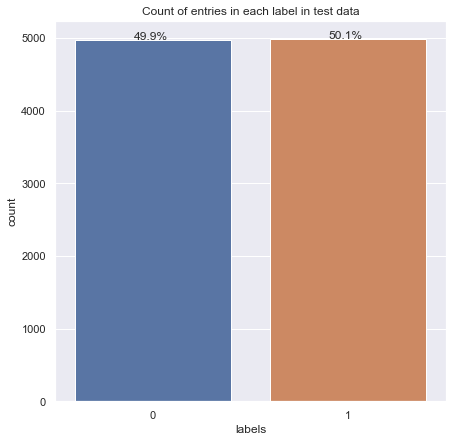

In [88]:
# reference : https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
sns.set(style="darkgrid")
plt.figure(figsize = (7,7))
ax = sns.countplot(x = "label", data = test_df, orient = 'V' )
plt.title('Count of entries in each label in test data')
plt.xlabel('labels')

total = len(test_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x,y))
plt.show()

We have prepared balanced test data

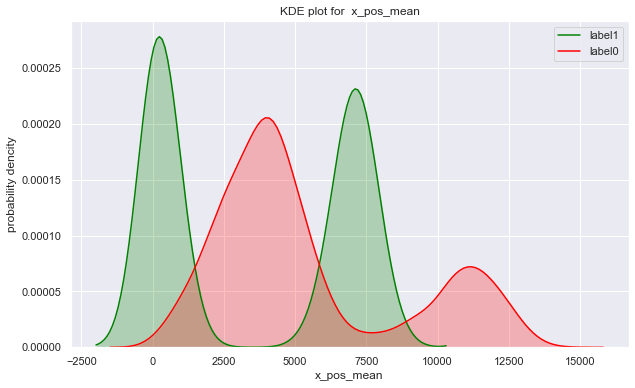

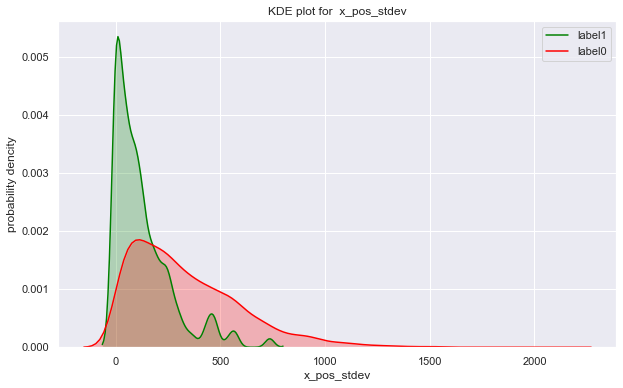

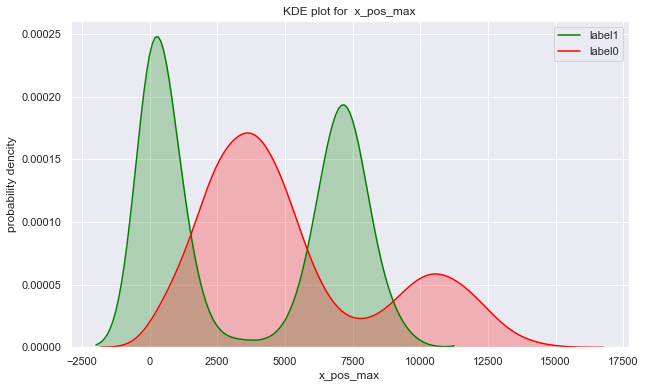

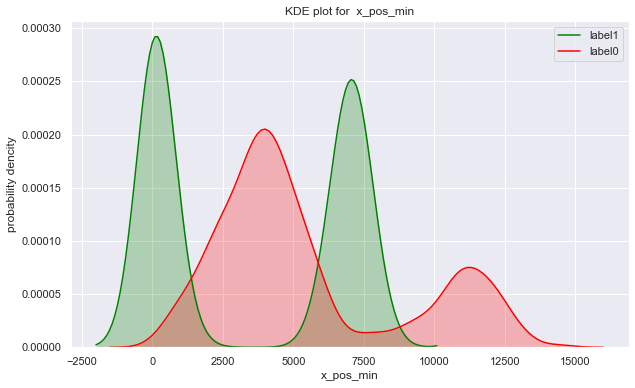

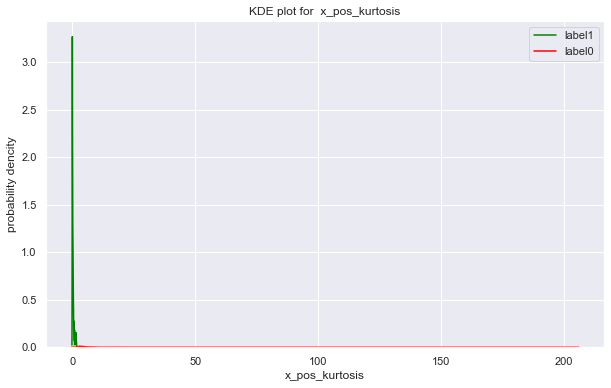

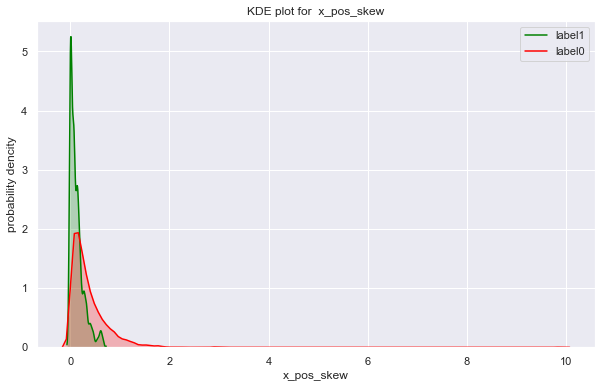

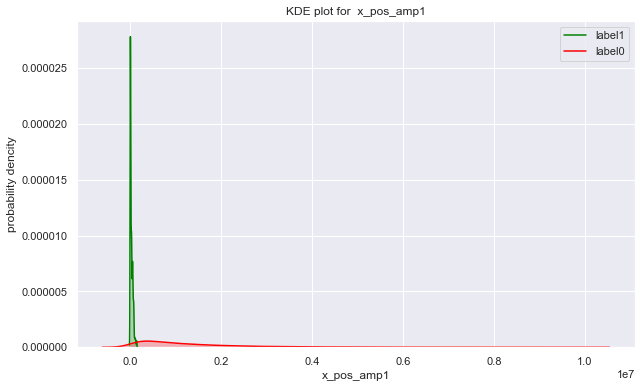

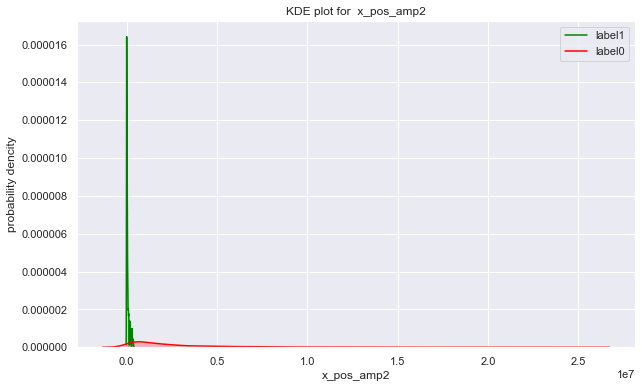

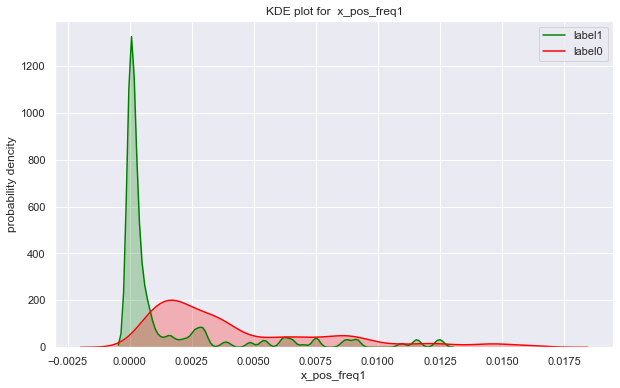

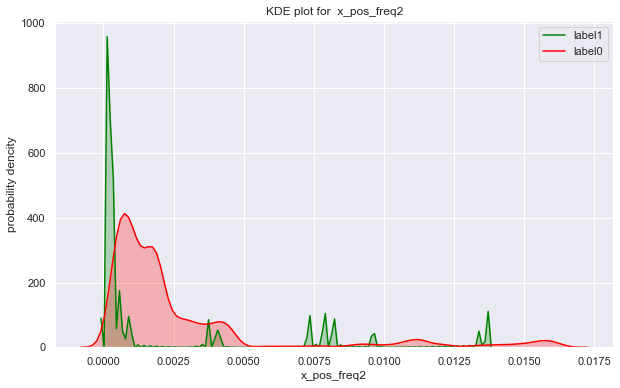

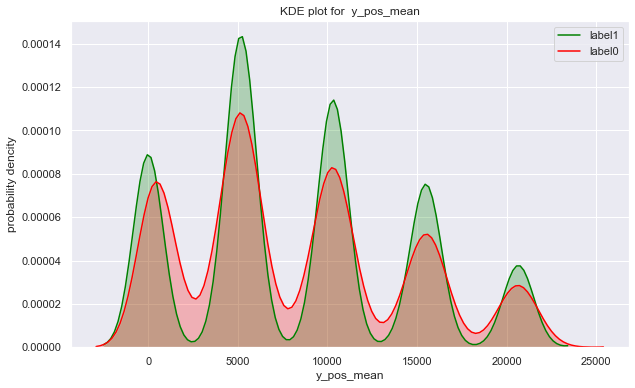

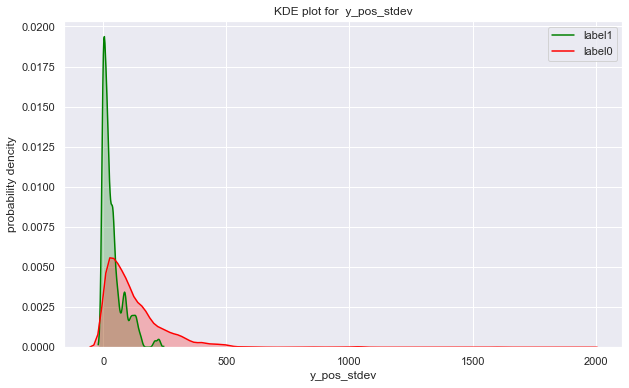

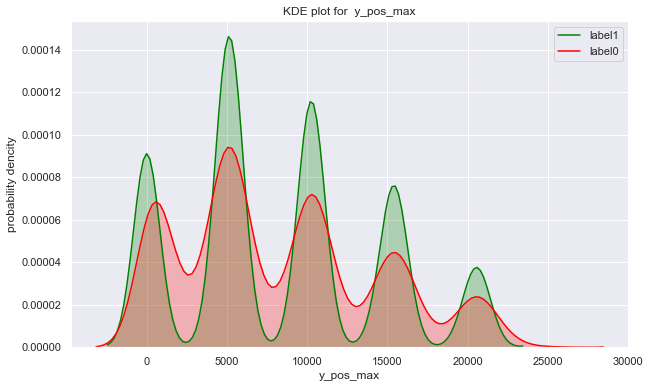

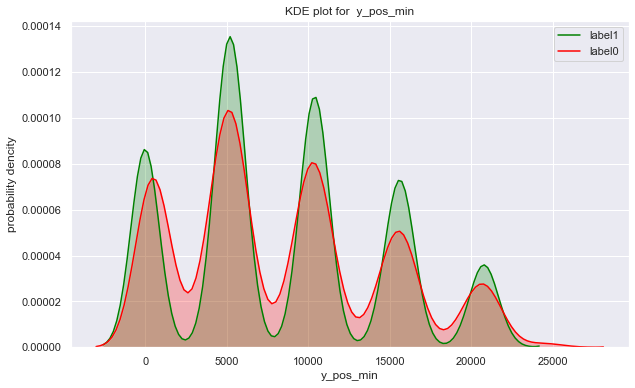

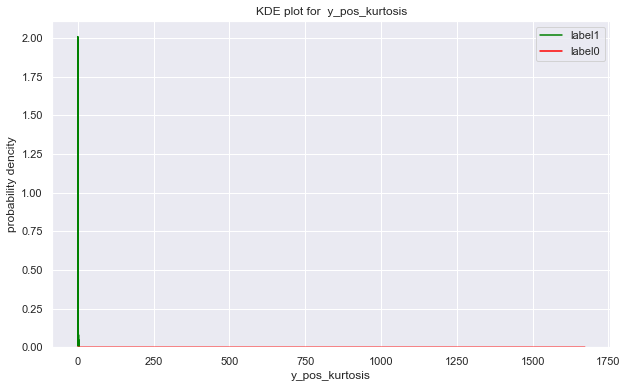

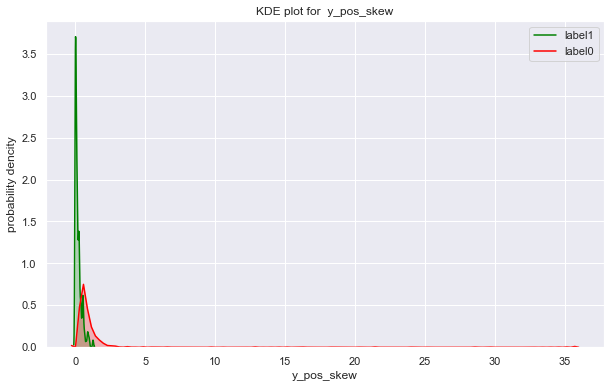

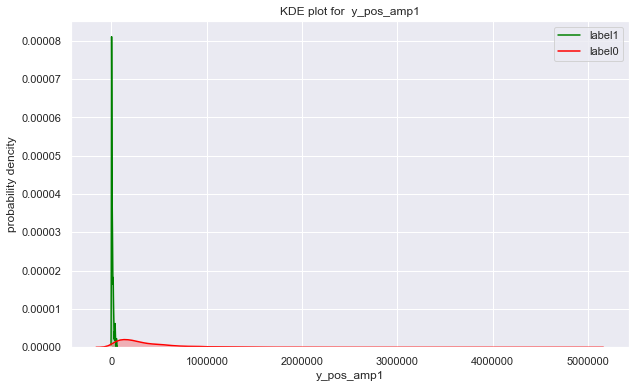

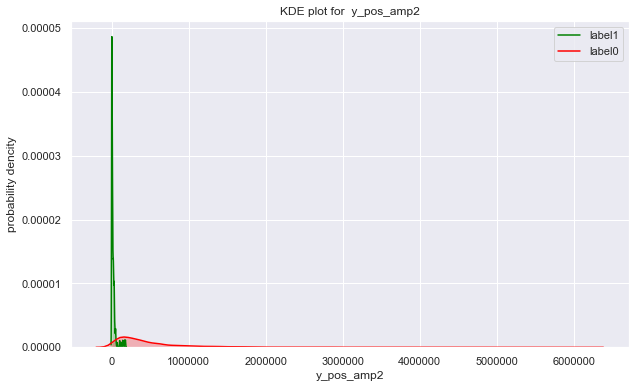

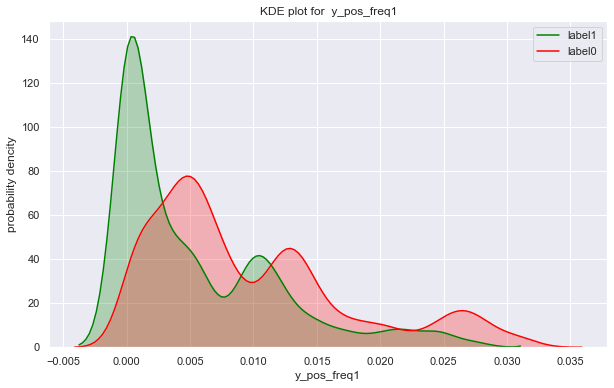

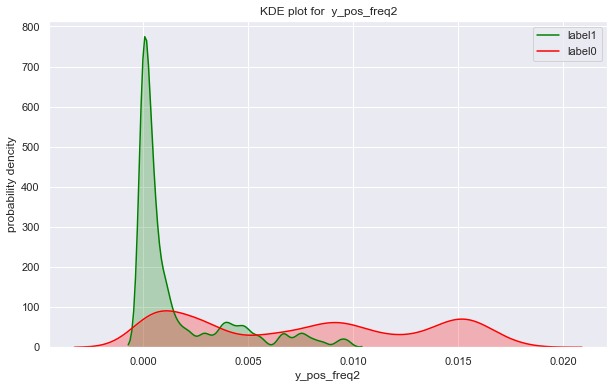

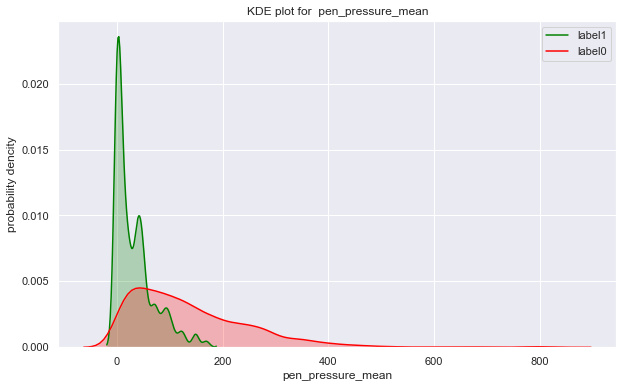

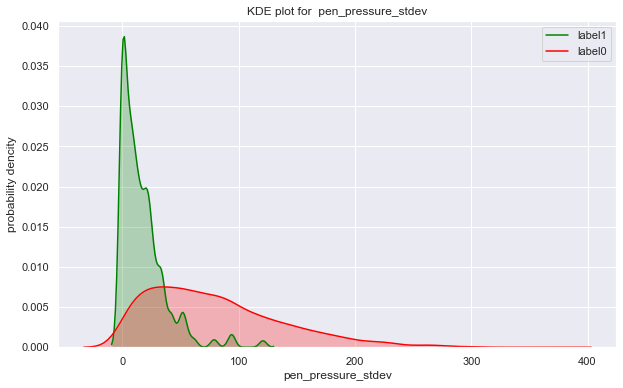

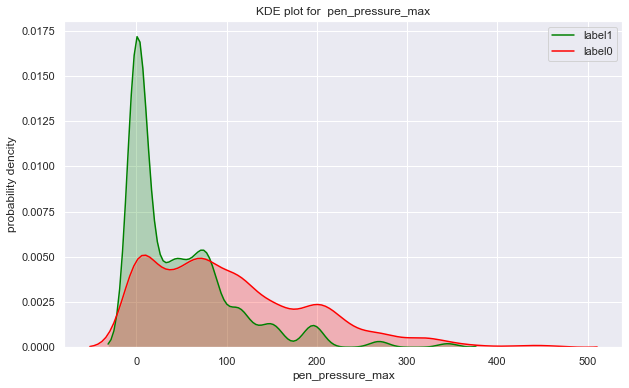

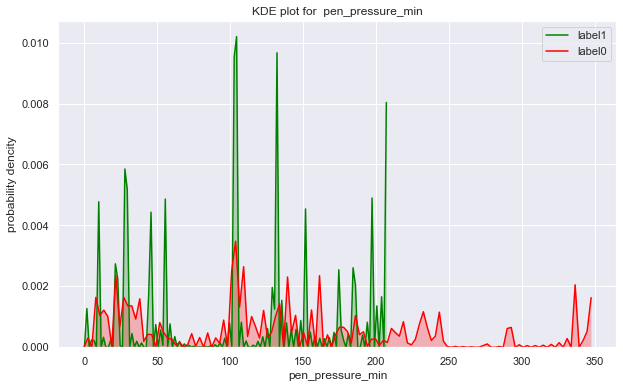

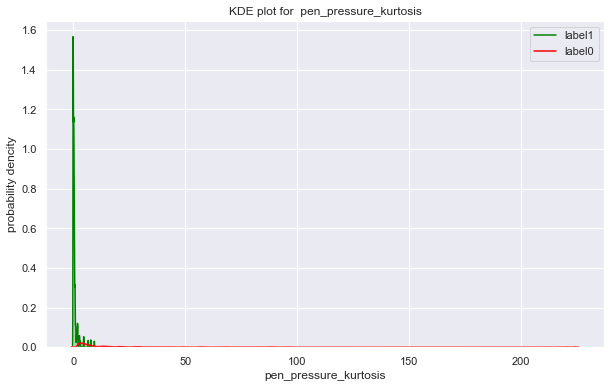

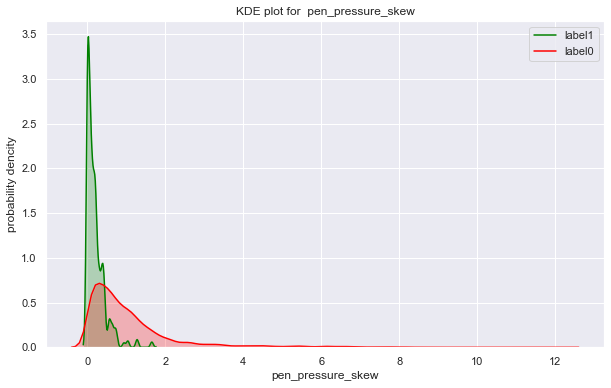

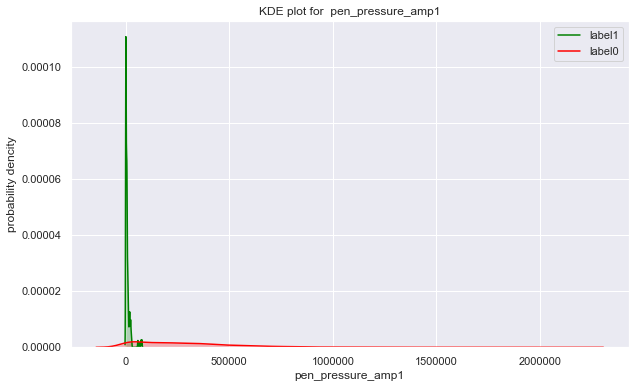

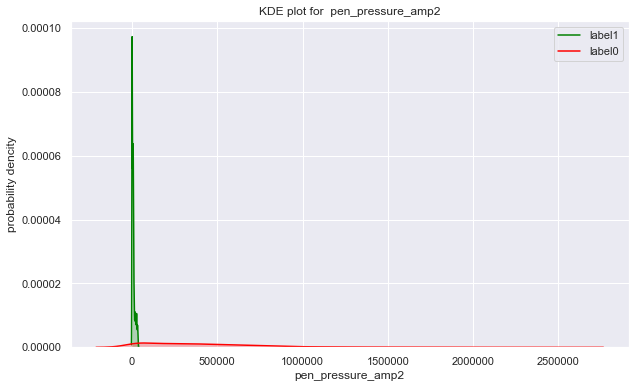

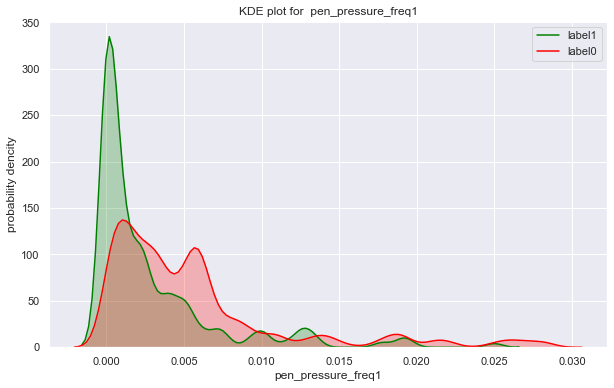

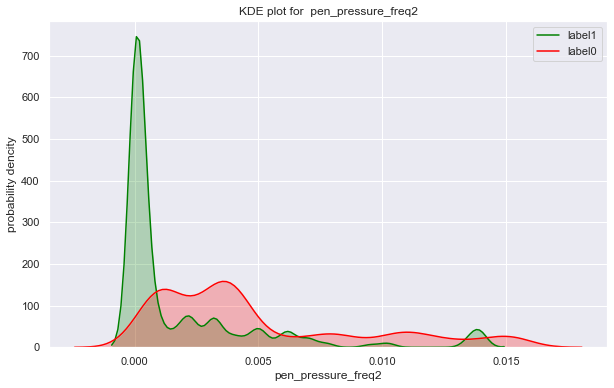

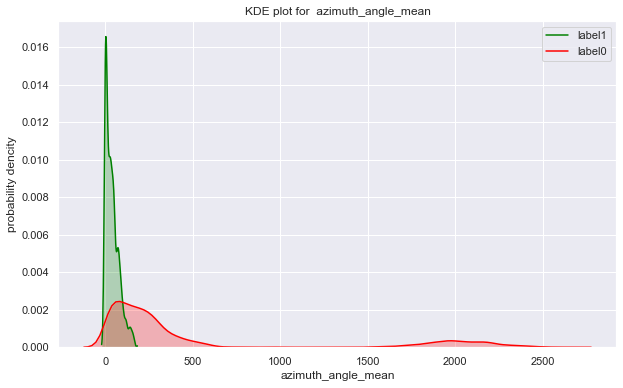

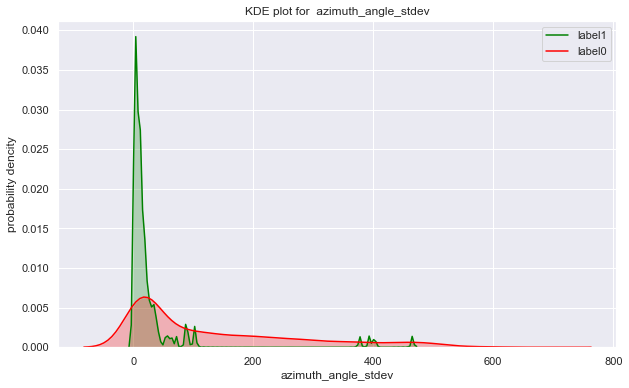

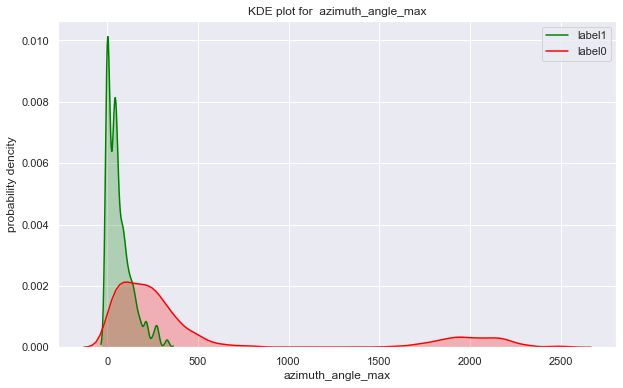

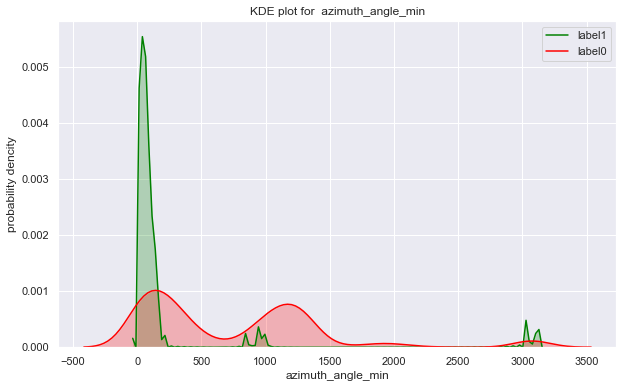

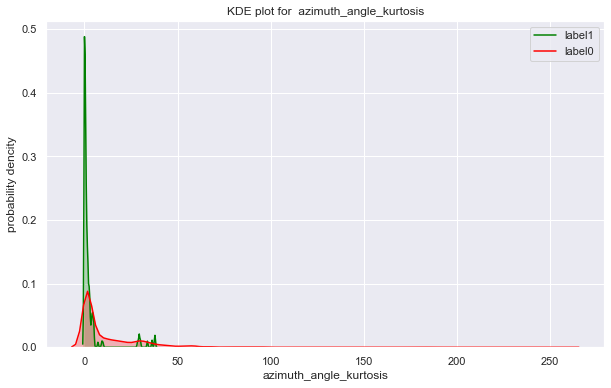

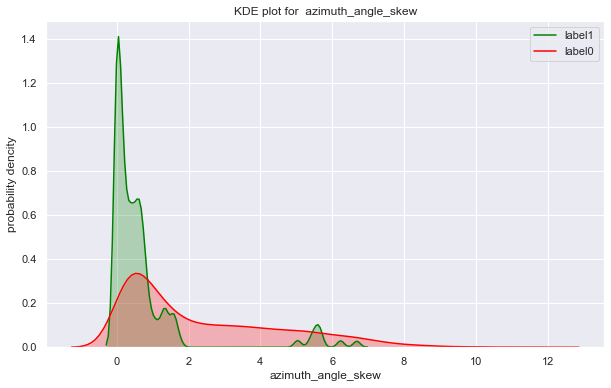

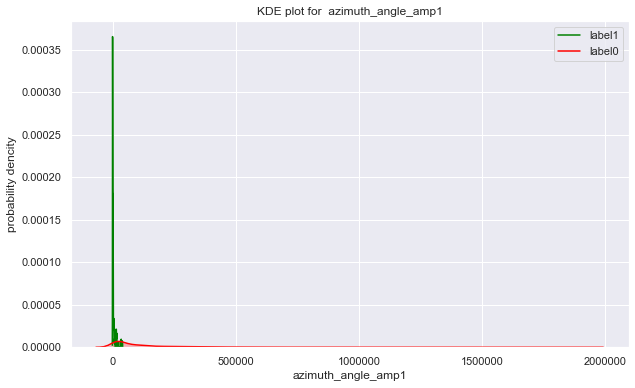

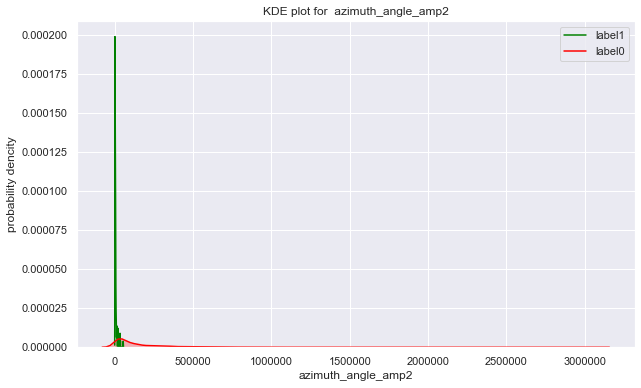

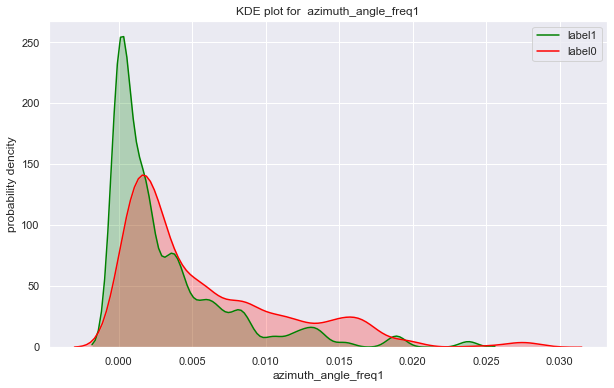

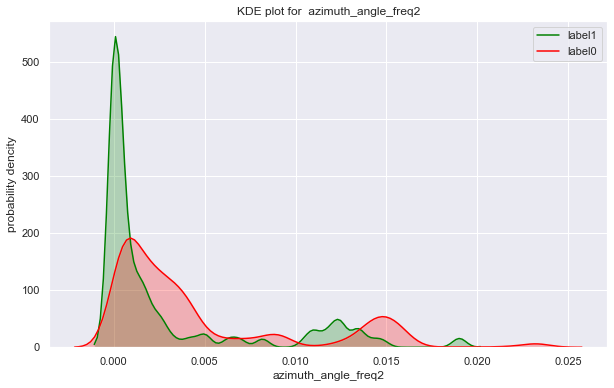

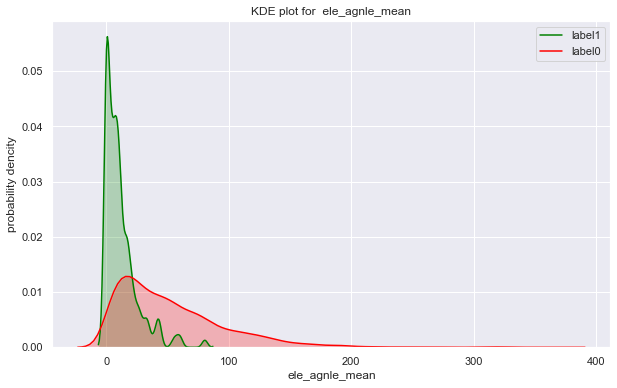

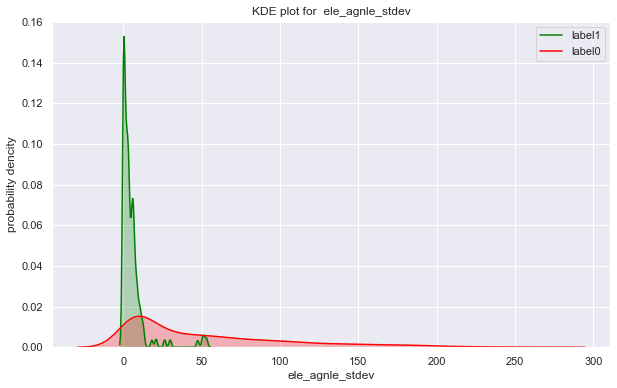

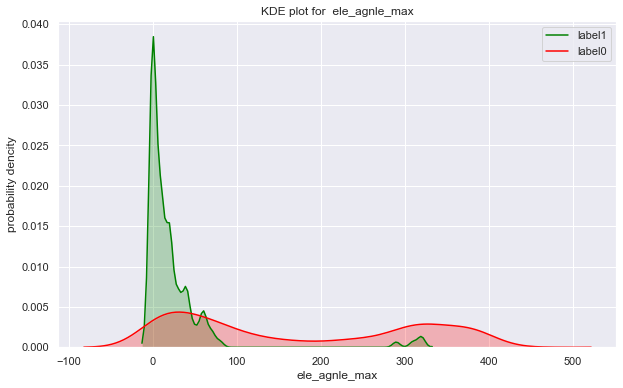

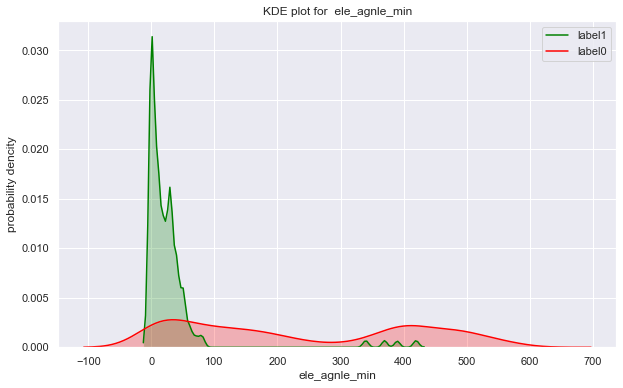

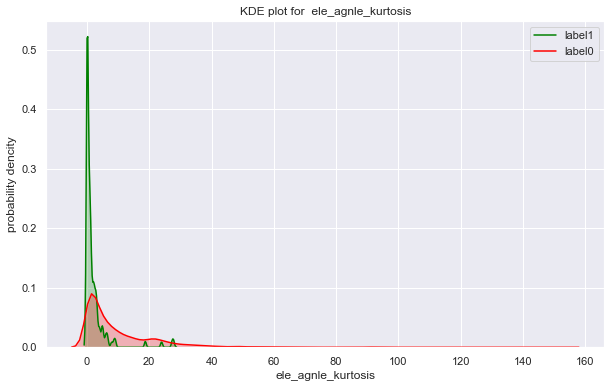

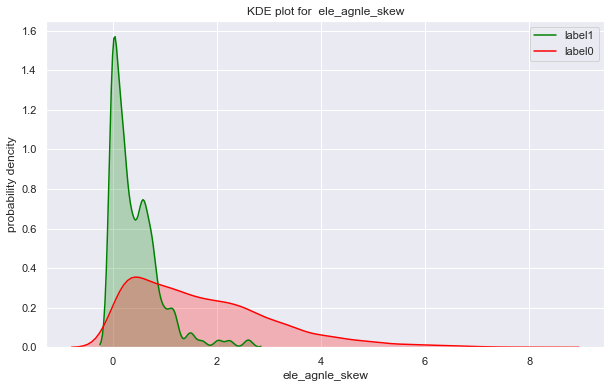

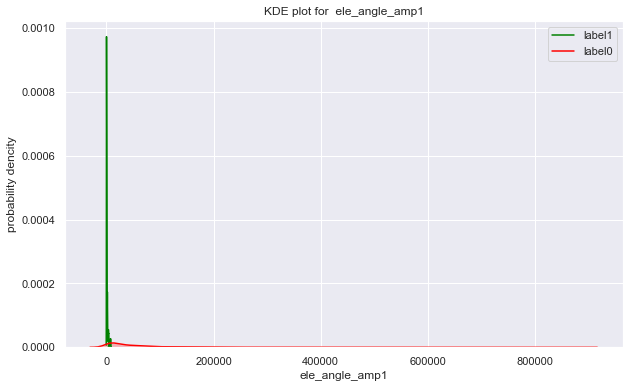

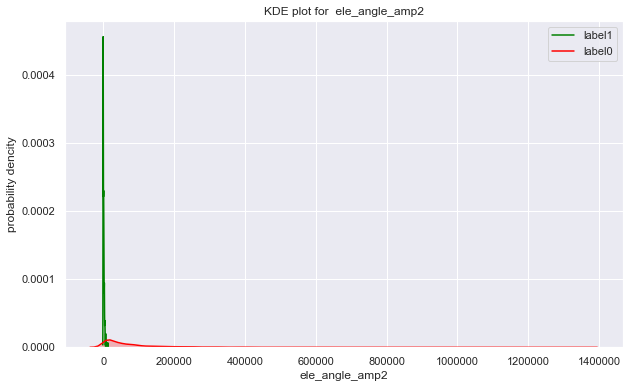

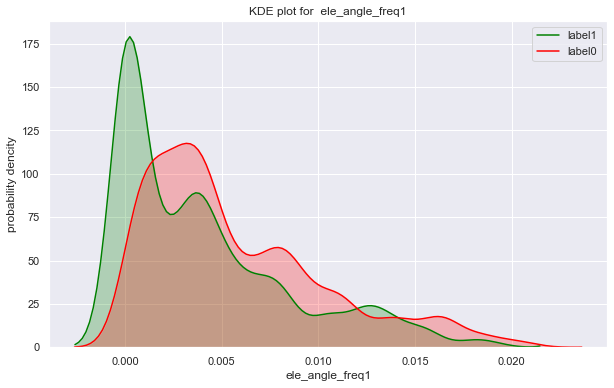

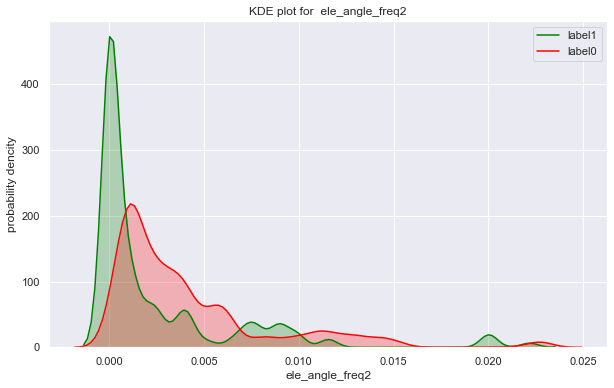

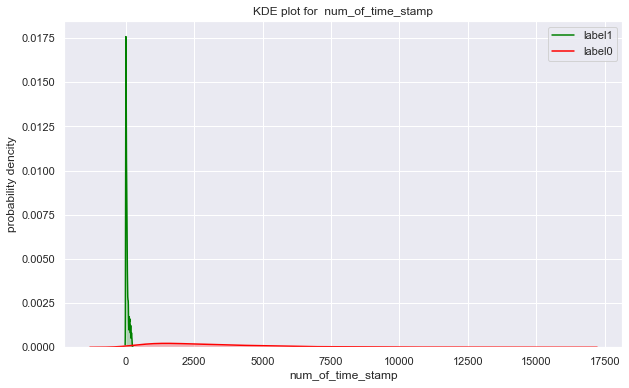

In [89]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

for i in column[0:-1]:
    sns.set(style="darkgrid")
    plt.figure(figsize = (10,6))
    sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
    sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

    plt.title('KDE plot for  ' + i)
    plt.xlabel(i)
    plt.ylabel('probability dencity')
    plt.show()

## Observation
* In above 51 distribution plot we can see that in each plot there are some amount of difference in distribution for class1 and class0 data.

## Training and test data

In [162]:
# reference : Assignment 19 Malware detection Problem
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    '''
    This function plots confusion matrix, precision and recall matrix and 
    also prints the percentage of misclassification.
    '''
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    cmap=sns.light_palette("blue")
    # representing A in heatmap format
    print("-"*35, "Confusion matrix", "-"*35)
    plt.figure(figsize=(8,6))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*35, "Precision matrix", "-"*35)
    plt.figure(figsize=(8,6))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*35, "Recall matrix"    , "-"*35)
    plt.figure(figsize=(8,6))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

In [91]:
y_train = train_df['label'].values
X_train = train_df.drop(['label'],axis = 1).values
y_test = test_df['label'].values
X_test = test_df.drop(['label'],axis = 1).values

print('training data :',X_train.shape,y_train.shape)
print('test data :',X_test.shape,y_test.shape)

training data : (15000, 51) (15000,)
test data : (9965, 51) (9965,)


# Decision Tree Model

In [114]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

start = time.time()
params = {'criterion' :['gini', 'entropy'],
          'min_samples_split':[2,3,4,5,6,7,8,9],
          'min_samples_leaf':[5,6,7],
          'max_depth':[2,3,4,5,6,7,8,9,12,15],
          'max_features':['auto', 'sqrt', 'log2', None]}

model  = DecisionTreeClassifier(class_weight='balanced')
grid = RandomizedSearchCV(model, param_distributions=params, scoring = 'f1_micro', \
                    n_jobs=-1,cv=5,return_train_score=True)          

grid.fit(X_train,y_train)
print('time taken to train the model in hours:',(time.time() - start)/3600)

time taken to train the model in hours: 0.0002621324857076009


In [115]:
grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Number of misclassified points  7.877571500250878
----------------------------------- Confusion matrix -----------------------------------


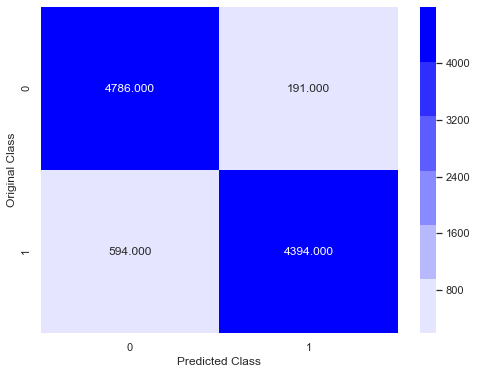

----------------------------------- Precision matrix -----------------------------------


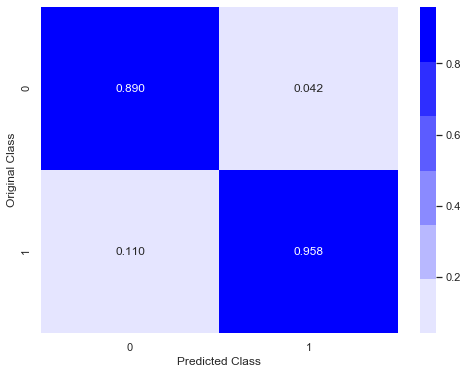

Sum of columns in precision matrix [1. 1.]
----------------------------------- Recall matrix -----------------------------------


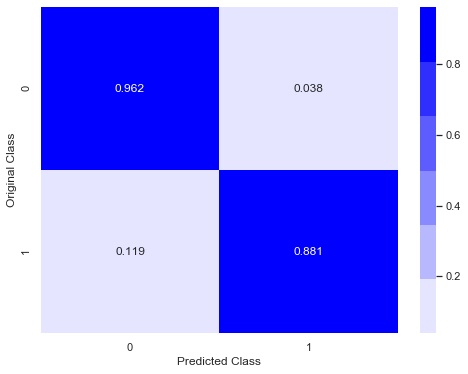

Sum of rows in precision matrix [1. 1.]
f1 score for training data : 0.9741333333333333
f1 score for test data : 0.9212242849974912


In [116]:
model = grid.best_estimator_
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_confusion_matrix(y_test,y_test_pred)

from sklearn.metrics import f1_score
print('='*100)
print('f1 score for training data :',f1_score(y_train, y_train_pred , average='micro'))
print('f1 score for test data :',f1_score(y_test,y_test_pred , average='micro'))

## Observation
* Using Decision Tree Classifier we achieved 0.92 f1 score for test data with 7.87% misclassification. 

## Feature Importance

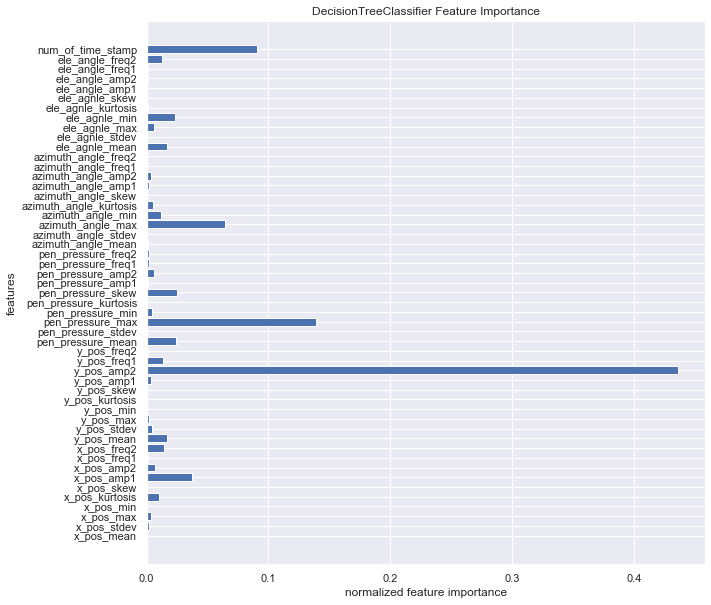

In [117]:
new_column = column[0:-1]
sns.set(style="darkgrid")
plt.figure(figsize = (10,10))
plt.barh(y=new_column,width = model.feature_importances_)
plt.title('DecisionTreeClassifier Feature Importance')
plt.xlabel('normalized feature importance')
plt.ylabel('features')
plt.show()

## Observation
* Most of the features are not very usefull for Decision tree classifier.

## Calculate EER (Equal Error Rate)

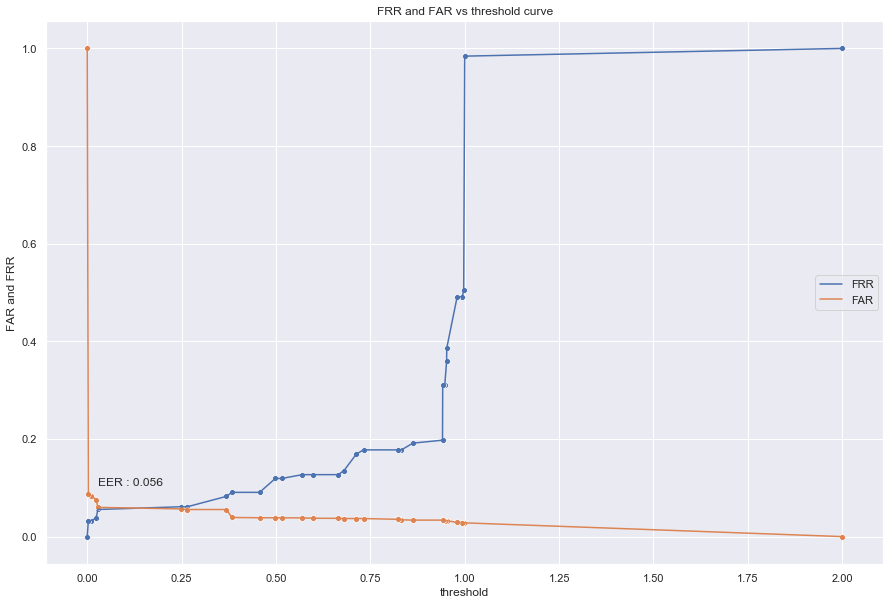

In [152]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

DT_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
DT_probs = DT_probs[:, 1]
DT_auc = roc_auc_score(y_test, DT_probs)
# calculate roc curves
DT_fpr, DT_tpr, threshold = roc_curve(y_test, DT_probs)
FAR = DT_fpr     # false accepatce rate is same as false positive rate
FRR = 1- DT_tpr  # false rejection rate is 1-true_positive_rate

# Equal Error rate
EER = np.round(FRR[np.argmin(abs(FAR-FRR))],decimals=3)

sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
ax = sns.scatterplot(threshold, FRR)
ax1 = sns.lineplot(threshold, FRR,label = 'FRR')

ay = sns.scatterplot(threshold, FAR)
ay1 = sns.lineplot(threshold, FAR,label = 'FAR')

idx = np.argmin(abs(FAR-FRR))
x = threshold[idx]
y = FRR[idx] + 0.05

ax.annotate('EER : {}'.format(EER),(x,y))

plt.title('FRR and FAR vs threshold curve')
plt.xlabel('threshold')
plt.ylabel('FAR and FRR')
plt.legend()

plt.show()

### Equal Error Rate = 5.6 % is achieved with Decision Tree Classifier.

# XgbClassifier

In [8]:
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb

start = time.time()
params = {'max_depth':[5,6,7,9,11,13],
          'min_child_weight':[0.0001,0.001,0.01,0.1,1],
          'n_estimators':[50,100,200,500,600,700,800,900,1000]}


from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]

    
model  = xgb.XGBClassifier(booster='gbtree')
grid = RandomizedSearchCV(model, param_distributions=params, scoring = 'f1_micro', \
                    n_jobs=-1,cv=5,return_train_score=True) 
                                                
grid.fit(X_train,y_train,sample_weight=w_array) 
print('time taken to train the model in sec:',time.time() - start)

time taken to train the model in sec: 816.3602669239044


In [9]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=0.01, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Number of misclassified points  3.1710988459608633
----------------------------------- Confusion matrix -----------------------------------


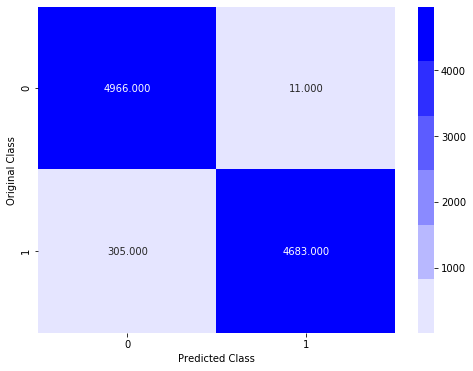

----------------------------------- Precision matrix -----------------------------------


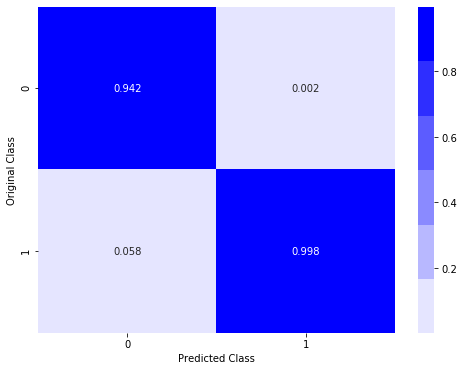

Sum of columns in precision matrix [1. 1.]
----------------------------------- Recall matrix -----------------------------------


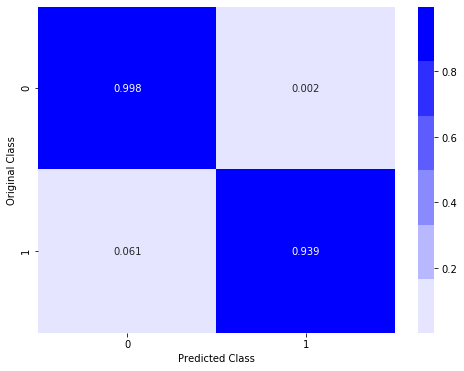

Sum of rows in precision matrix [1. 1.]
f1 score for training data : 1.0
f1 score for test data : 0.9682890115403914


In [12]:
model = grid.best_estimator_
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_confusion_matrix(y_test,y_test_pred)

from sklearn.metrics import f1_score
print('='*100)
print('f1 score for training data :',f1_score(y_train, y_train_pred , average='micro'))
print('f1 score for test data :',f1_score(y_test,y_test_pred , average='micro'))

## Observation
* Using XGBClassifier for online data we improved the model performance by achieving 0.968 f1 score for test data with only 3.17% misclassification. 

## Feature importance

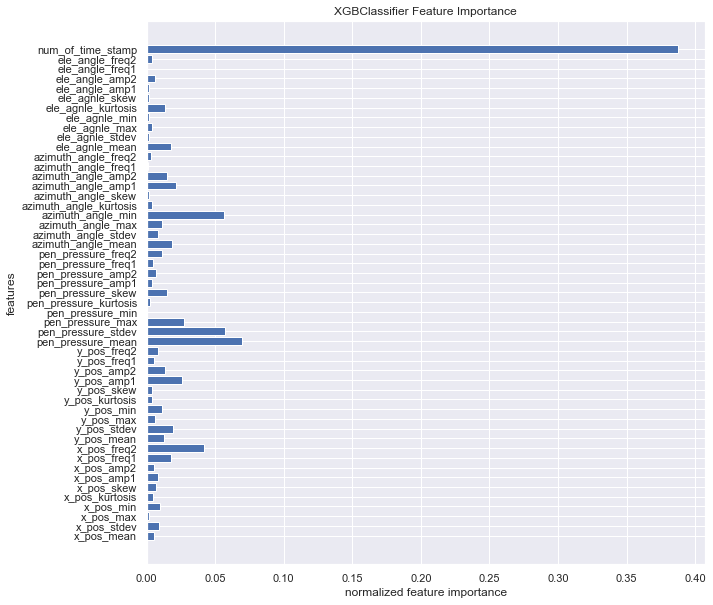

In [15]:
new_column = column[0:-1]
sns.set(style="darkgrid")
plt.figure(figsize = (10,10))
plt.barh(y=new_column,width = model.feature_importances_)
plt.title('XGBClassifier Feature Importance')
plt.xlabel('normalized feature importance')
plt.ylabel('features')
plt.show()

## Observation
* The feature 'number_time_stamp' is picked as most important feature for XGBClassifier.

## Calculate Equal Error Rate (EER)

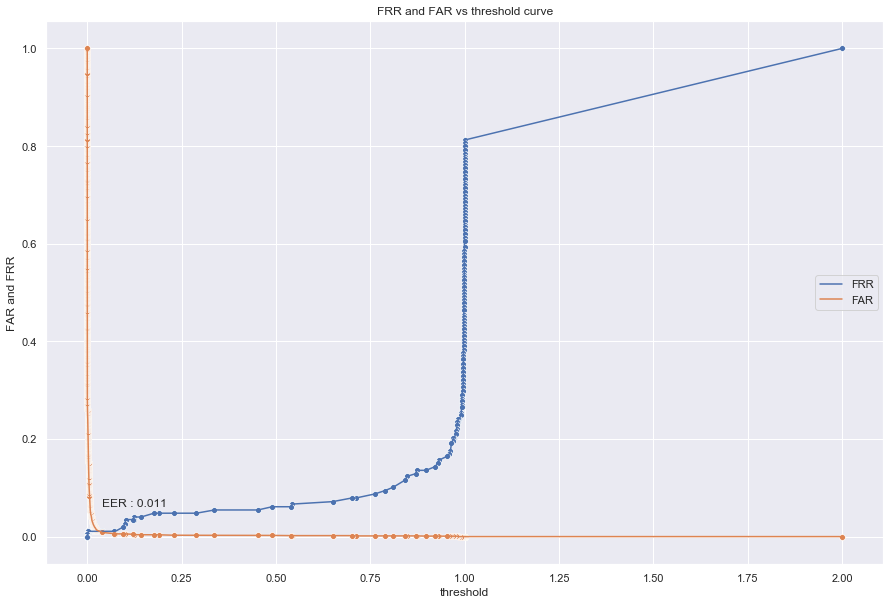

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

DT_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
DT_probs = DT_probs[:, 1]
DT_auc = roc_auc_score(y_test, DT_probs)
# calculate roc curves
DT_fpr, DT_tpr, threshold = roc_curve(y_test, DT_probs)
FAR = DT_fpr     # false accepatce rate is same as false positive rate
FRR = 1- DT_tpr  # false rejection rate is 1-true_positive_rate

# Equal Error rate
EER = np.round(FRR[np.argmin(abs(FAR-FRR))],decimals=3)

sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
ax = sns.scatterplot(threshold, FRR)
ax1 = sns.lineplot(threshold, FRR,label = 'FRR')

ay = sns.scatterplot(threshold, FAR)
ay1 = sns.lineplot(threshold, FAR,label = 'FAR')

idx = np.argmin(abs(FAR-FRR))
x = threshold[idx]
y = FRR[idx] + 0.05

ax.annotate('EER : {}'.format(EER),(x,y))

plt.title('FRR and FAR vs threshold curve')
plt.xlabel('threshold')
plt.ylabel('FAR and FRR')
plt.legend()

plt.show()

### EER = 1.1% is achieved using XGBClassifier.

## Steps to Prepare Offline Training and test data
Offline data is nothing but images of signature. We can either use convolution neural network based model or we can extract features from images and then train classification model. First we will extract features from images and built a classfication model and then we will use CNN based model.

In order to extract features from image data we will follow these steps.
* Prepare pairs of files where first file corresponds to genuine signature and second file corresponds to either genuine or forge signature.
* Prepare labels which is 1 if second file corresponds to genuine sign otherwise 0.


We will use multiple edge detection technique for which library is available in OpenCV module. The different edge detection technique that we will use are listed below:
* Harris corner
* Corner with subpixel accuracy
* Shi-Tomasi Corner Detector
* SIFT (Scale-Invariant Feature Transform)
* SURF (Speeded-Up Robust Features)
* FAST (Features from Accelerated Segment Test) 
* BRIEF (Binary Robust Independent Elementary Features)
* ORB (Oriented FAST and Rotated BRIEF)

 While extracting these features take the absolute difference of features calulated for pair. The intution is the diffence will be small for label 1 and large for label 0.

## Prepare Offline training and test data
### Offline training data

In [211]:
# In this cell we will prepare two lists which contains only useful file name for genuine and forge signature of evaluation data.
file_name_forge = os.listdir('SigComp2009-evaluation/forgeries')
file_name_genuine = os.listdir('SigComp2009-evaluation/genuines')
useful_forge_file = []
useful_genuine_file = []
l1= []
l2 = []
for i in range(len(file_name_forge)):
    if file_name_forge[i].endswith('png'):
        pattern = re.compile('NFI\-\d{6}(\d{2})\.png')
        grp = re.search(pattern, file_name_forge[i])
        l1.append(grp.group(1))
        useful_forge_file.append(file_name_forge[i]) # This is the list of file name of all the forge signature
                                                     # for which genuine signature is available

for i in range(len(file_name_genuine)):
    if file_name_genuine[i].endswith('png'):
        pattern = re.compile('NFI\-\d{6}(\d{2})\.png')
        grp = re.search(pattern, file_name_genuine[i])
        if grp.group(1) in l1:
            l2.append(grp.group(1))
            useful_genuine_file.append(file_name_genuine[i])# This is the list of file name of all the genuine signature
                                                     # for which forge signature is available
print('forge signature Ids and their counts')
print(np.unique(l1,return_counts = True))
print('='*100)
print('genuine signature Ids and their counts')
print(np.unique(l2,return_counts = True))

forge signature Ids and their counts
(array(['02', '08', '16', '18', '24', '33', '35', '44', '46', '63', '70',
       '71', '77', '84', '85', '86', '89', '92', '93'], dtype='<U2'), array([24, 36, 30, 24, 36, 36, 24, 36, 24, 36, 36, 30, 36, 36, 36, 36, 36,
       36, 36]))
genuine signature Ids and their counts
(array(['02', '08', '16', '18', '24', '33', '35', '44', '46', '63', '70',
       '71', '77', '84', '85', '86', '89', '92', '93'], dtype='<U2'), array([12, 12, 12,  6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12]))


In [212]:
train_input1_files = []
train_input2_files = []
label = []

genuine_folder  = 'SigComp2009-evaluation/genuines/'
forge_folder  = 'SigComp2009-evaluation/forgeries/'

for i in tqdm(range(15000)): # we will try to get 15000 traing data
    rand_input_1 = useful_genuine_file[random.randint(0,len(useful_genuine_file)-1)] # pick a random geuine signature file
    grp = re.search('NFI\-\d{6}(\d{2}\.png)',rand_input_1)
    grp.group(1) # this captures the extention of picked file
    list_of_input_2 = []
    list_of_input_2_genuine = [file for file in useful_genuine_file if file.endswith(grp.group(1))] # list of genuine signature with the same extention as picked file
    list_of_input_2_forge = [file for file in useful_forge_file if file.endswith(grp.group(1))]  # # list of forge signature with the same extention as picked file

    list_of_input_2.append(list_of_input_2_genuine[random.randint(0,len(list_of_input_2_genuine)-1)])
    list_of_input_2.append(list_of_input_2_forge[random.randint(0,len(list_of_input_2_forge)-1)])
    rx = random.randint(0,1)

    rand_input_2 = list_of_input_2[rx] 
    
    if rx==0:
        label.append(1)
    else:
        label.append(0)
    
    train_input1_files.append(rand_input_1)
    train_input2_files.append(rand_input_2)
    
print('number of 1st element of pair in training data :',len(train_input1_files))
print('number of 2st element of pair in training data :',len(train_input2_files))
print('number of training lable :',len(label))


number of 1st element of pair in training data : 15000
number of 2st element of pair in training data : 15000
number of training lable : 15000


In [ ]:
import cv2
import matplotlib.pyplot as plt

img1 = cv2.imread('SigComp2009-evaluation/genuines/'+file1)

img2 = cv2.imread('SigComp2009-evaluation/genuines/'+file2)


combi_one = cv2.merge((img1, img2))

titles = ["genuine ", 
          "query"]
images = [combi_one]

images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]   
grid_display(images, titles, 3, (10,10))

In [233]:
from PIL import Image  

def show_training_data(file1,file2,l):
    filename1 = 'SigComp2009-evaluation/genuines/'+file1
    if label == 1:
        filename2 = 'SigComp2009-evaluation/genuines/'+file2
    else:
        filename2 = 'SigComp2009-evaluation/forgeries/'+file2
        
    img1 = .open(filename1)
    
    img2 = Image.open(filename2)
    
    plt.figure(figsize = (5,5))
    imshow(img1)
    imshow(img2)
    print('label :',l)
    

In [234]:
show_training_data(train_input1_files[2],train_input2_files[2],label[2])

AttributeError: 'PngImageFile' object has no attribute 'dtype'

<Figure size 360x360 with 0 Axes>

In [230]:
label[2]

0

### Offline test data

In [54]:
def get_three_digit(num):
    '''
    given a one digit or 2 digit number, this function will return 3 digit string.
    '''
    if num<10:
        return str('00')+str(num)
    else :
        return str('0')+str(num)



test_input1_files = []    
test_input2_files = []
test_label = []
    
list_of_files = os.listdir('SigComp2009-training/NISDCC-offline-all-001-051-6g')
for i in tqdm(range(5000)): # we will try get aroung 100 pairs 
    

    r1 = get_three_digit(random.randint(1,12)) # random integer between [1-12]
    r2 = get_three_digit(random.randint(1,5))
    temp = []                               # temp is list of two number 1st is random integer between [1-12]
    temp.append(int(r1))                    # and second is random integer between [21-51]
    temp.append(random.randint(21,51))
    r3 = get_three_digit(temp[random.randint(0,1)])
    r4 = get_three_digit(random.randint(1,5))


    file1 = 'NISDCC-'+r1+'_'+r1+'_'+r2+'_6g.PNG'
    file2 = 'NISDCC-'+r3+'_'+r1+'_'+r4+'_6g.PNG'
    
    if (file1 in list_of_files) and (file2 in list_of_files):
        if int(r3) in range(1,13): # r3 in [1-12]  implies pair of genuine signature 
            test_label.append(1)
        else :
            test_label.append(0)

        test_input1_files.append(file1)
        test_input2_files.append(file2)
    
print('number of 1st element of pair in test data :',len(test_input1_files))
print('number of 2st element of pair in test data :',len(test_input2_files))
print('number of test lable :',len(test_label))


number of 1st element of pair in test data : 4971
number of 2st element of pair in test data : 4971
number of test lable : 4971


## Harris corner
Corner is the section of image where change in intensity is high. Harris corner detection technique uses this simple theory to extract the corners from the image. In mathematical point of view first we calculate a intensity function and then estimate the corner by solving the optimization problem which is writen below.

<img src='harris_equ.png'  width="600" height="600" >

To get detail knowledge please refer this link.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

### Prepare training data for feature : counts of harris corner in image

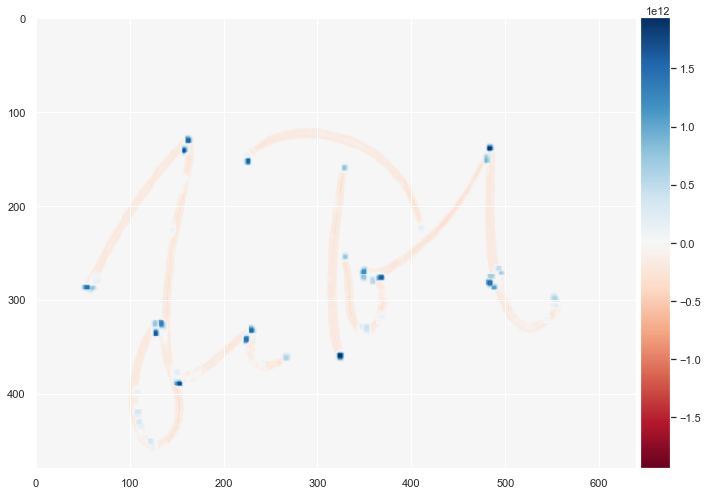

In [210]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

filename = 'SigComp2009-evaluation/genuines/NFI-01210012.png'
size = (480,640)   
#filename = folder_name + file
img = cv2.imread(filename)
img = imresize(img, size=size, interp='bilinear')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,7,7,0.04)
dst = cv2.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]
g1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
im_bw = cv2.threshold(g1,76, 255, cv2.THRESH_BINARY)[1]
#cv2.imshow('dst',img)
#if cv2.waitKey(0) & 0xff == 27:
#    cv2.destroyAllWindows()
plt.figure(figsize = (10,10))
imshow(dst)
plt.show()

* The blue dots in the image are the corners detected by the algorith.
* We will count the number of corners for both the images in pair and then get the absolute difference. The intution is that the difference will be small for genuine - genuine pair and large for genuine - forge pair. 

In [48]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def count_harris_corner(file,label,flag):
    '''
    This function returns the counts number of corner detected by harris corner detection technique for training data.
    '''
    if flag == 0:
        if label == 1:
            folder_name = 'SigComp2009-evaluation/genuines/'
        else:
            folder_name = 'SigComp2009-evaluation/forgeries/'
    else:
        folder_name = 'SigComp2009-evaluation/genuines/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,7,7,0.04)
    dst = cv2.dilate(dst,None)
    img[dst>0.01*dst.max()]=[0,0,255]
    g1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    im_bw = cv2.threshold(g1,76, 255, cv2.THRESH_BINARY)[1]
    counts_hc = np.unique(im_bw,return_counts = True)[1][0]
    return counts_hc
    

In [49]:
from tqdm.notebook import tqdm
train_hc = []
for i in tqdm(range(len(train_input1_files))):
    hc_input1 = count_harris_corner(train_input1_files[i],label[i],1)
    hc_input2 = count_harris_corner(train_input2_files[i],label[i],0)
    train_hc.append(abs(hc_input1-hc_input2))

In [50]:
train_df = pd.DataFrame(data = train_hc , columns = ['hc'])
train_df['label'] = label
train_df.head()

hc  label
0   3642      1
1  10016      1
2   2130      1
3   2062      0
4   5256      0

### Analysis the distribution of the feature : counts of harris corner

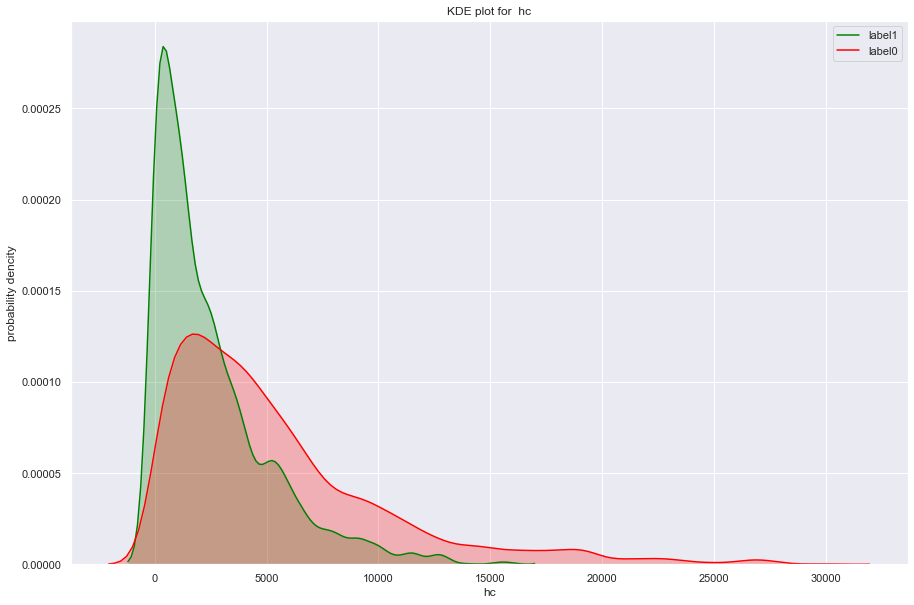

In [51]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'hc'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* As we expected the distribution for label 1 is shifted towards left and the distrbution are not completely overlapped so this feature might help for classificaton.

### Prepare test data for feature : counts of Harris corner in image

In [55]:
def count_harris_corner_test(file):
    '''
    This function returns the counts number of corner detected by harris corner detection technique for test data.
    '''

    folder_name = 'SigComp2009-training/NISDCC-offline-all-001-051-6g/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,7,7,0.04)
    dst = cv2.dilate(dst,None)
    img[dst>0.01*dst.max()]=[0,0,255]
    g1 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    im_bw = cv2.threshold(g1,76, 255, cv2.THRESH_BINARY)[1]
    counts_hc = np.unique(im_bw,return_counts = True)[1][0]
    return counts_hc

In [56]:
from tqdm.notebook import tqdm
test_hc = []
for i in tqdm(range(len(test_input1_files))):
    hc_input1 = count_harris_corner_test(test_input1_files[i])
    hc_input2 = count_harris_corner_test(test_input2_files[i])
    test_hc.append(abs(hc_input1-hc_input2))

In [57]:
test_df = pd.DataFrame(data = test_hc , columns = ['hc'])
test_df['label'] = test_label
test_df.head()

hc  label
0  1845      0
1   172      0
2   405      0
3   249      0
4   756      1

### Analysis the distribution of the feature(test data) : counts of harris corner

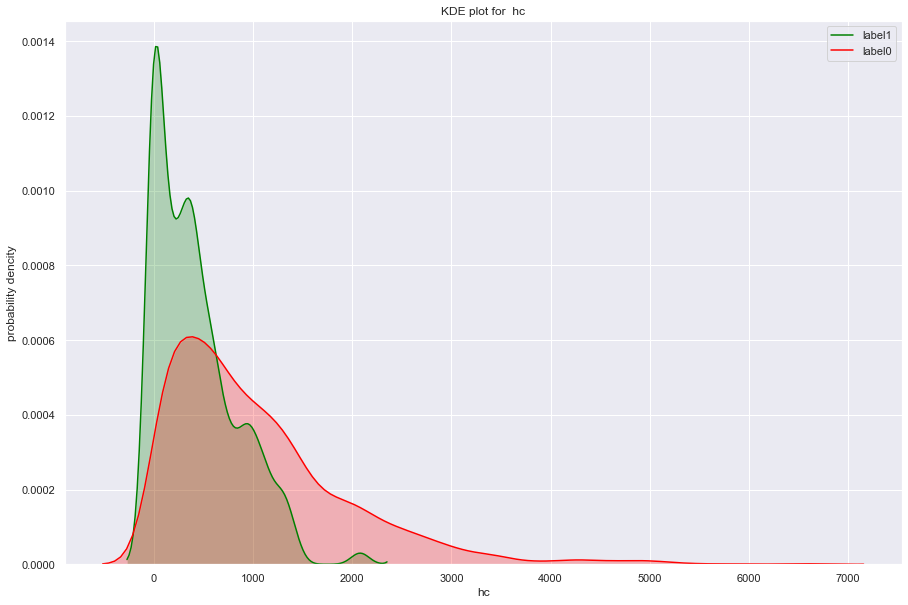

In [58]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'hc'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* We expect test data distribution should be similar as training data so the trained model should work well for test data.
* As expected test data disribution is similar to training data distribution.

## Corner with subpixel accuracy
Corner with subpixel accuracy is one step ahead of previous algorithm. In harris corner detection technique we got a bunch of pixels at a corner but sometime we want only one pixel with high accuracy. Basically cv2.cornerSubPix() returns the centroid of the bunch of the pixel at corner.

### Prepare training data for feature : corner with subpixel accuracy

In [60]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def corner_subpixel_accuracy(file,label,flag):
    '''
    This function returns corners with high accuracy for training data.
    '''
    if flag == 0:
        if label == 1:
            folder_name = 'SigComp2009-evaluation/genuines/'
        else:
            folder_name = 'SigComp2009-evaluation/forgeries/'
    else:
        folder_name = 'SigComp2009-evaluation/genuines/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,7,7,0.04)
    dst = cv2.dilate(dst,None)
    
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

    return corners

In [61]:
from tqdm.notebook import tqdm
train_hc_acc = []

for i in tqdm(range(len(train_input1_files))):
    hc_acc_input1 = corner_subpixel_accuracy(train_input1_files[i],label[i],1)
    hc_acc_input2 = corner_subpixel_accuracy(train_input2_files[i],label[i],0)
    train_hc_acc.append(abs(len(hc_acc_input1) - len(hc_acc_input2)))

In [62]:
train_df['hc_acc'] = train_hc_acc
train_df.head()

hc  label  hc_acc
0   3642      1      11
1  10016      1       1
2   2130      1      28
3   2062      0       0
4   5256      0       4

### Analysis the distribution of the feature : corner with subpixel accuracy

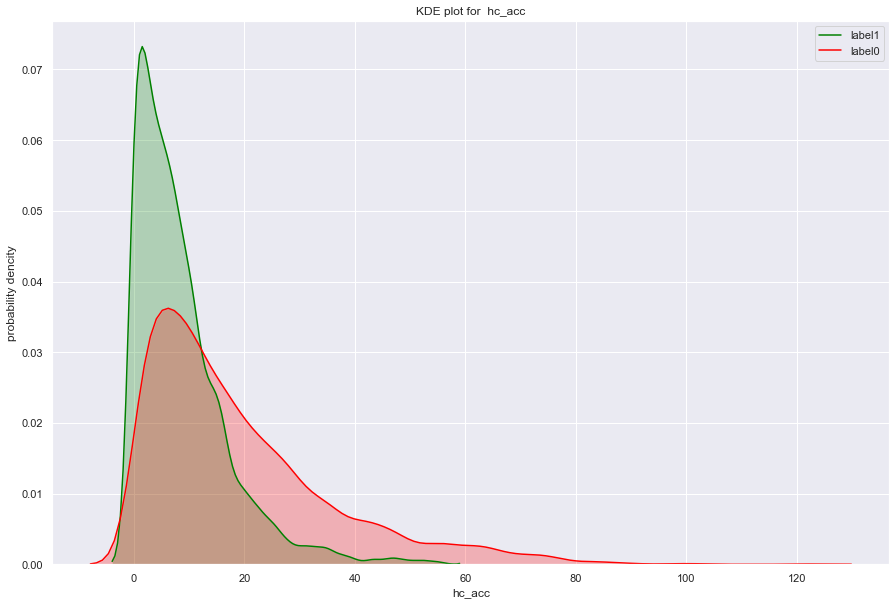

In [64]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'hc_acc'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label1 and label0 are not completely overlapped so this feture might useful for classification

### Prepare test data for feature : corner subpixel accuracy

In [65]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def corner_subpixel_accuracy_test(file):
    '''
    This function returns corners with subpixel accuracy for test data.
    '''
    folder_name = 'SigComp2009-training/NISDCC-offline-all-001-051-6g/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,7,7,0.04)
    dst = cv2.dilate(dst,None)
    
    ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
    dst = np.uint8(dst)

    # find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    # define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

    return corners

In [66]:
from tqdm.notebook import tqdm
test_hc_acc = []

for i in tqdm(range(len(test_input1_files))):
    hc_acc_input1 = corner_subpixel_accuracy_test(test_input1_files[i])
    hc_acc_input2 = corner_subpixel_accuracy_test(test_input2_files[i])
    test_hc_acc.append(abs(len(hc_acc_input1) - len(hc_acc_input2)))

In [67]:
test_df['hc_acc'] = test_hc_acc
test_df.head()

hc  label  hc_acc
0  1845      0       3
1   172      0      10
2   405      0       5
3   249      0      11
4   756      1       6

### Analysis the distribution of the feature(test data) : corner with subpixel accuracy

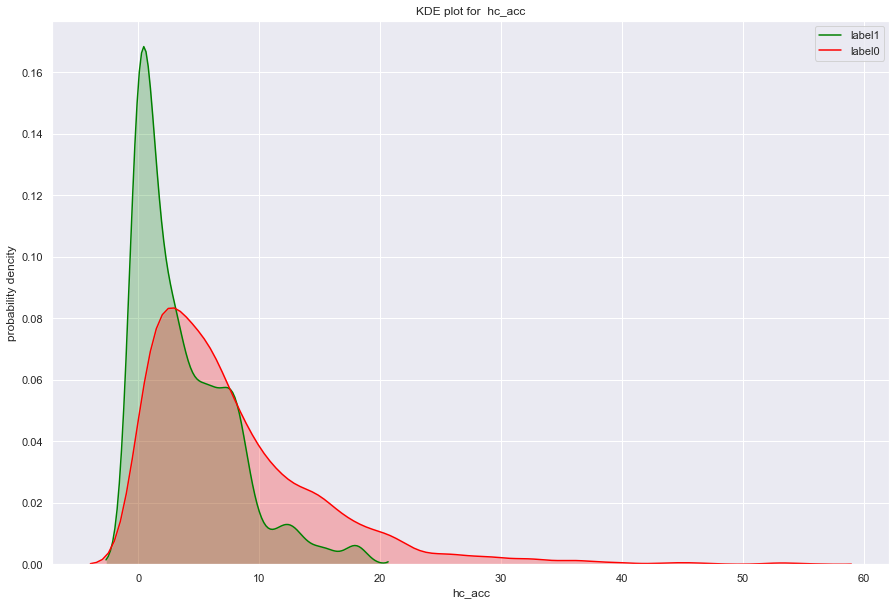

In [68]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'hc_acc'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* Test data distribution is similar as training data ditsribution.

## Shi-Tomasi Corner Detector

Shi-Tomasi Corner Detection technique is is very much similar as harris corner detection technique with one minor change. The scoring function in harris corner detection technique is 

$$ R = \lambda_1 \lambda_2 - k(\lambda_1 + \lambda_2)^2 $$

where The scoring function in Shi-Tomasi Corner Detection technique 

$$ R = min(\lambda_1,\lambda_2) $$

To know more about this technique please refer this link

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html

### Prepare training data for feature : Shi-Tomasi Corner Detector

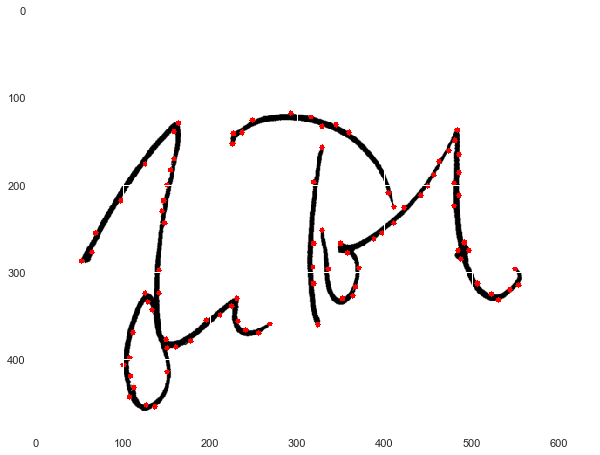

In [83]:
filename = 'SigComp2009-evaluation/genuines/NFI-01210012.png'
size = (480,640)   
img = cv2.imread(filename)
img = imresize(img, size=size, interp='bilinear')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,90,0.01,10)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(img,(x,y),3,255,-1)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

Red dots in the image is corners detected by the Shi-Tomasi corner dection technique.

In [70]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def Shi_Tomasi_Corner(file,label,flag):
    '''
    This function returns number of corner detected by Shi-Tomasi Corner Detector technique for training data.
    '''
    if flag == 0:
        if label == 1:
            folder_name = 'SigComp2009-evaluation/genuines/'
        else:
            folder_name = 'SigComp2009-evaluation/forgeries/'
    else:
        folder_name = 'SigComp2009-evaluation/genuines/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    corners = cv2.goodFeaturesToTrack(gray,90,0.01,10)
    corners = np.int0(corners)

    return corners

In [71]:
from tqdm.notebook import tqdm
train_Shi_Tomasi = []

for i in tqdm(range(len(train_input1_files))):
    corners1 = Shi_Tomasi_Corner(train_input1_files[i],label[i],1)
    corners2 = Shi_Tomasi_Corner(train_input2_files[i],label[i],0)
    train_Shi_Tomasi.append(np.linalg.norm(corners1-corners2))

In [72]:
train_df['Shi_Tomasi'] = train_Shi_Tomasi
train_df.head()

hc  label  hc_acc   Shi_Tomasi
0   3642      1      11  2345.686680
1  10016      1       1  2236.184474
2   2130      1      28  2007.849347
3   2062      0       0  2018.083001
4   5256      0       4  2262.874057

### Analusis of distribution of feature : counts of Shi-Tomasi corner

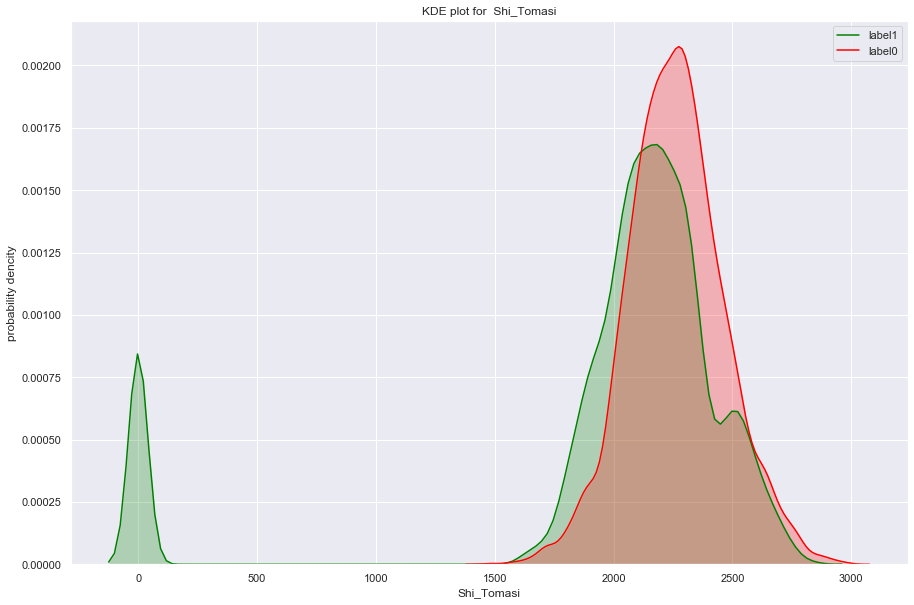

In [73]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'Shi_Tomasi'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation 
* Distribution for label 0 and label 1 not completely overlapped so this feature might help for classification.

### Prepare test data for feature : Shi-Tomasi Corner Detector

In [76]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def Shi_Tomasi_Corner_test(file):
    '''
    This function returns number of corner detected by Shi-Tomasi Corner Detector technique for test data.    
    '''
    folder_name = 'SigComp2009-training/NISDCC-offline-all-001-051-6g/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    corners = cv2.goodFeaturesToTrack(gray,70,0.01,10)
    corners = np.int0(corners)

    return corners

In [77]:
from tqdm.notebook import tqdm
test_Shi_Tomasi = []

for i in tqdm(range(len(test_input1_files))):
    corners1 = Shi_Tomasi_Corner_test(test_input1_files[i])
    corners2 = Shi_Tomasi_Corner_test(test_input2_files[i])
    test_Shi_Tomasi.append(np.linalg.norm(corners1-corners2))

In [78]:
test_df['Shi_Tomasi'] = test_Shi_Tomasi
test_df.head()

hc  label  hc_acc   Shi_Tomasi
0  1845      0       3  1869.285425
1   172      0      10  2154.085653
2   405      0       5  1951.912908
3   249      0      11  2043.453939
4   756      1       6  2150.571087

### Analysis of the distribution of feature(test data) : Shi-Tomasi corner

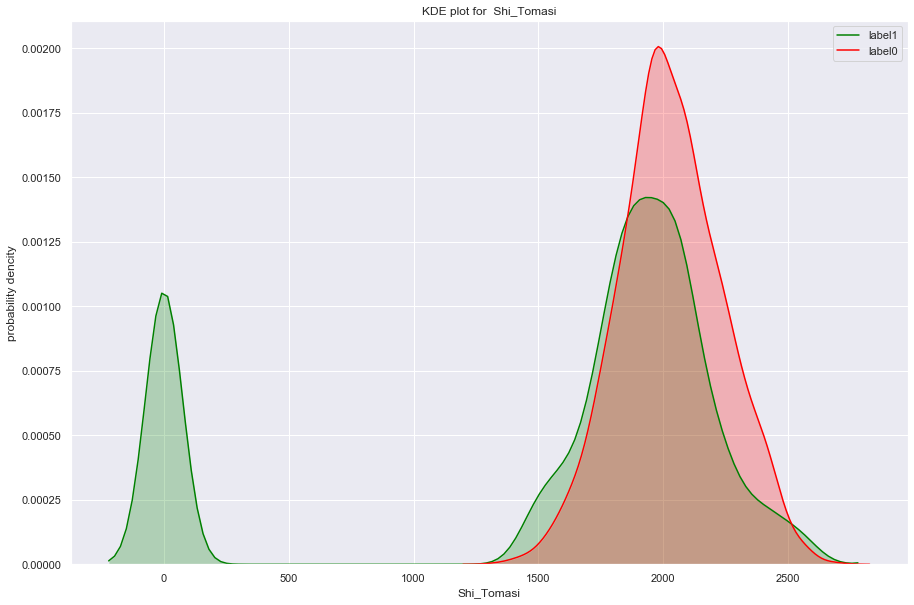

In [79]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'Shi_Tomasi'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* Distribution of test data is very much similar with the distribution of training data.

## SIFT (Scale-Invariant Feature Transform)
Previously we have harris and shi-tomasi corner detection technique which is rotation invarient but not scale invarient technique. Scale-Invariant Feature Transform technique is capable to to detect keypoints even when the size(scale) is not costant. There are mainly four steps involve in sift technique that is :
* Scale-space Extrema Detection
* Keypoint Localization
* Orientation Assignment
* Keypoint Descriptor

To get detailed knowledge about sift technique please refer this link

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html

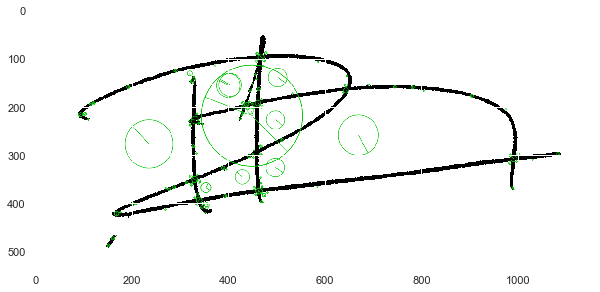

In [113]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
import cv2
import numpy as np

img = cv2.imread('SigComp2009-evaluation/genuines/NFI-01101011.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp, outImage=np.array([]), color=(10,200, 10),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

The green circle represents keypoints and we can also see the orientation of the descriptor for a perticular keypoint.

### Prepare training data for feature : Sift_matches , avg_sift_dist
* <b> Sift_matches - </b> It is the number of keypoints from image 1 whose descriptor matches with atlest one descriptor of image 2. 
* <b> avg_sift_dist - </b> It is the average distance of matched descriptor from image 1 and image 2.

In [94]:
# img1 is query image and img2 is train image
def get_sift(file1,file2,label):
    '''
    This function returns counts of sift_matches and avg_sift_dist for training data.
    '''
    
    if label == 1:
        img1 = cv2.imread('SigComp2009-evaluation/genuines/'+file1)
    else:
        img1 = cv2.imread('SigComp2009-evaluation/forgeries/'+file1)
    
    img2 = cv2.imread('SigComp2009-evaluation/genuines/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #sift
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    
    matches = sorted(matches, key = lambda x:x.distance)
    
    sum_dist = 0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [95]:
from tqdm.notebook import tqdm
sift_matches = []
sift_avg_dist = []

for i in tqdm(range(len(train_input1_files))):
    
    match,avg_dist = get_sift(train_input2_files[i],train_input1_files[i],label[i])
    sift_matches.append(match)
    sift_avg_dist.append(avg_dist)

In [96]:
train_df['sift_match'] = sift_matches
train_df['sift_avg_dist'] = sift_avg_dist
train_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist
0   3642      1      11  2345.686680         120    1147.216667
1  10016      1       1  2236.184474          83    1442.168675
2   2130      1      28  2007.849347          95    1453.663158
3   2062      0       0  2018.083001          96    1207.552083
4   5256      0       4  2262.874057         206    1258.378641

### Analysis the distribution of the feature : sift_match, sift_avg_dist

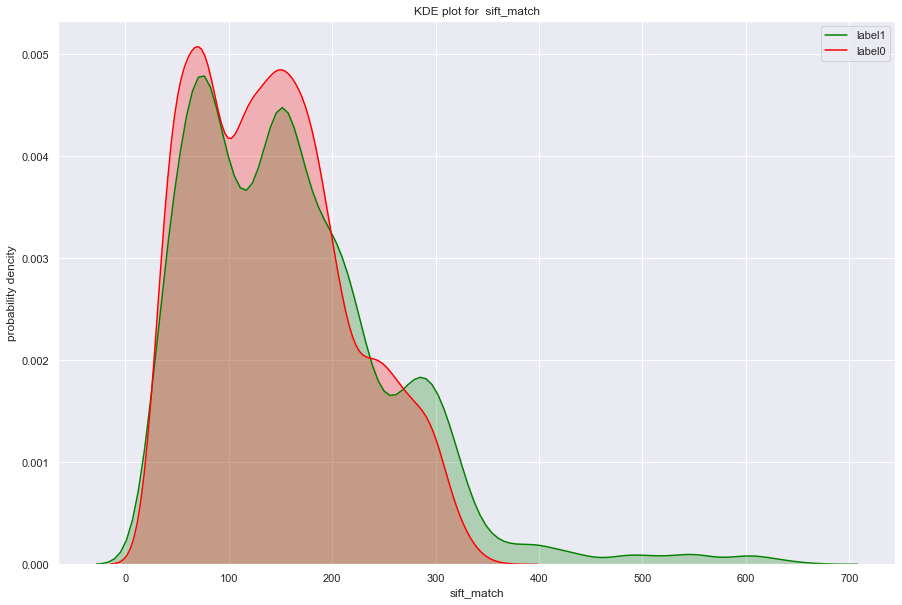

In [98]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'sift_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* This feature might not very helpfull for classifiaction as most of the region are overlapped but the right tail is long for label1 as compared to label 0. 

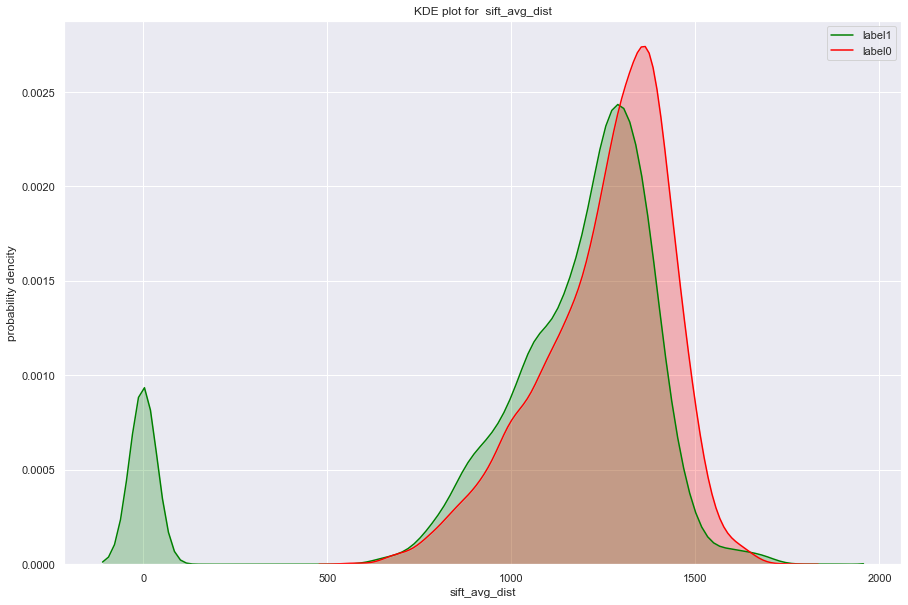

In [99]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'sift_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The feature sift_avg_dist might helpfull for classification as there is difference in distribution for label1 and label0 data.

### Prepare test data for feature : Sift_matches , avg_sift_dist

In [100]:
# refrence https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html
# img1 is query image and img2 is train image
def get_sift_test(file1,file2):
    '''
    This function returns number sift_matches and sift_avg_dist for test data
    '''
    
    img1 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file1)
    img2 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file2)
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #sift
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    
    matches = sorted(matches, key = lambda x:x.distance)
    
    sum_dist = 0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [101]:
from tqdm.notebook import tqdm
sift_matches_test = []
sift_avg_dist_test = []

for i in tqdm(range(len(test_input1_files))):
    
    match,avg_dist = get_sift_test(test_input2_files[i],test_input1_files[i])
    sift_matches_test.append(match)
    sift_avg_dist_test.append(avg_dist)

In [102]:
test_df['sift_match'] = sift_matches_test
test_df['sift_avg_dist'] = sift_avg_dist_test
test_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist
0  1845      0       3  1869.285425         375    1223.666667
1   172      0      10  2154.085653         285     815.392982
2   405      0       5  1951.912908         664     770.140060
3   249      0      11  2043.453939         180     983.861111
4   756      1       6  2150.571087         318     728.097484

### Analysis the distribution of feature(test data) : sift_match , sift_avg_dist 

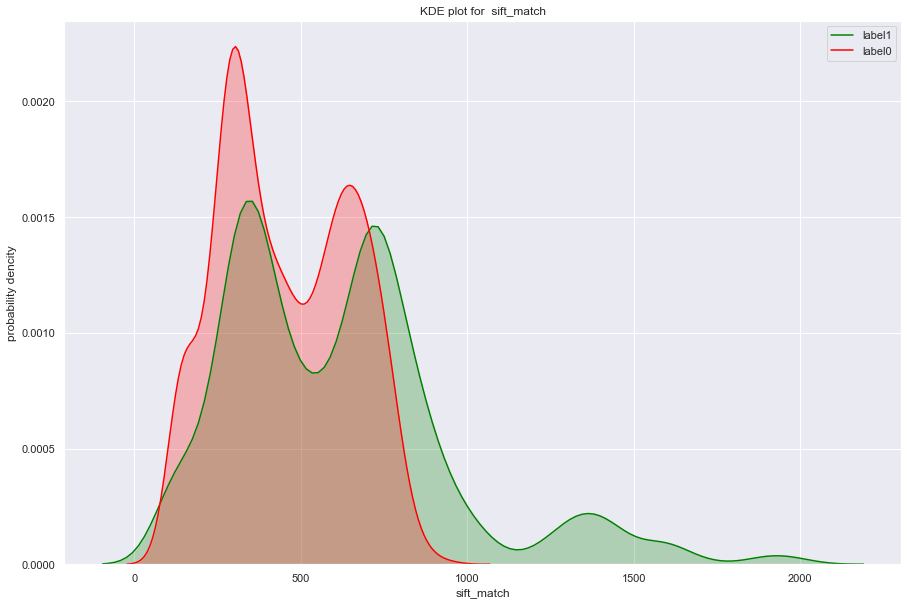

In [103]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'sift_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distrbution is not completely overlapped so the feature might helpfull for classification.

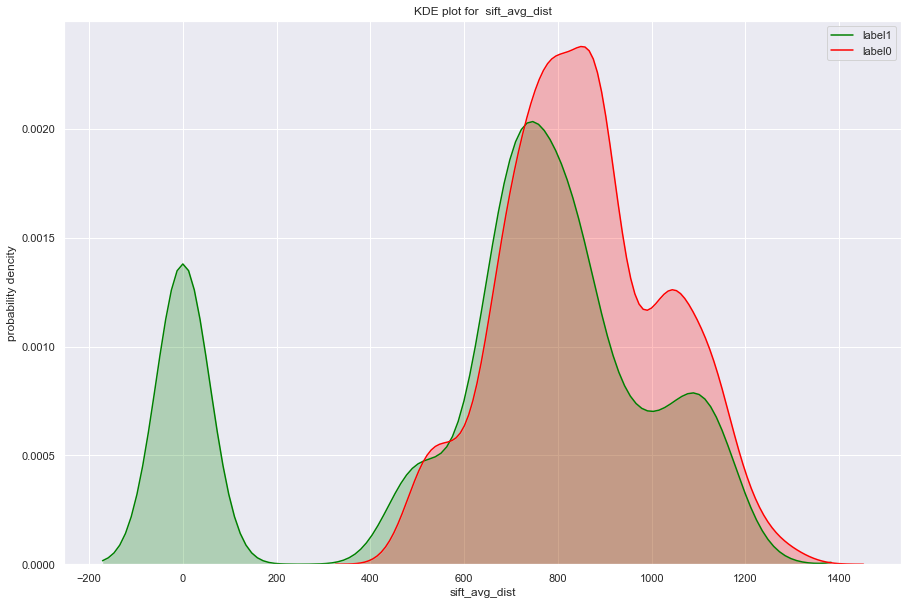

In [104]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'sift_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distrbution is not completely overlapped so the feature might helpfull for classification.

## SURF (Speeded-Up Robust Features)
Surf is speeded-up version of Sift algorithm. Surf also calculate the keypoints and its descriptor but uses the different algorithms to find it. To get the full knowledge about Surf algorithm please refer this link.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html

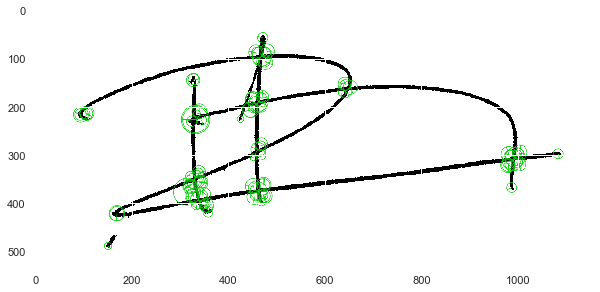

In [109]:
import cv2
import numpy as np

img = cv2.imread('SigComp2009-evaluation/genuines/NFI-01101011.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

surf = cv2.xfeatures2d.SURF_create(40)
kp = surf.detect(gray,None)
img=cv2.drawKeypoints(gray,kp[0:100], outImage=np.array([]), color=(10,200, 10),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()

In the above signature I have shown only 100 keypoints and we can see those green circle are actually the corners of image. Using Surf algorithm we can also get the orientation of descriptor same as we got using sift algorithm.

### Prepare training data for feature : surf_match, avg_surf_dist

In [114]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_surf_intro/py_surf_intro.html
# img1 is query image and img2 is train image
def get_surf(file1,file2,label):
    
    if label == 1:
        img1 = cv2.imread('SigComp2009-evaluation/genuines/'+file1)
    else:
        img1 = cv2.imread('SigComp2009-evaluation/forgeries/'+file1)
    
    img2 = cv2.imread('SigComp2009-evaluation/genuines/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #surf
    surf=cv2.xfeatures2d.SURF_create()
    keypoints_1, descriptors_1 = surf.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = surf.detectAndCompute(img2,None)
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    
    matches = sorted(matches, key = lambda x:x.distance)
    
    sum_dist = 0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [115]:
from tqdm.notebook import tqdm
surf_matches = []
surf_avg_dist = []

for i in tqdm(range(len(train_input1_files))):
    
    match,avg_dist = get_surf(train_input2_files[i],train_input1_files[i],label[i])
    surf_matches.append(match)
    surf_avg_dist.append(avg_dist)

In [116]:
train_df['surf_match'] = surf_matches
train_df['surf_avg_dist'] = surf_avg_dist
train_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0   3642      1      11  2345.686680         120    1147.216667        1400   
1  10016      1       1  2236.184474          83    1442.168675         586   
2   2130      1      28  2007.849347          95    1453.663158         720   
3   2062      0       0  2018.083001          96    1207.552083         948   
4   5256      0       4  2262.874057         206    1258.378641        1341   

   surf_avg_dist  
0       0.401169  
1       0.676562  
2       0.560502  
3       0.530246  
4       0.621769

### Analysis the distribution of the feature : surf_match, avg_surf_dist

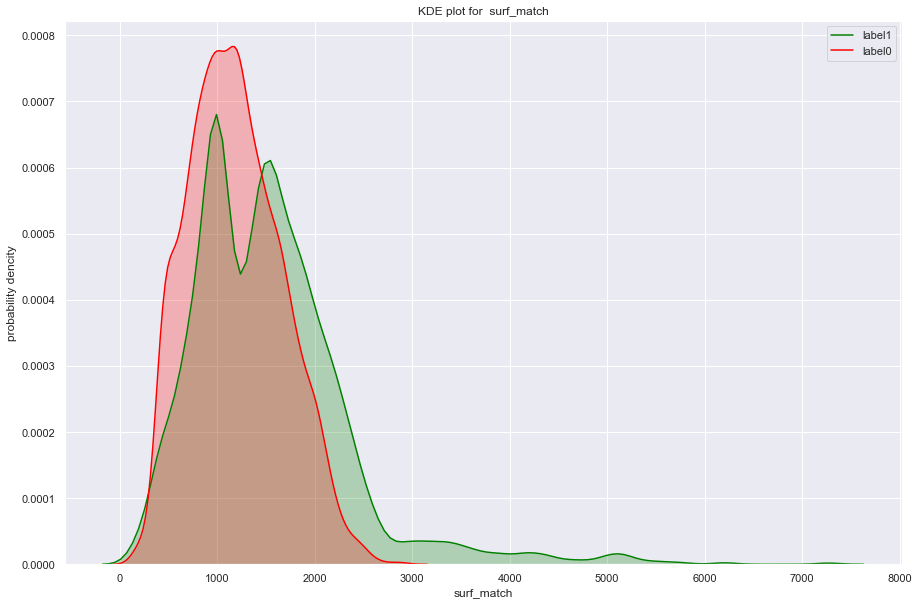

In [117]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'surf_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label1 and label0 is not completely overlapped so this feature might help for classification.

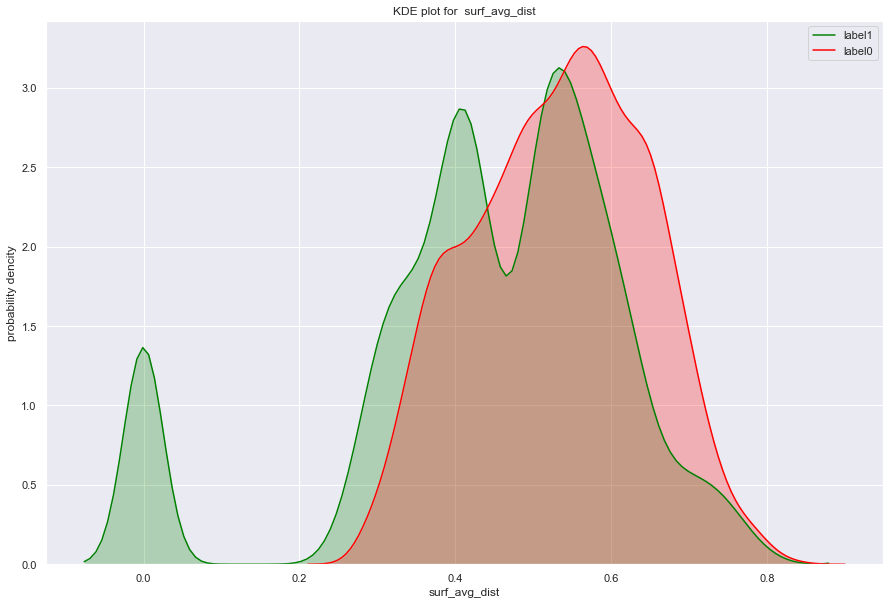

In [118]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'surf_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label1 and label0 is not completely overlapped so this feature might help for classification.

### Prepare test data for feature : surf_matches , avg_surf_dist 

In [119]:
# img1 is query image and img2 is train image
def get_surf_test(file1,file2):
    
    img1 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file1)
    img2 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    #surf
    surf=cv2.xfeatures2d.SURF_create()
    keypoints_1, descriptors_1 = surf.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = surf.detectAndCompute(img2,None)
    #feature matching
    bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
    matches = bf.match(descriptors_1,descriptors_2)
    
    matches = sorted(matches, key = lambda x:x.distance)
    
    sum_dist = 0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [120]:
from tqdm.notebook import tqdm
surf_matches_test = []
surf_avg_dist_test = []

for i in tqdm(range(len(test_input1_files))):
    
    match,avg_dist = get_surf_test(test_input2_files[i],test_input1_files[i])
    surf_matches_test.append(match)
    surf_avg_dist_test.append(avg_dist)

In [121]:
test_df['surf_match'] = surf_matches_test
test_df['surf_avg_dist'] = surf_avg_dist_test
test_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0  1845      0       3  1869.285425         375    1223.666667         625   
1   172      0      10  2154.085653         285     815.392982         607   
2   405      0       5  1951.912908         664     770.140060        1155   
3   249      0      11  2043.453939         180     983.861111         360   
4   756      1       6  2150.571087         318     728.097484         592   

   surf_avg_dist  
0       0.881013  
1       0.464774  
2       0.629785  
3       0.682025  
4       0.530713

### Analysis the distribution for the feature(test data) : surf_match , surf_avg_dist

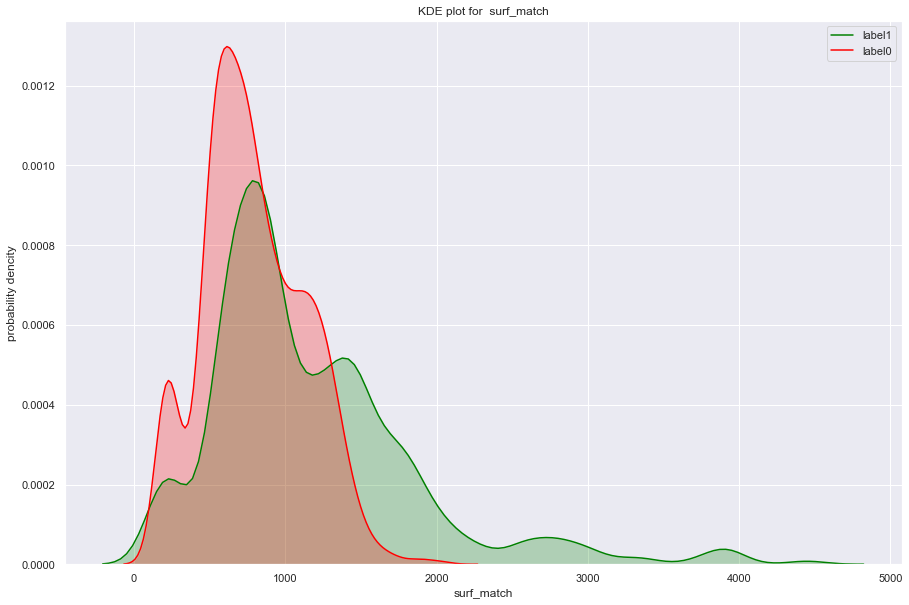

In [122]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'surf_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label1 and label0 is not completely overlapped so this feature might help for classification.

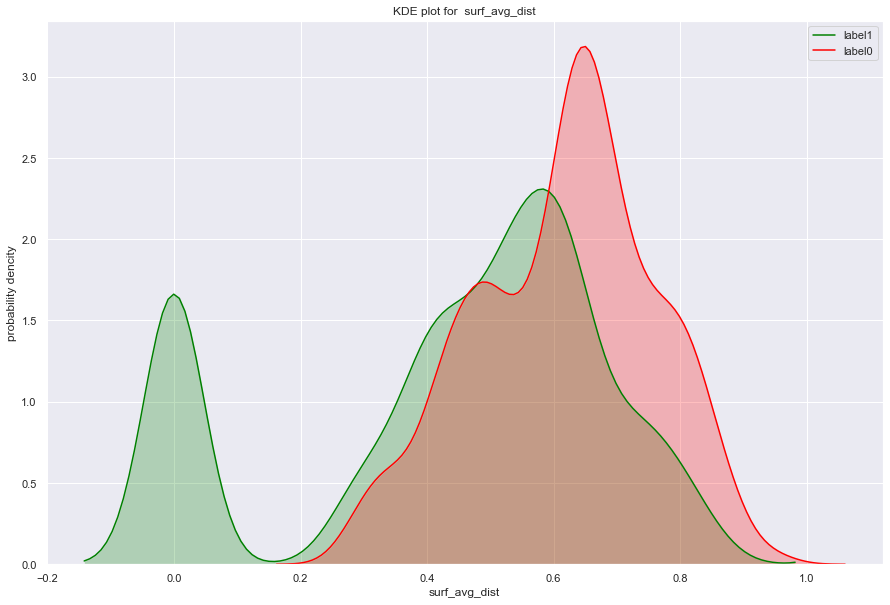

In [123]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'surf_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label1 and label0 is not completely overlapped so this feature might help for classification.

## FAST (Features from Accelerated Segment Test)
Features from Accelerated Segment Test is introduced to speed-up the feature selection process. A simple and detailed explaination is given in the link below.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_fast/py_fast.html

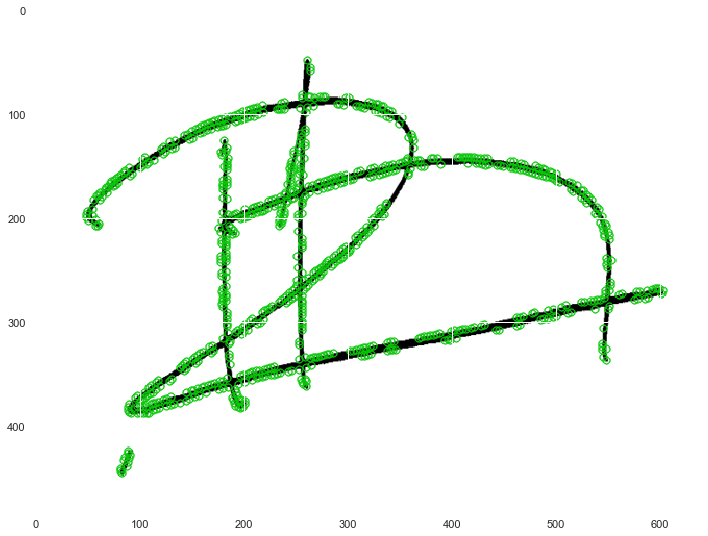

In [205]:
img = cv2.imread('SigComp2009-evaluation/genuines/NFI-01101011.png')
size = (480,640)
img = imresize(img, size=size, interp='bilinear')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
fast = cv2.FastFeatureDetector_create()    
    
# find and draw the keypoints

kp = fast.detect(gray,None)
img1 = cv2.drawKeypoints(gray,kp, outImage=np.array([]), color=(10,200, 10),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
imshow(img1)
plt.show()

Those green circle are all keypoints detected by the FAST algorithms.

### Prepare training data for feature : Number of fast corner in image

In [124]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def fast_Corner(file,label,flag):
    '''
    This function returns number of corner detected by FAST algorithm for training data.
    '''
    if flag == 0:
        if label == 1:
            folder_name = 'SigComp2009-evaluation/genuines/'
        else:
            folder_name = 'SigComp2009-evaluation/forgeries/'
    else:
        folder_name = 'SigComp2009-evaluation/genuines/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    fast = cv2.FastFeatureDetector_create()
    kp = fast.detect(gray,None)

    return len(kp)

In [125]:
from tqdm.notebook import tqdm
fast_corner_count = []

for i in tqdm(range(len(train_input1_files))):
    corners1 = fast_Corner(train_input1_files[i],label[i],1)
    corners2 = fast_Corner(train_input2_files[i],label[i],0)
    fast_corner_count.append(abs(corners1-corners2))

In [126]:
train_df['fast_corners'] = fast_corner_count
train_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0   3642      1      11  2345.686680         120    1147.216667        1400   
1  10016      1       1  2236.184474          83    1442.168675         586   
2   2130      1      28  2007.849347          95    1453.663158         720   
3   2062      0       0  2018.083001          96    1207.552083         948   
4   5256      0       4  2262.874057         206    1258.378641        1341   

   surf_avg_dist  fast_corners  
0       0.401169            35  
1       0.676562           294  
2       0.560502           107  
3       0.530246            27  
4       0.621769            74

### Analysis the distribution for feature : fast_corners

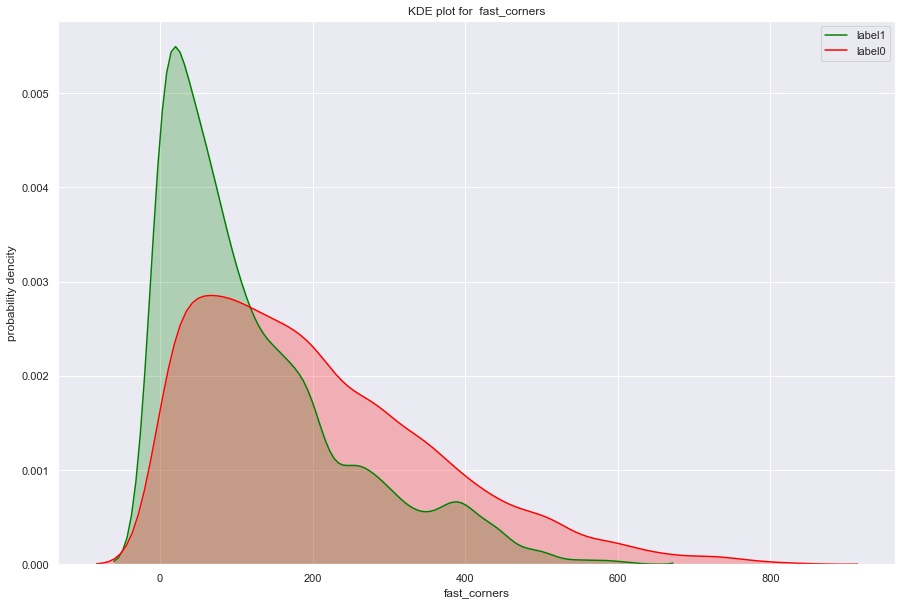

In [127]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'fast_corners'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distrbution of feature for label0 and label1 is not completely overlapped so this feature might be helpfull for classification.

### Prepare test data for feature : Number of fast corner in image

In [128]:
# reference https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html
import cv2
import numpy as np

def fast_Corner_test(file):
    '''
    This function returns number of corners detected by FAST algo for test data. 
    '''

    folder_name = 'SigComp2009-training/NISDCC-offline-all-001-051-6g/'
        
    size = (480,640)   
    filename = folder_name + file
    img = cv2.imread(filename)
    img = imresize(img, size=size, interp='bilinear')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    fast = cv2.FastFeatureDetector_create()
    kp = fast.detect(gray,None)

    return len(kp)

In [129]:
from tqdm.notebook import tqdm
fast_corner_count_test = []

for i in tqdm(range(len(test_input1_files))):
    corners1 = fast_Corner_test(test_input1_files[i])
    corners2 = fast_Corner_test(test_input2_files[i])
    fast_corner_count_test.append(abs(corners1-corners2))

In [130]:
test_df['fast_corners'] = fast_corner_count_test
test_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0  1845      0       3  1869.285425         375    1223.666667         625   
1   172      0      10  2154.085653         285     815.392982         607   
2   405      0       5  1951.912908         664     770.140060        1155   
3   249      0      11  2043.453939         180     983.861111         360   
4   756      1       6  2150.571087         318     728.097484         592   

   surf_avg_dist  fast_corners  
0       0.881013           360  
1       0.464774           103  
2       0.629785           121  
3       0.682025           441  
4       0.530713            98

### Analysis the distribution of feature : fast_corneres

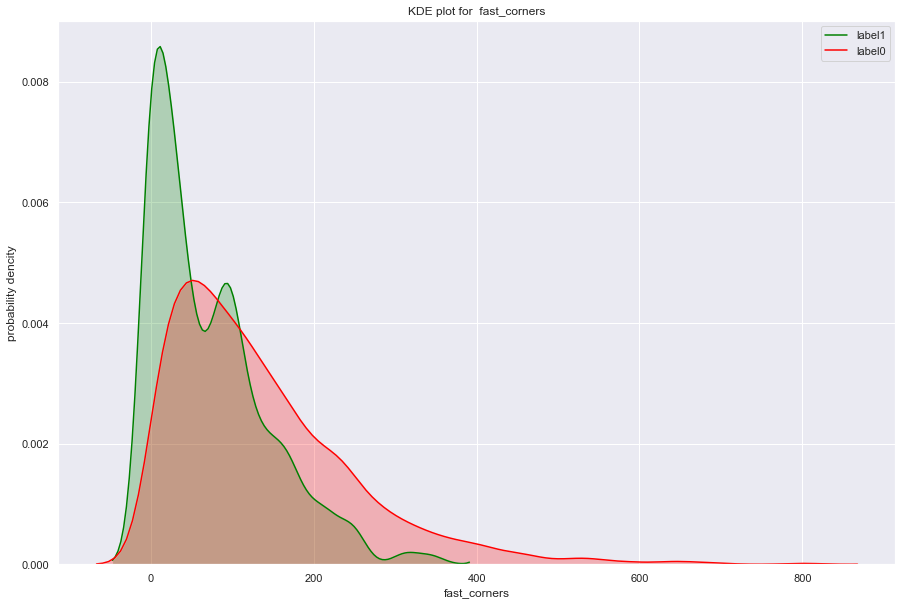

In [131]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'fast_corners'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

## BRIEF (Binary Robust Independent Elementary Features)
The main problem with algorithm like SIFT and SURF is their descriptor and 128 or 64 dimentional floating points. This kind of algorithm might have memory essue if the size of image is large. BRIEF is introduced to solve this problem by converting floating point number to binary number and while matching it used hamming distance.


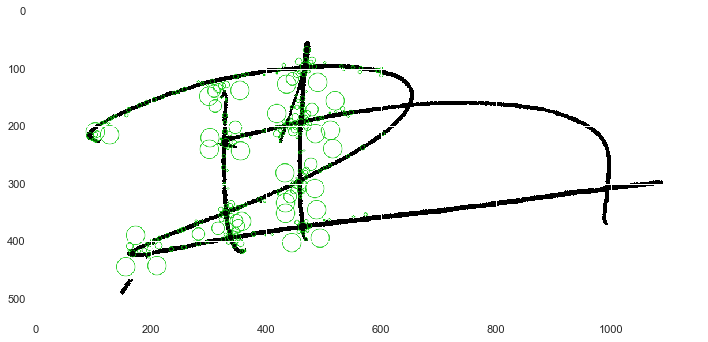

In [206]:
img = cv2.imread('SigComp2009-evaluation/genuines/NFI-01101011.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
star1 = cv2.xfeatures2d.StarDetector_create()
# Initiate BRIEF extractor
brief1 = cv2.xfeatures2d.BriefDescriptorExtractor_create()
# find the keypoints with STAR
kp1 = star1.detect(img,None)
# compute the descriptors with BRIEF
kp1, des1 = brief1.compute(img1, kp1)

img1 = cv2.drawKeypoints(img,kp1, outImage=np.array([]), color=(10,200, 10),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
imshow(img1)
plt.show()

Those green circles are all the keypoints detected by the BRIEF algorithm.

### Prepare training data for feature : brief_match , brief_avg_dist

In [139]:
# img1 is query image and img2 is train image
def get_brief(file1,file2,label):
    '''
    This function returns number of keypoint matches in pair of images and avg_dist using BRIEF algorithm. 
    '''
    
    if label == 1:
        img1 = cv2.imread('SigComp2009-evaluation/genuines/'+file1)
    else:
        img1 = cv2.imread('SigComp2009-evaluation/forgeries/'+file1)
    
    img2 = cv2.imread('SigComp2009-evaluation/genuines/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    star1 = cv2.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief1 = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp1 = star1.detect(img1,None)
    # compute the descriptors with BRIEF
    kp1, des1 = brief1.compute(img1, kp1)
    
    star2 = cv2.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief2 = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp2 = star2.detect(img2,None)
    # compute the descriptors with BRIEF
    kp2, des2 = brief2.compute(img2, kp2)    
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    sum_dist=0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [140]:
from tqdm.notebook import tqdm
brief_matches = []
brief_avg_dist = []

for i in tqdm(range(len(train_input1_files))):
    
    match,avg_dist = get_brief(train_input2_files[i],train_input1_files[i],label[i])
    brief_matches.append(match)
    brief_avg_dist.append(avg_dist)

In [141]:
train_df['brief_match'] = brief_matches
train_df['brief_avg_dist'] = brief_avg_dist
train_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0   3642      1      11  2345.686680         120    1147.216667        1400   
1  10016      1       1  2236.184474          83    1442.168675         586   
2   2130      1      28  2007.849347          95    1453.663158         720   
3   2062      0       0  2018.083001          96    1207.552083         948   
4   5256      0       4  2262.874057         206    1258.378641        1341   

   surf_avg_dist  fast_corners  brief_match  brief_avg_dist  
0       0.401169            35          161       26.527950  
1       0.676562           294           92       40.543478  
2       0.560502           107          115       29.573913  
3       0.530246            27          154       29.077922  
4       0.621769            74          244       29.163934

### Analysis the distribution of feature : brief_matches , brif_avg_dist 

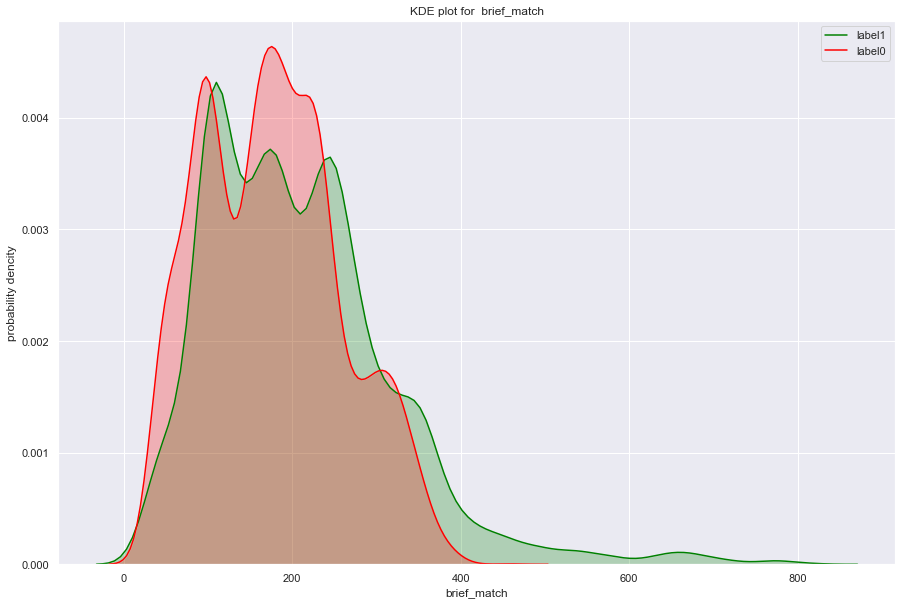

In [142]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'brief_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label 1 and label 0 are not completely overlapped so the this feature might be usefull for classification.

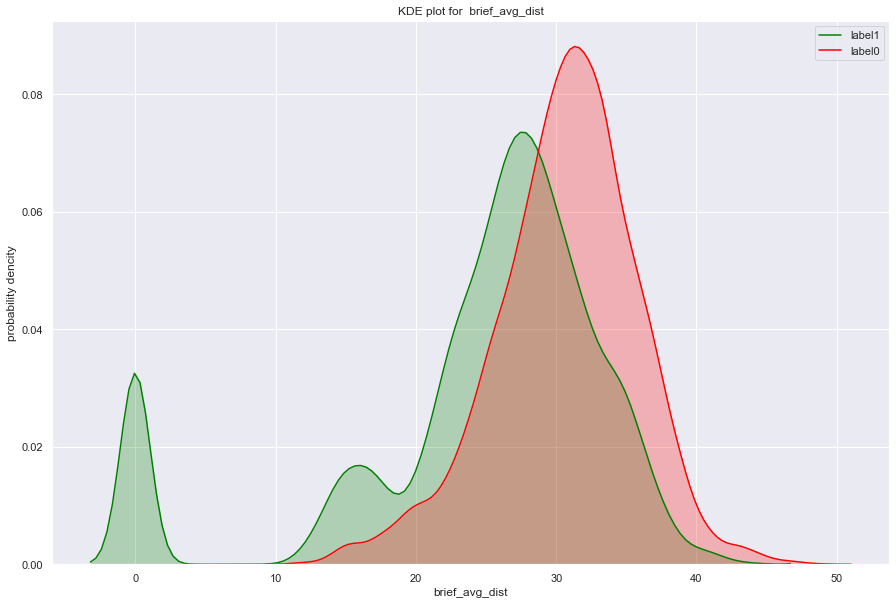

In [143]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'brief_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label 1 and label 0 are not completely overlapped so the this feature might be usefull for classification.

### Prepare test data for feature : brief_match , brief_avg_dist

In [146]:
# img1 is query image and img2 is train image
def get_brief_test(file1,file2):
    '''
    This function returns number of keypoint matches in pair of images and avg_dist using BRIEF algorithm. 
    '''
    
    img1 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file1)
    img2 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    star1 = cv2.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief1 = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp1 = star1.detect(img1,None)
    # compute the descriptors with BRIEF
    kp1, des1 = brief1.compute(img1, kp1)
    
    star2 = cv2.xfeatures2d.StarDetector_create()
    # Initiate BRIEF extractor
    brief2 = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    # find the keypoints with STAR
    kp2 = star2.detect(img2,None)
    # compute the descriptors with BRIEF
    kp2, des2 = brief2.compute(img2, kp2)    
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    sum_dist=0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [147]:
from tqdm.notebook import tqdm
brief_matches_test = []
brief_avg_dist_test = []

for i in tqdm(range(len(test_input1_files))):
    
    match,avg_dist = get_brief_test(test_input2_files[i],test_input1_files[i])
    brief_matches_test.append(match)
    brief_avg_dist_test.append(avg_dist)

In [148]:
test_df['brief_match'] = brief_matches_test
test_df['brief_avg_dist'] = brief_avg_dist_test
test_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0  1845      0       3  1869.285425         375    1223.666667         625   
1   172      0      10  2154.085653         285     815.392982         607   
2   405      0       5  1951.912908         664     770.140060        1155   
3   249      0      11  2043.453939         180     983.861111         360   
4   756      1       6  2150.571087         318     728.097484         592   

   surf_avg_dist  fast_corners  brief_match  brief_avg_dist  
0       0.881013           360          148       41.202703  
1       0.464774           103           48       32.770833  
2       0.629785           121          184       25.994565  
3       0.682025           441           55       38.381818  
4       0.530713            98          105       22.600000

### Analysis the distribution of feature : brief_matches , brief_avg_dist

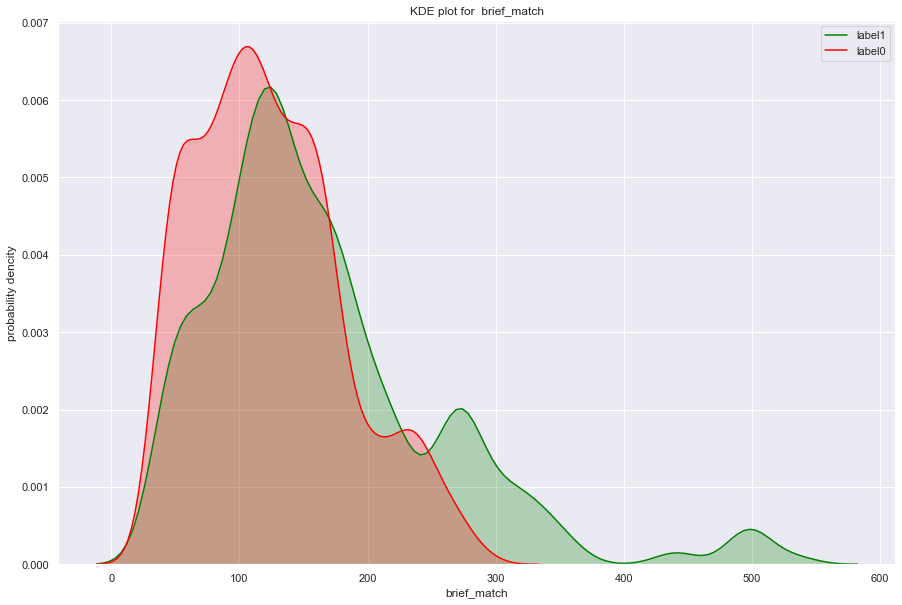

In [149]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'brief_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label 1 and label 0 are not completely overlapped so the this feature might be usefull for classification.

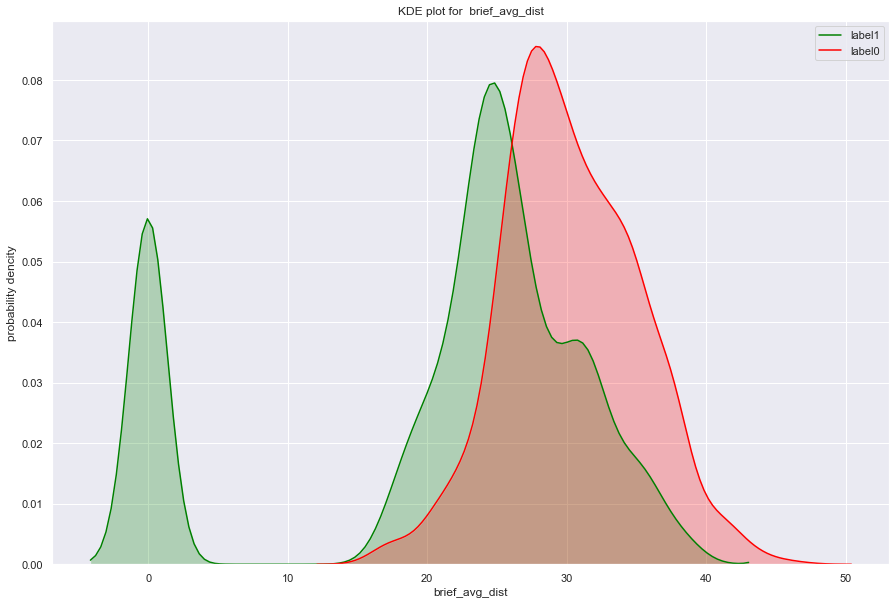

In [150]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'brief_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* The distribution for label 1 and label 0 are not completely overlapped so the this feature might be usefull for classification.

## ORB (Oriented FAST and Rotated BRIEF)

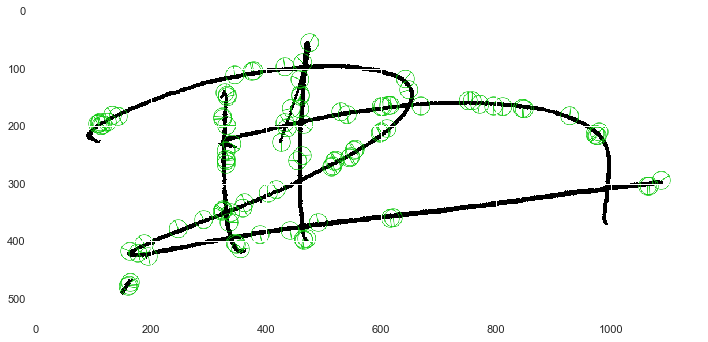

In [209]:
img = cv2.imread('SigComp2009-evaluation/genuines/NFI-01101011.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
# Initiate SIFT detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img,None)
img1 = cv2.drawKeypoints(img,kp1[0:100], outImage=np.array([]), color=(10,200, 10),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
imshow(img1)
plt.show()

Those green points in the image are the keypoints detected by the ORB algorith.

### Prepare training data for feature : orb_matches , orb_avg_dist

In [151]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# img1 is query image and img2 is train image
def get_orb(file1,file2,label):
    '''
    This function returns number of keypoint matches and avg_dist using ORB algorithm.
    '''
    
    if label == 1:
        img1 = cv2.imread('SigComp2009-evaluation/genuines/'+file1)
    else:
        img1 = cv2.imread('SigComp2009-evaluation/forgeries/'+file1)
    
    img2 = cv2.imread('SigComp2009-evaluation/genuines/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initiate ORB detector
    orb = cv2.ORB_create()

    # find the keypoints and descriptors with ORB
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    sum_dist=0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [152]:
from tqdm.notebook import tqdm
orb_matches = []
orb_avg_dist = []

for i in tqdm(range(len(train_input1_files))):
    
    match,avg_dist = get_orb(train_input2_files[i],train_input1_files[i],label[i])
    orb_matches.append(match)
    orb_avg_dist.append(avg_dist)

In [153]:
train_df['orb_match'] = orb_matches
train_df['orb_avg_dist'] = orb_avg_dist
train_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0   3642      1      11  2345.686680         120    1147.216667        1400   
1  10016      1       1  2236.184474          83    1442.168675         586   
2   2130      1      28  2007.849347          95    1453.663158         720   
3   2062      0       0  2018.083001          96    1207.552083         948   
4   5256      0       4  2262.874057         206    1258.378641        1341   

   surf_avg_dist  fast_corners  brief_match  brief_avg_dist  orb_match  \
0       0.401169            35          161       26.527950        243   
1       0.676562           294           92       40.543478        191   
2       0.560502           107          115       29.573913        245   
3       0.530246            27          154       29.077922        254   
4       0.621769            74          244       29.163934        251   

   orb_avg_dist  
0     37.925926  
1     46.439791  
2     39.604082  
3     33.637795  
4     37.645418

### Analysis the disribution of features : orb_matches, orb_avg_dist

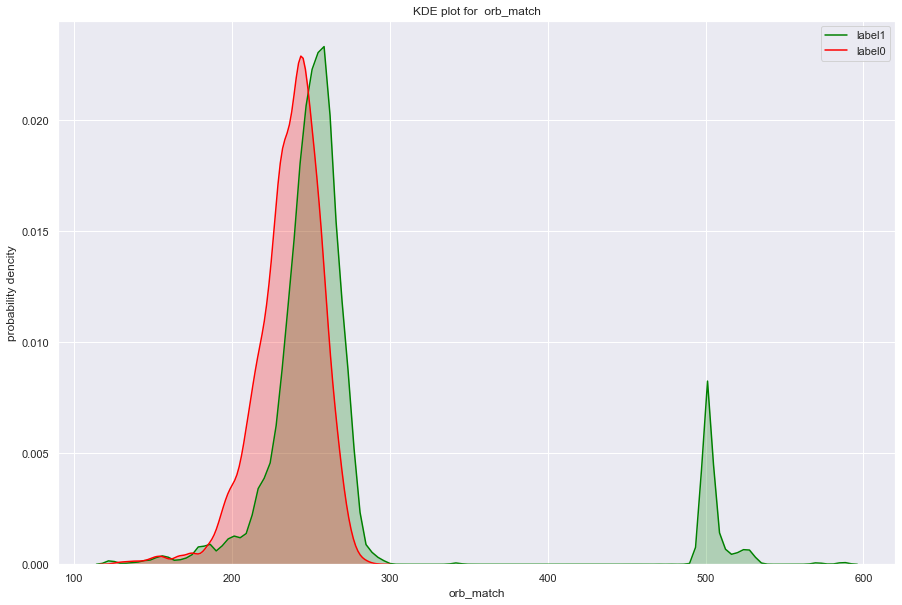

In [154]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'orb_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* distribution for label0 and label1 are not completely overlapped so this might be usefull for classification.

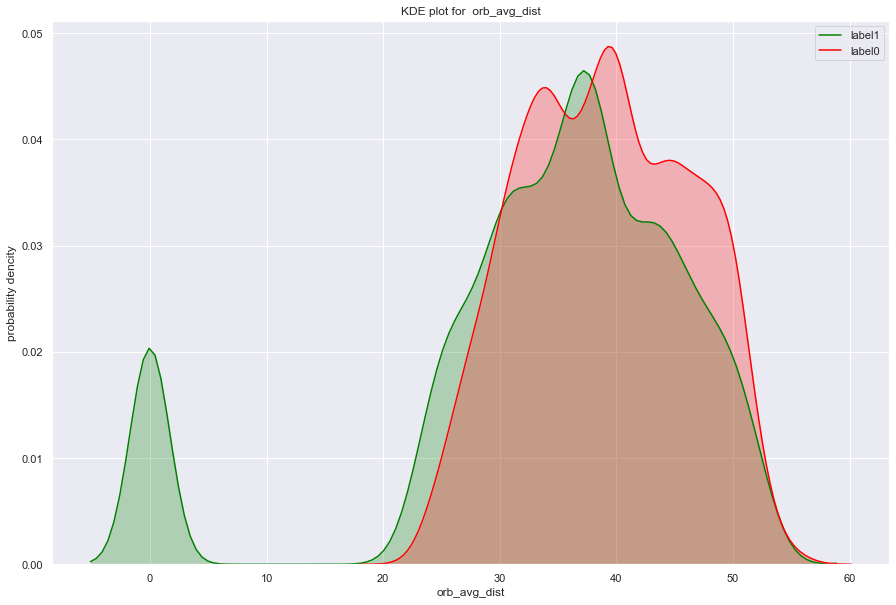

In [155]:
train_df_label_1 = train_df[train_df['label']==1]
train_df_label_0 = train_df[train_df['label']==0]

i = 'orb_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(train_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(train_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* distribution for label0 and label1 are not completely overlapped so this might be usefull for classification.

### Prepare test data for feature : orb_matches , orb_avg_dist

In [156]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
# img1 is query image and img2 is train image
def get_orb_test(file1,file2):
    '''
    This function returns number of keypoint matches and avg_dist using ORB algorithm.
    '''
    
    img1 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file1)
    img2 = cv2.imread('SigComp2009-training/NISDCC-offline-all-001-051-6g/'+file2)
        
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    orb = cv2.ORB_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)

    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    sum_dist=0
    for m in matches:
        sum_dist += m.distance
    avg_dist = sum_dist/(len(matches))
    
    return len(matches) , avg_dist

In [157]:
from tqdm.notebook import tqdm
orb_matches_test = []
orb_avg_dist_test = []

for i in tqdm(range(len(test_input1_files))):
    
    match,avg_dist = get_orb_test(test_input2_files[i],test_input1_files[i])
    orb_matches_test.append(match)
    orb_avg_dist_test.append(avg_dist)

In [158]:
test_df['orb_match'] = orb_matches_test
test_df['orb_avg_dist'] = orb_avg_dist_test
test_df.head()

hc  label  hc_acc   Shi_Tomasi  sift_match  sift_avg_dist  surf_match  \
0  1845      0       3  1869.285425         375    1223.666667         625   
1   172      0      10  2154.085653         285     815.392982         607   
2   405      0       5  1951.912908         664     770.140060        1155   
3   249      0      11  2043.453939         180     983.861111         360   
4   756      1       6  2150.571087         318     728.097484         592   

   surf_avg_dist  fast_corners  brief_match  brief_avg_dist  orb_match  \
0       0.881013           360          148       41.202703        216   
1       0.464774           103           48       32.770833        222   
2       0.629785           121          184       25.994565        246   
3       0.682025           441           55       38.381818        186   
4       0.530713            98          105       22.600000        243   

   orb_avg_dist  
0     48.291667  
1     36.990991  
2     31.418699  
3     37.543011  
4     31.506173

### Analysis the distribution of feature : orb_match , orb_avg_dist

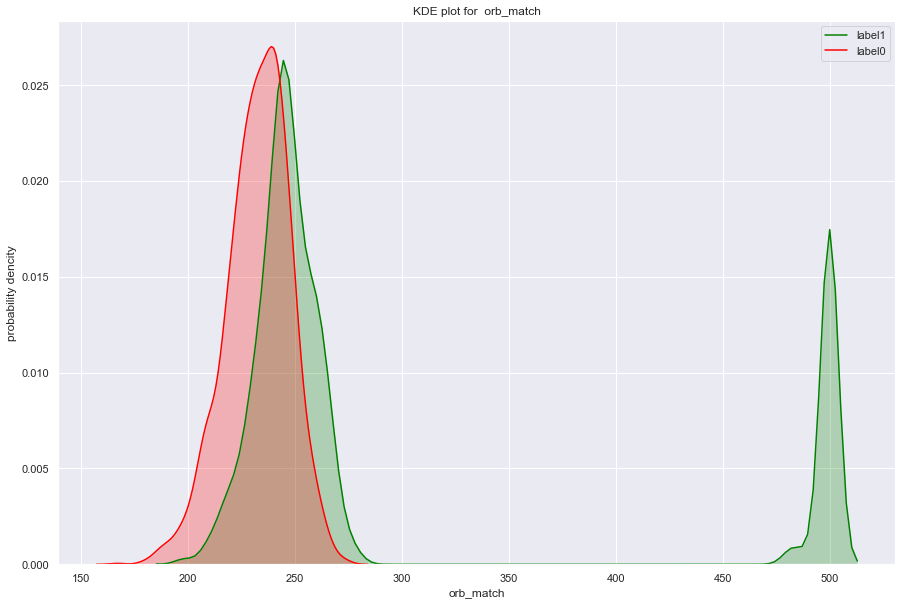

In [160]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'orb_match'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* distribution for label0 and label1 are not completely overlapped so this might be usefull for classification.

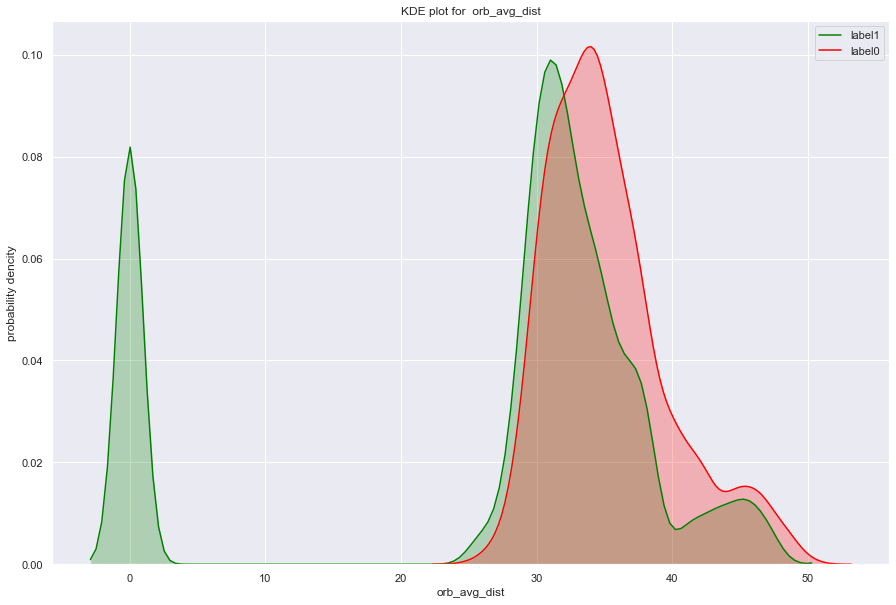

In [161]:
test_df_label_1 = test_df[test_df['label']==1]
test_df_label_0 = test_df[test_df['label']==0]

i = 'orb_avg_dist'
sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
sns.kdeplot(test_df_label_1[i], shade=True,label = 'label1', color = 'green')
sns.kdeplot(test_df_label_0[i], shade=True,label = 'label0', color = 'red')

plt.title('KDE plot for  ' + i)
plt.xlabel(i)
plt.ylabel('probability dencity')
plt.show()

### Observation
* distribution for label0 and label1 are not completely overlapped so this might be usefull for classification.

## Prepare Offline Training and test data 

In [172]:
y_train = train_df['label'].values
X_train = train_df.drop(['label'],axis = 1).values
y_test = test_df['label'].values
X_test = test_df.drop(['label'],axis = 1).values

print('training data :',X_train.shape,y_train.shape)
print('test data :',X_test.shape,y_test.shape)

training data : (15000, 12) (15000,)
test data : (4971, 12) (4971,)


# Decision Tree Model

In [191]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

start = time.time()
params = {'criterion' :['gini', 'entropy'],
          'min_samples_split':[2,3,4,5,6,7,8,9],
          'min_samples_leaf':[5,6,7],
          'max_depth':[2,3,4,5,6,7,8,9,12,15,17,20],
          'max_features':['auto', 'sqrt', 'log2', None]}

model  = DecisionTreeClassifier(class_weight='balanced')
grid = RandomizedSearchCV(model, param_distributions=params, scoring = 'f1_micro', \
                    n_jobs=-1,cv=5,return_train_score=True)          

grid.fit(X_train,y_train)
print('time taken to train the model in hours:',(time.time() - start)/3600)

time taken to train the model in hours: 0.0007741150591108534


In [192]:
grid.best_estimator_

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=17, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Number of misclassified points  8.43180452633687
----------------------------------- Confusion matrix -----------------------------------


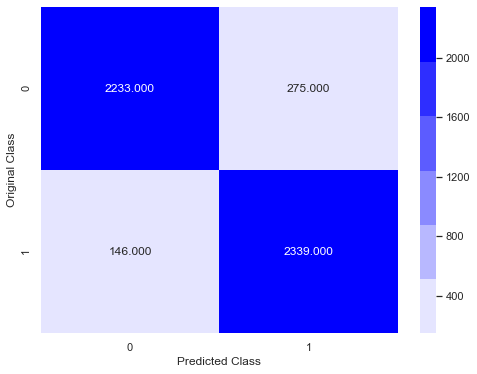

----------------------------------- Precision matrix -----------------------------------


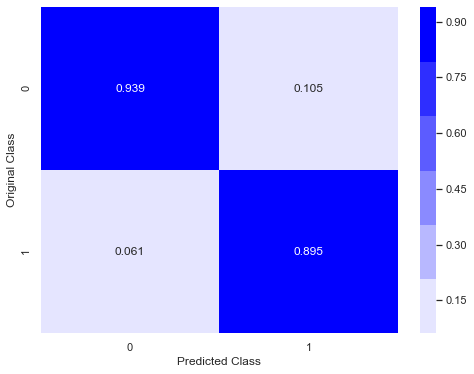

Sum of columns in precision matrix [1. 1.]
----------------------------------- Recall matrix -----------------------------------


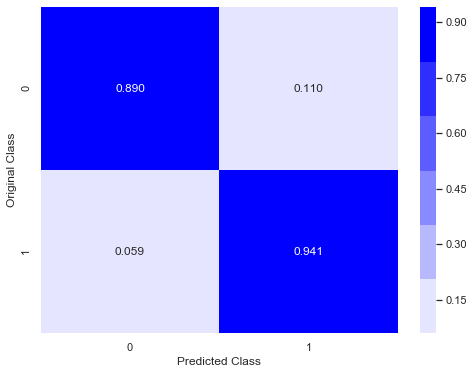

Sum of rows in precision matrix [1. 1.]
f1 score for training data : 0.9604753638670049
f1 score for test data : 0.9156819547366313


In [193]:
model = grid.best_estimator_
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_confusion_matrix(y_test,y_test_pred)

from sklearn.metrics import f1_score
print('='*100)
print('f1 score for training data :',f1_score(y_train, y_train_pred , average='micro'))
print('f1 score for test data :',f1_score(y_test,y_test_pred , average='micro'))

### Observation
* 0.91 f1 score is achieved with only 8.43 % misclassification for offline data using Decision Tree Classifier.


### Feature importance

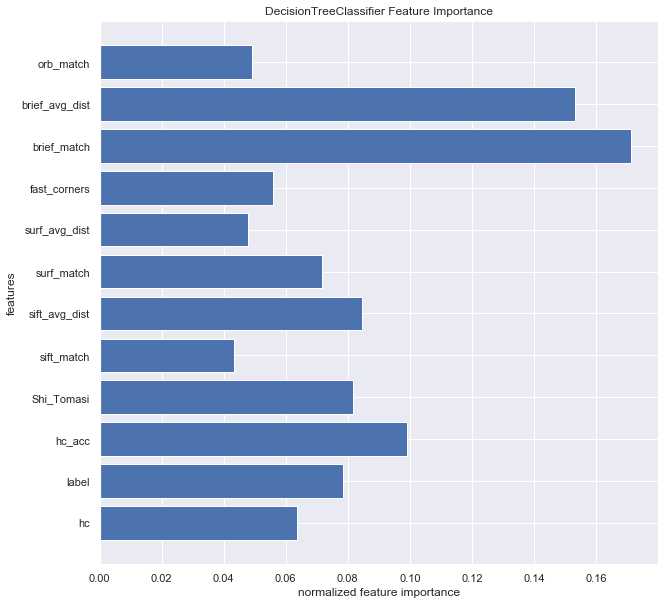

In [194]:
new_column = train_df.columns[0:-1]
sns.set(style="darkgrid")
plt.figure(figsize = (10,10))
plt.barh(y=new_column,width = model.feature_importances_)
plt.title('DecisionTreeClassifier Feature Importance')
plt.xlabel('normalized feature importance')
plt.ylabel('features')
plt.show()

### Observation
* All the feature got some importance for Decision Tree Classifier.
* Brief_avg_dist and brief_match are the most important feature picked by Decision Tree Classifier.

## EER(Equal Error rate)

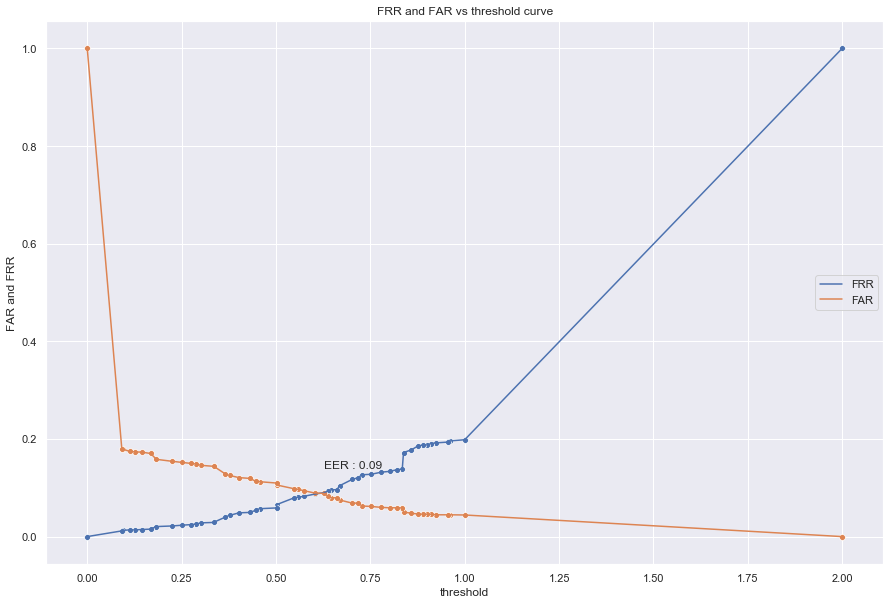

In [195]:

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

DT_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
DT_probs = DT_probs[:, 1]
DT_auc = roc_auc_score(y_test, DT_probs)
# calculate roc curves
DT_fpr, DT_tpr, threshold = roc_curve(y_test, DT_probs)
FAR = DT_fpr     # false accepatce rate is same as false positive rate
FRR = 1- DT_tpr  # false rejection rate is 1-true_positive_rate

# Equal Error rate
EER = np.round(FRR[np.argmin(abs(FAR-FRR))],decimals=3)

sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
ax = sns.scatterplot(threshold, FRR)
ax1 = sns.lineplot(threshold, FRR,label = 'FRR')

ay = sns.scatterplot(threshold, FAR)
ay1 = sns.lineplot(threshold, FAR,label = 'FAR')

idx = np.argmin(abs(FAR-FRR))
x = threshold[idx]
y = FRR[idx] + 0.05

ax.annotate('EER : {}'.format(EER),(x,y))

plt.title('FRR and FAR vs threshold curve')
plt.xlabel('threshold')
plt.ylabel('FAR and FRR')
plt.legend()

plt.show()

### Observation
* For Offline data 9% Equal error rate is achieved using Decision Tree Classifier.

# XGBClassifier

In [185]:
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# reference : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb

start = time.time()
params = {'max_depth':[5,6,7,9,11,13],
          'min_child_weight':[0.0001,0.001,0.01,0.1,1],
          'n_estimators':[50,100,200,500,600,700,800,900,1000]}


from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train),y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val]

    
model  = xgb.XGBClassifier(booster='gbtree')
grid = RandomizedSearchCV(model, param_distributions=params, scoring = 'f1_micro', \
                    n_jobs=-1,cv=5,return_train_score=True) 
                                                
grid.fit(X_train,y_train,sample_weight=w_array) 
print('time taken to train the model in sec:',time.time() - start)

time taken to train the model in sec: 305.880411863327


In [187]:
grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=0.1, missing=None, n_estimators=800, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Number of misclassified points  1.301822551572201
----------------------------------- Confusion matrix -----------------------------------


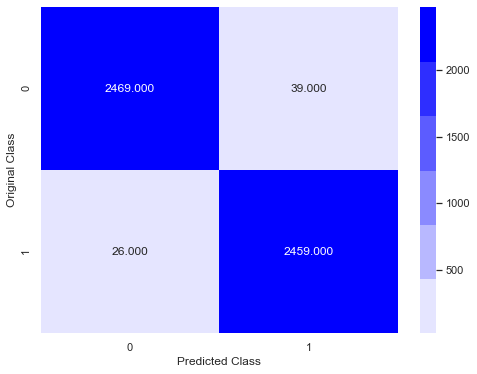

----------------------------------- Precision matrix -----------------------------------


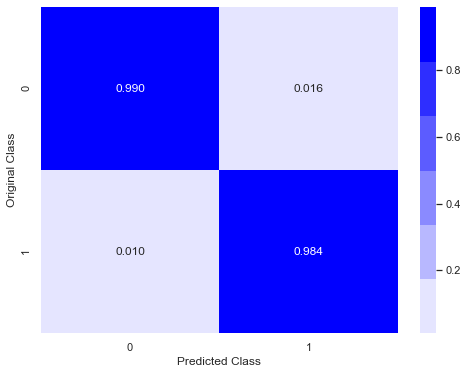

Sum of columns in precision matrix [1. 1.]
----------------------------------- Recall matrix -----------------------------------


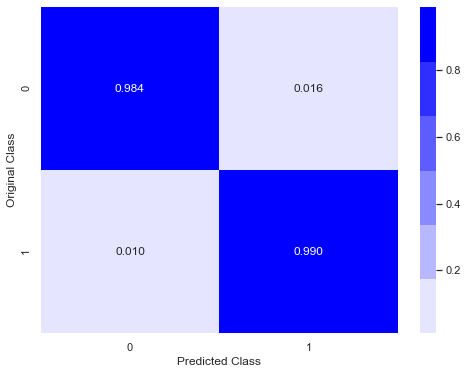

Sum of rows in precision matrix [1. 1.]
f1 score for training data : 1.0
f1 score for test data : 0.986981774484278


In [186]:
model = grid.best_estimator_
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

plot_confusion_matrix(y_test,y_test_pred)

from sklearn.metrics import f1_score
print('='*100)
print('f1 score for training data :',f1_score(y_train, y_train_pred , average='micro'))
print('f1 score for test data :',f1_score(y_test,y_test_pred , average='micro'))

### Observation
* 0.987 f1 score is achieved with only 1.3 % misclassification for offline data using XGBClassifier.

### Feature Importance

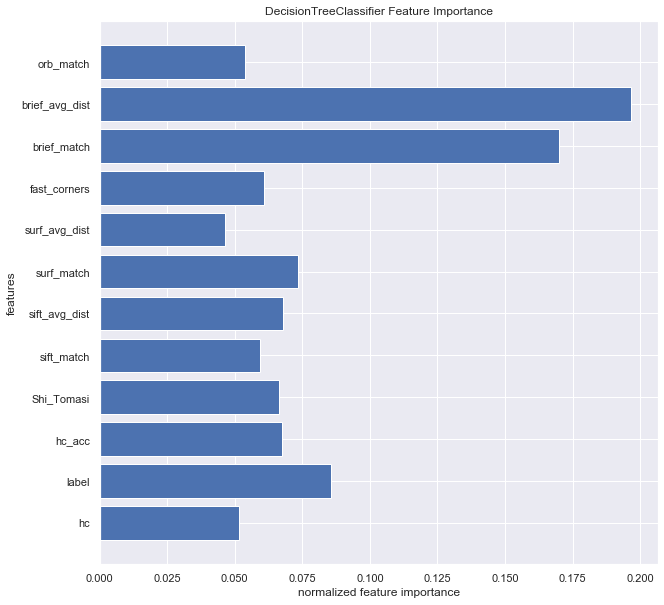

In [189]:
new_column = train_df.columns[0:-1]
sns.set(style="darkgrid")
plt.figure(figsize = (10,10))
plt.barh(y=new_column,width = model.feature_importances_)
plt.title('DecisionTreeClassifier Feature Importance')
plt.xlabel('normalized feature importance')
plt.ylabel('features')
plt.show()

### Observation
* all the feature got some importance for XGBClassifier.
* Brief_avg_dist and brief_match are most important features picked by XGBClassifier.

## EER (Equal Error Rate)

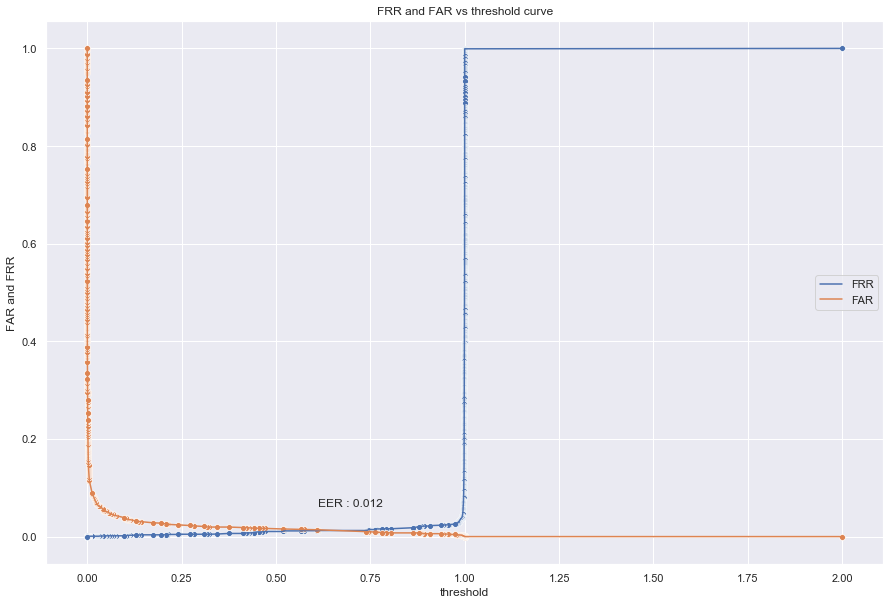

In [190]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

DT_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
DT_probs = DT_probs[:, 1]
DT_auc = roc_auc_score(y_test, DT_probs)
# calculate roc curves
DT_fpr, DT_tpr, threshold = roc_curve(y_test, DT_probs)
FAR = DT_fpr     # false accepatce rate is same as false positive rate
FRR = 1- DT_tpr  # false rejection rate is 1-true_positive_rate

# Equal Error rate
EER = np.round(FRR[np.argmin(abs(FAR-FRR))],decimals=3)

sns.set(style="darkgrid")
plt.figure(figsize = (15,10))
ax = sns.scatterplot(threshold, FRR)
ax1 = sns.lineplot(threshold, FRR,label = 'FRR')

ay = sns.scatterplot(threshold, FAR)
ay1 = sns.lineplot(threshold, FAR,label = 'FAR')

idx = np.argmin(abs(FAR-FRR))
x = threshold[idx]
y = FRR[idx] + 0.05

ax.annotate('EER : {}'.format(EER),(x,y))

plt.title('FRR and FAR vs threshold curve')
plt.xlabel('threshold')
plt.ylabel('FAR and FRR')
plt.legend()

plt.show()

## For Offline data 1.2 % Equal Error Rate is Achieved.

# Summary

In [196]:
from prettytable import PrettyTable

x = PrettyTable(['data','model','test_misclassification(%)','test_EER'])
x.add_row(['Online data','DT_Classifier',7.87,5.6])
x.add_row(['Online data','XGB_Classifier',3.17,1.1])
x.add_row(['Offline data','DT_Classifier',8.43,9])
x.add_row(['Offline data','XGB_Classifier',1.3,1.2])

print(x)

+--------------+----------------+---------------------------+----------+
|     data     |     model      | test_misclassification(%) | test_EER |
+--------------+----------------+---------------------------+----------+
| Online data  | DT_Classifier  |            7.87           |   5.6    |
| Online data  | XGB_Classifier |            3.17           |   1.1    |
| Offline data | DT_Classifier  |            8.43           |    9     |
| Offline data | XGB_Classifier |            1.3            |   1.2    |
+--------------+----------------+---------------------------+----------+
